In [1]:
import os
import vtk
import numpy as np
from vtk.util import numpy_support
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
TARGET_N = 240

def resample_array(arr, target_len):
    original_len = len(arr)
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)

def read_vtk_point_cell_data(filepath):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    # 提取按连接顺序排列的坐标
    num_points = polydata.GetNumberOfPoints()
    num_lines = polydata.GetNumberOfLines()
    if num_lines != 1:
        raise ValueError(f"{filepath} contains {num_lines} lines (expected 1)")

    line = polydata.GetLines().GetData()
    line_np = numpy_support.vtk_to_numpy(line)
    line_point_ids = line_np[1:]
    coords = np.array([polydata.GetPoint(pid) for pid in line_point_ids])

    # 插值 coords
    resampled_coords = resample_array(coords, TARGET_N)

    # 插值 point data
    point_data = {}
    pd = polydata.GetPointData()
    for i in range(pd.GetNumberOfArrays()):
        array = pd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            if len(data) == len(coords):  # 只处理与 coords 长度一致的
                resampled = resample_array(data, TARGET_N)
                point_data[name] = resampled.astype(data.dtype)
            else:
                point_data[name] = data  # 保留不变

    # 不处理 cell_data，直接保留原始数据
    cell_data = {}
    cd = polydata.GetCellData()
    for i in range(cd.GetNumberOfArrays()):
        array = cd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            cell_data[name] = data

    return point_data, cell_data, resampled_coords

def batch_read_vtk_data(directory):
    results = {}
    for fname in os.listdir(directory):
        if fname.lower().endswith(".vtk"):
            full_path = os.path.join(directory, fname)
            point_data, cell_data, coords = read_vtk_point_cell_data(full_path)
            results[fname] = {
                'point_data': point_data,
                'cell_data': cell_data,
                'coords': coords
            }
    return results

# 用法示例
base_dir = r"D:\!BraVa_src\ica_results\vmtkgeometry_91"
vtk_data_dict = batch_read_vtk_data(base_dir)

all_coords = [vtk_data_dict[name]["coords"] for name in vtk_data_dict]
coords_array = np.stack([vtk_data_dict[name]["coords"] for name in vtk_data_dict], axis=0)
# 所有曲线平移，使起点对齐到 [0, 0, 0]
coords_array = coords_array - coords_array[:, 0:1, :]
# 广播减法，coords_array[:, 0:1, :] shape 为 [N_samples, 1, 3]

In [2]:
for fname, content in vtk_data_dict.items():
    point_attrs = content['point_data']
    cell_attrs = content['cell_data']
    coords = content['coords']

    print(f"{fname}:")
    print(f"  Point attributes ({len(point_attrs)}): {list(point_attrs.keys())}")
    print(f"  Cell attributes ({len(cell_attrs)}): {list(cell_attrs.keys())}")
    print(f"  Points (coords): {coords.shape[0]}")
    print("-" * 60)

# print(list(vtk_data_dict.keys()))
# 收集所有 length 数值
# all_lengths = []
# for fname, content in vtk_data_dict.items():
#     length = content['cell_data']['Length']  # 通常是一个数值或一维数组
#     # 如果是 array 取第一个元素
#     if isinstance(length, (list, np.ndarray)):
#         length = float(np.ravel(length)[0])
#     all_lengths.append(length)

# # 计算均值和方差
# mean_length = np.mean(all_lengths)
# var_length = np.var(all_lengths, ddof=1)  # ddof=1 得到样本方差

# print("Mean Length:", mean_length)
# print("Variance of Length:", var_length)

BG0001_L.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0001_R.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0003_L.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0003_R.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0004_L.vtk:
  

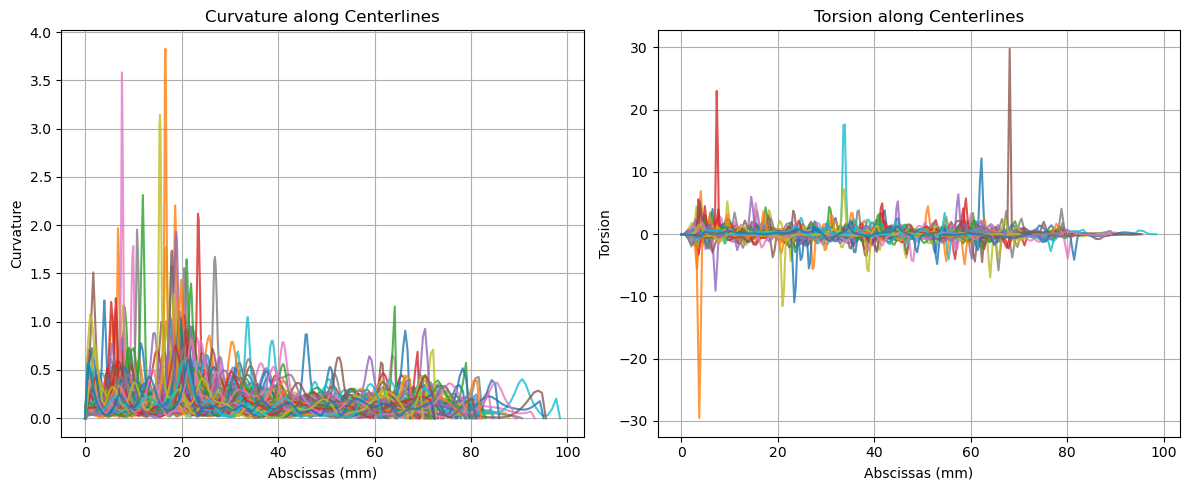

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# curvature subplot
plt.subplot(1, 2, 1)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Curvature' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Curvature'], label=fname, alpha=0.8)
plt.title("Curvature along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Curvature")
plt.grid(True)

# torsion subplot
plt.subplot(1, 2, 2)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Torsion' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Torsion'], label=fname, alpha=0.8)
plt.title("Torsion along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Torsion")
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
from io import StringIO
import sys
import re
import csv

class OutputCatcher:
    def __init__(self):
        self._stdout = sys.stdout
        self.buffer = StringIO()

    def __enter__(self):
        sys.stdout = self.buffer
        return self

    def __exit__(self, *args):
        sys.stdout = self._stdout

    def get(self):
        return self.buffer.getvalue()

def parse_alignment_log(log_text):
    pattern_iter = re.compile(r"(updating step: r=|Iteration )(\d+)")
    pattern_residual = re.compile(r"Residual(?: Change)?: ([\d\.]+)")
    pattern_energy = re.compile(r"Residual Energy: ([\d\.]+)")

    results = {}
    current_iter = None

    for line in log_text.splitlines():
        iter_match = pattern_iter.search(line)
        if iter_match:
            current_iter = int(iter_match.group(2))
            if current_iter not in results:
                results[current_iter] = {'iter': current_iter}

        res_match = pattern_residual.search(line)
        if res_match and current_iter is not None:
            results[current_iter]['residual'] = float(res_match.group(1))

        ene_match = pattern_energy.search(line)
        if ene_match and current_iter is not None:
            results[current_iter]['energy'] = float(ene_match.group(1))

    # 转成列表并排序
    return [results[k] for k in sorted(results)]


def write_log_to_csv(results, filename):
    with open(filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["iter", "residual", "energy"])
        writer.writeheader()
        writer.writerows(results)
    print(f"[log] Wrote {len(results)} rows to {filename}")


[log] Wrote 20 rows to ./alignment_plain.csv
[log] Wrote 20 rows to ./alignment_weighted.csv
✅ 保存了 aligned_curvatures_weighted，shape=(240, 91)


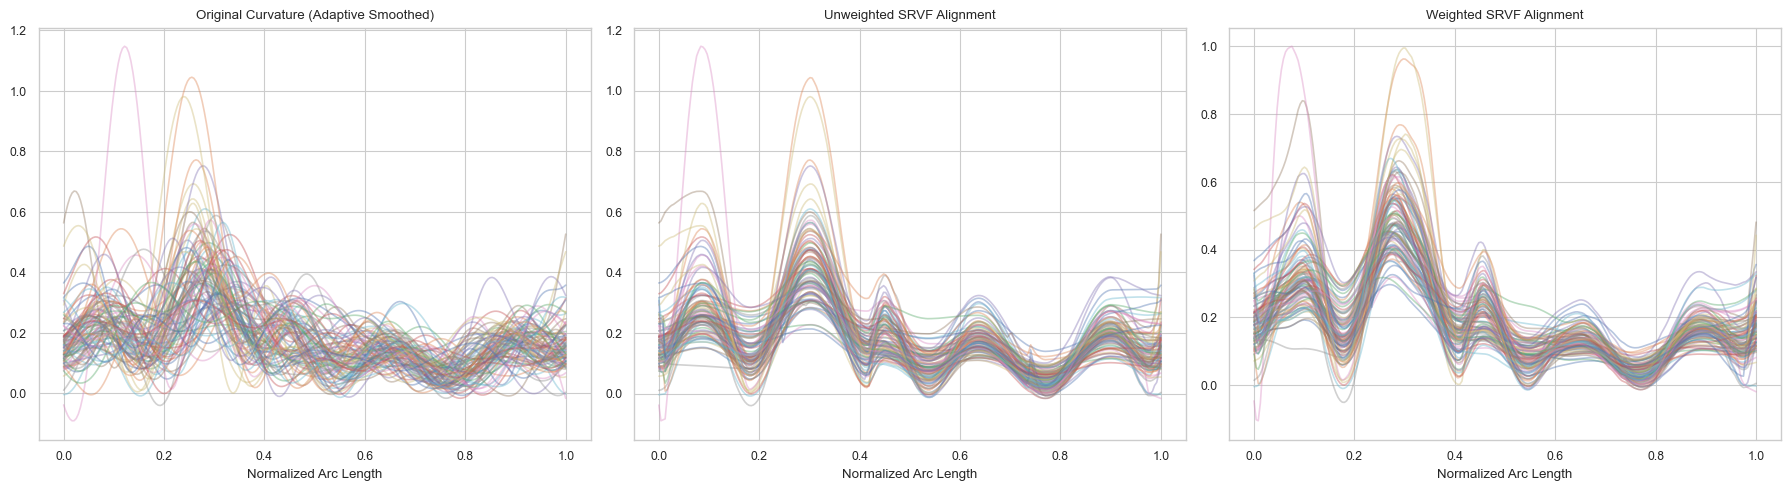

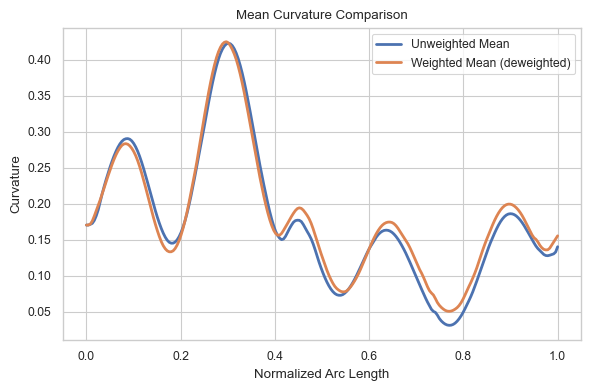

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from fdasrsf.utility_functions import resamplefunction
from fdasrsf.time_warping import fdawarp
import seaborn as sns

sns.set(style="whitegrid", context="paper", font_scale=1)
# 参数
# # target_len = 200
# target_len = 500  # 目标长度
t_resample = np.linspace(0, 1, TARGET_N )
alpha_s = 0.75

# Fourier 平滑函数
def fourier_lowpass(signal, keep_ratio):
    N = len(signal)
    fhat = fft(signal)
    keep = int(N * keep_ratio)
    fhat[keep:-keep] = 0
    return np.real(ifft(fhat))

# 自适应平滑函数：使平滑后曲线具有约 5 个峰
def adaptive_fourier_smoothing(signal, peak_target=5, tol=1, max_iter=50):
    ratios = np.linspace(0.01, 0.2, 100)
    for r in ratios:
        smoothed = fourier_lowpass(signal, keep_ratio=r)
        peaks, _ = find_peaks(smoothed,
                                prominence=(np.max(smoothed) - np.min(smoothed)) * 0.08,
                                distance=TARGET_N  // 10  # 避免过密峰值
                            )
        if abs(len(peaks) - peak_target) <= tol:
            return smoothed
    return fourier_lowpass(signal, keep_ratio=0.03)

# 结构权重函数（使用自适应傅立叶平滑）
def composite_weight(curves, alpha_s=0.75):
    """
    使用 adaptive Fourier smoothing 后的结构强度生成逐点加权权重。
    - curves: ndarray of shape [T, N]
    - alpha_s: 放大系数（越大越强调曲率突变区域）
    
    返回:
        weights: ndarray of shape [T, N]
    """
    T, N = curves.shape

    # Step 1: 对每条曲线使用 adaptive smoothing
    smoothed_curves = np.stack([
        adaptive_fourier_smoothing(curves[:, i], peak_target=5, tol=1)
        for i in range(N)
    ], axis=1)

    # Step 2: 局部结构强度（曲率绝对值）
    mag = np.abs(smoothed_curves)

    # Step 3: 一致性系数（强调 across-curves 一致的区域）
    consistency = 1.0 / (np.std(smoothed_curves, axis=1) + 1e-5)
    consistency = (consistency - consistency.min()) / (consistency.max() - consistency.min() + 1e-8)
    consistency = consistency[:, None]  # shape [T, 1]

    # Step 4: 综合权重计算
    weights = (1 + alpha_s * mag) * (0.5 + 0.5 * consistency)

    # Step 5: 全局归一化
    weights /= (weights.mean() + 1e-8)

    return weights  # shape [T, N]


# 主流程
names = list(vtk_data_dict.keys())
resampled_curves = []

for name in names:
    curvature = vtk_data_dict[name]["point_data"]["Curvature"]
    coords = vtk_data_dict[name]["coords"]

    # 不再重新插值，只保留 smoothing（输入已经是500点）
    curvature = adaptive_fourier_smoothing(curvature, peak_target=5, tol=1)
    resampled_curves.append(curvature)


f = np.stack(resampled_curves).T
time = t_resample
MaxItr = 20
# # 不加权对齐
with OutputCatcher() as capture_plain:
    obj_plain = fdawarp(f.copy(), time)
    obj_plain.srsf_align(parallel=True, MaxItr=MaxItr, verbose=True)

plain_log = capture_plain.get()
plain_results = parse_alignment_log(plain_log)
write_log_to_csv(plain_results, "./alignment_plain.csv")

# 加权对齐
W = composite_weight(f, alpha_s=alpha_s)
obj_weighted = fdawarp(f.copy(), time)
obj_weighted.custom_weights = W.mean(axis=0)  # 向自定义方法传权重
alpha_init = 0.05
# momentum_beta = 0.9
momentum_beta1= 0.9
momentum_beta2 = 0.999

with OutputCatcher() as capture_weighted:
    obj_weighted.srsf_align_weighted(
        pointwise_weights=W,
        MaxItr=MaxItr,
        parallel=True,
        alpha=alpha_init,
        use_momentum=True,
        beta1=momentum_beta1,
        beta2=momentum_beta2
    )

weighted_log = capture_weighted.get()
weighted_results = parse_alignment_log(weighted_log)
write_log_to_csv(weighted_results, "./alignment_weighted.csv")


# 恢复加权后数据
f_weighted_unwrapped = obj_weighted.fn / W
# f_weighted_unwrapped = obj_weighted.fn

# === 在这里保存一份副本 ===
aligned_curvatures_weighted = f_weighted_unwrapped.copy()
aligned_time = time.copy()
aligned_names = names.copy()

print(f"✅ 保存了 aligned_curvatures_weighted，shape={aligned_curvatures_weighted.shape}")


# 可视化
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for i in range(f.shape[1]):
    plt.plot(time, f[:, i], alpha=0.4)
plt.title("Original Curvature (Adaptive Smoothed)")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 2)
for i in range(f.shape[1]):
    plt.plot(time, obj_plain.fn[:, i], alpha=0.4)
plt.title("Unweighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(f.shape[1]):
    plt.plot(time, f_weighted_unwrapped[:, i], alpha=0.4)
plt.title("Weighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.tight_layout()
plt.show()

# 平均曲率比较
plt.figure(figsize=(6, 4))
plt.plot(time, obj_plain.fmean, label='Unweighted Mean', lw=2)
plt.plot(time, obj_weighted.fmean, label='Weighted Mean (deweighted)', lw=2)
plt.xlabel("Normalized Arc Length")
plt.ylabel("Curvature")
plt.title("Mean Curvature Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

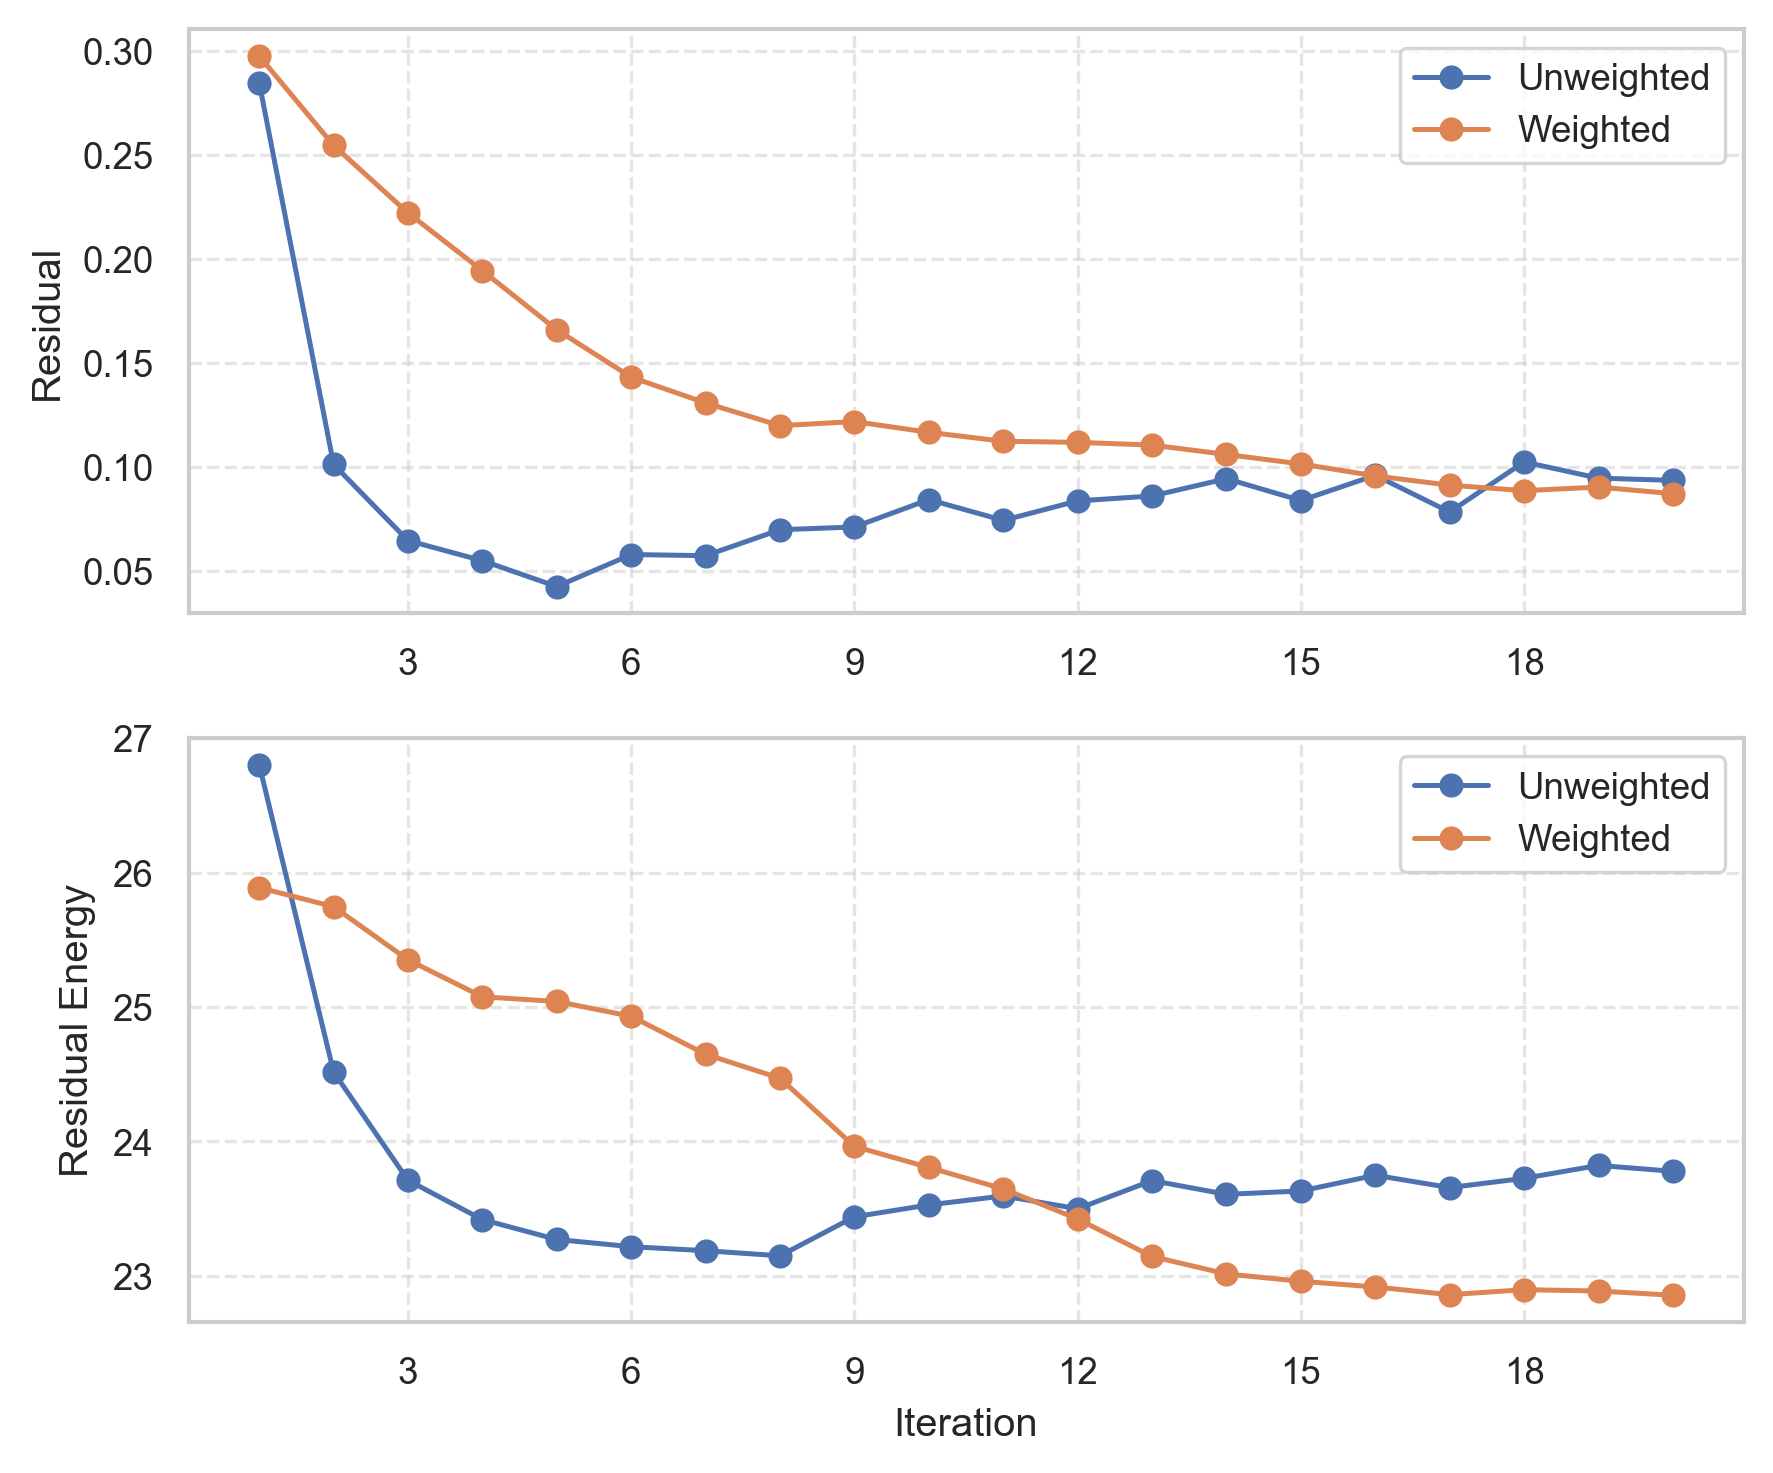

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 1. 读取两个CSV文件
df_plain = pd.read_csv("./alignment_plain.csv")
df_weighted = pd.read_csv("./alignment_weighted.csv")

# 保证 iter 列是整数
df_plain["iter"] = df_plain["iter"].astype(int)
df_weighted["iter"] = df_weighted["iter"].astype(int)

plt.figure(figsize=(6,5), dpi=300)

# --- Residual ---
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df_plain["iter"], df_plain["residual"], label="Unweighted", marker='o')
ax1.plot(df_weighted["iter"], df_weighted["residual"], label="Weighted", marker='o')
ax1.set_ylabel("Residual")
ax1.legend()
ax1.grid(linestyle='--', alpha=0.5)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# --- Energy ---
ax2 = plt.subplot(2, 1, 2)
ax2.plot(df_plain["iter"], df_plain["energy"], label="Unweighted", marker='o')
ax2.plot(df_weighted["iter"], df_weighted["energy"], label="Weighted", marker='o')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Residual Energy")
ax2.legend()
ax2.grid(linestyle='--', alpha=0.5)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


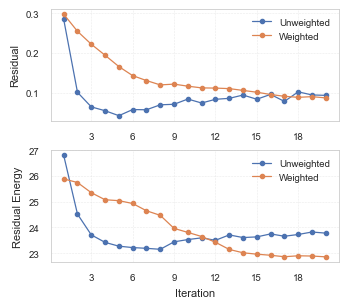

In [7]:
# === PDF export version of alignment convergence plot ===
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

# --- Font and figure defaults for IEEE-style output ---
mpl.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.linewidth": 0.6,
    "grid.linewidth": 0.4,
    "grid.alpha": 0.4,
    "pdf.fonttype": 42,   # keep text as text, not outlines
    "ps.fonttype": 42
})

# --- Load data ---
df_plain = pd.read_csv("./alignment_plain.csv")
df_weighted = pd.read_csv("./alignment_weighted.csv")

df_plain["iter"] = df_plain["iter"].astype(int)
df_weighted["iter"] = df_weighted["iter"].astype(int)

# --- Create figure ---
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(3.4, 3.0), sharex=False
)

# --- Plot 1: Residual ---
ax1.plot(df_plain["iter"], df_plain["residual"], label="Unweighted", marker='o', ms=3, lw=0.9)
ax1.plot(df_weighted["iter"], df_weighted["residual"], label="Weighted", marker='o', ms=3, lw=0.9)
ax1.set_ylabel("Residual")
ax1.legend(frameon=False)
ax1.grid(linestyle='--', alpha=0.4)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# --- Plot 2: Residual Energy ---
ax2.plot(df_plain["iter"], df_plain["energy"], label="Unweighted", marker='o', ms=3, lw=0.9)
ax2.plot(df_weighted["iter"], df_weighted["energy"], label="Weighted", marker='o', ms=3, lw=0.9)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Residual Energy")
ax2.legend(frameon=False)
ax2.grid(linestyle='--', alpha=0.4)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout(pad=0.5)
plt.savefig("alignment_convergence.pdf", format="pdf", bbox_inches="tight")
plt.show()


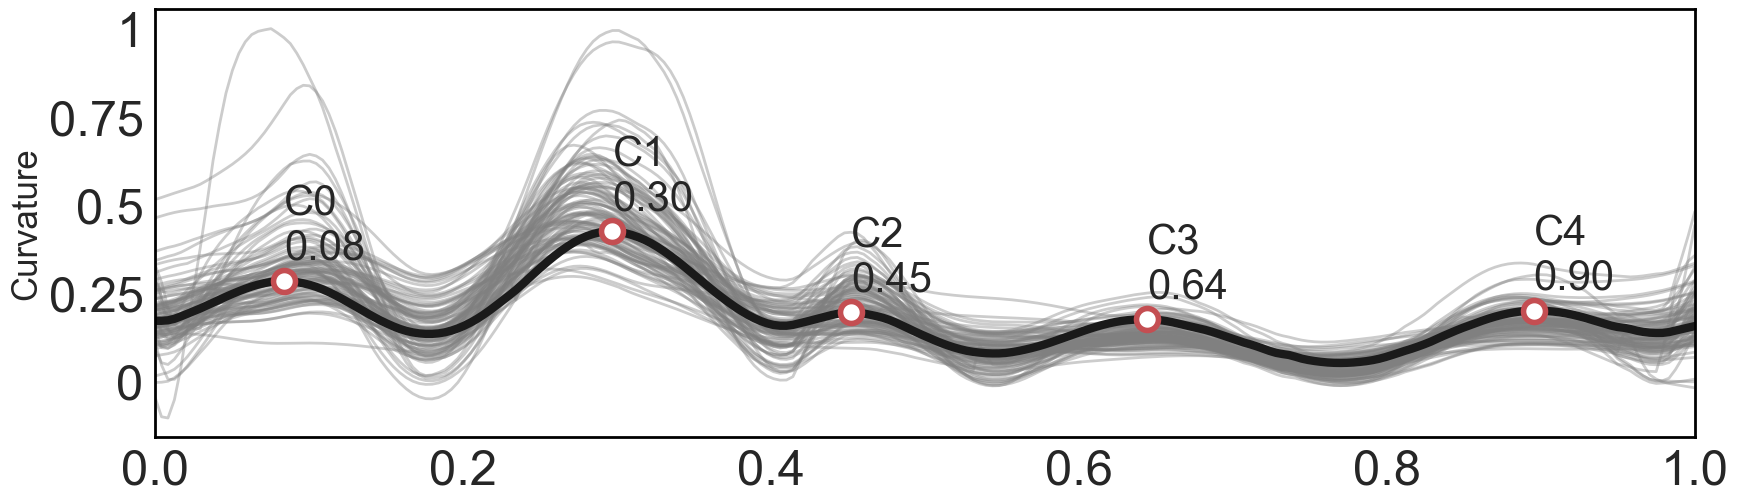

In [8]:
import seaborn as sns
from scipy.signal import find_peaks

sns.set(style="whitegrid", context="paper", font_scale=4)

# 计算去权重后的平均曲线
# mean_curve = obj_weighted.fmean / W.mean(axis=1)
mean_curve = obj_weighted.fmean

# 寻找峰值点
peaks, _ = find_peaks(
    mean_curve,
    prominence=(np.max(mean_curve) - np.min(mean_curve)) * 0.08,  # 自适应prominence
    distance=TARGET_N // 10                                     # 控制峰值间距（25点）
)

# 将峰值按 x 坐标排序（从左到右）
sorted_peaks = peaks[np.argsort(time[peaks])]

# 可视化
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)

# 所有对齐曲线
for i in range(f.shape[1]):
    ax.plot(time, f_weighted_unwrapped[:, i], alpha=0.4,lw=2, color='gray')

# 平均曲线
ax.plot(time, mean_curve, label='Weighted Mean (deweighted)', lw=6, c='k')

# 标注峰值
ax.scatter(time[sorted_peaks], mean_curve[sorted_peaks],
           color='white', edgecolors='r', linewidths=4,
           s=250, zorder=10, label='Peaks')

# 添加标注文字 C0 ~ Cn 和对应高度
for i, idx in enumerate(sorted_peaks):
    peak_x = time[idx]
    peak_y = mean_curve[idx]
    ax.annotate(f"C{i}\n{peak_x:.2f}", xy=(peak_x, peak_y),
                xytext=(0, 10), textcoords='offset points',
                ha='left', va='bottom', fontsize=30,
                arrowprops=dict(arrowstyle='-', lw=1))

# 标签和网格
ax.set_ylabel("Curvature", fontsize=25)
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels(["0", "0.25", "0.5", "0.75", "1"])
plt.grid(False)
plt.tight_layout()
# plt.legend()
for spine in ax.spines.values():
    spine.set_color("black")
    spine.set_linewidth(2)  # 可选：加粗边框

ax.set_xlim(time.min(), time.max())
plt.show()


In [9]:


sns.set(style="white", context="notebook", font_scale=1.2)

# # ------------------------------------------------------------
# # === Part 1: Time Shifts at Peaks (Blue Theme) ===
# # ------------------------------------------------------------

# # 1️⃣ 计算所有样本在mean曲线的C0~Cn处的时间shift
# gammas = obj_weighted.gam.T   # shape (n_samples, len(time))
# peak_times = time[sorted_peaks]   # mean曲线的峰值位置

# n_samples = gammas.shape[0]
# n_peaks = len(peak_times)
# shifts = np.zeros((n_samples, n_peaks))

# # # ✅ 关键改动：C1位置
# # c1_time = peak_times[1]

# # for i in range(n_samples):
# #     f_gamma = interp1d(time, gammas[i, :], kind='linear', bounds_error=False, fill_value="extrapolate")
    
# #     # γ_i 在所有 peaks 上的值
# #     gamma_peaks = f_gamma(peak_times)
    
# #     # γ_i 在C1处的值
# #     gamma_c1 = f_gamma(c1_time)
    
# #     # 对齐：C1处位移为0
# #     shifts[i, :] = (gamma_peaks - gamma_c1) - (peak_times - c1_time)

# # ✅ 新基准：所有峰的平均位置（中点）
# mid_time = np.mean(peak_times)

# for i in range(n_samples):
#     f_gamma = interp1d(time, gammas[i, :], kind='linear', bounds_error=False, fill_value="extrapolate")

#     gamma_peaks = f_gamma(peak_times)     # 每个样本在每个峰的 gamma 值
#     gamma_mid = f_gamma(mid_time)         # 在中点处的 gamma 值

#     # 每个样本的相对偏移量（相对于 mid_time）
#     # shifts[i, :] = (gamma_peaks - gamma_mid) - (peak_times - mid_time)
#     shifts[i, :] = gamma_peaks - peak_times

# # ------------------------------------------------------------
# # 2️⃣ 整理为 DataFrame
# shift_df = pd.DataFrame(shifts, columns=[f'C{i}' for i in range(n_peaks)])
# # shift_df = shift_df.drop(columns=[f'C1'])
# # ------------------------------------------------------------
# # 3️⃣ 统一颜色和绘图函数
# blue_color = 'lightskyblue'

# def diag_hist_blue(x, **kwargs):
#     ax = plt.gca()
#     sns.histplot(x, bins=20, color=blue_color, edgecolor='black', ax=ax)

# def offdiag_scatter_with_r_blue(x, y, **kwargs):
#     ax = plt.gca()
#     ax.scatter(x, y, alpha=0.4, color=blue_color, edgecolor='k')
#     r = np.corrcoef(x, y)[0, 1]
#     ax.annotate(f"r={r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
#                 ha='left', va='center', fontsize=12, fontweight='bold', color='black')

# # ------------------------------------------------------------
# # 4️⃣ 画 PairGrid
# g = sns.PairGrid(shift_df, corner=False)
# g.map_diag(diag_hist_blue)
# g.map_offdiag(offdiag_scatter_with_r_blue)

# # plt.suptitle('Pairwise Relationships of Time Shifts at Peaks (C1-Aligned)', y=1.02)
# plt.show()

# # ------------------------------------------------------------
# # === Part 2: Curvature Values at Peaks (Red Theme) ===
# # ------------------------------------------------------------

# print(f"f_weighted_unwrapped shape: {f_weighted_unwrapped.shape}")
# print(f"Number of samples: {f_weighted_unwrapped.shape[1]}")
# print(f"Number of peaks: {len(peak_times)}")

# from scipy.interpolate import interp1d
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style="white", context="notebook", font_scale=1.2)

# # === 输入变量假定已有 ===
# # time: 1D numpy array
# # peak_times: 1D array of selected peak locations on mean curve
# # f_weighted_unwrapped: shape (len(time), n_samples)
# # mean_curve: shape (len(time),), already defined

# # 1️⃣ 计算每个样本在 peak_times 上的曲率值，并归一化为相对于 mean_curve 的比值
# n_peaks = len(peak_times)
# n_samples = f_weighted_unwrapped.shape[1]
# values_at_peaks = np.zeros((n_samples, n_peaks))

# # 插值 mean 曲线，在 peak_times 上的基准值
# f_mean_interp = interp1d(time, mean_curve, kind='linear', bounds_error=False, fill_value="extrapolate")
# mean_values_at_peaks = f_mean_interp(peak_times)

# # 防止除以 0（数值稳定性）
# epsilon = 1e-8
# mean_values_at_peaks = mean_values_at_peaks + epsilon

# # 每个样本在这些点的曲率 / mean 曲线对应位置的曲率
# for i in range(n_samples):
#     f_interp = interp1d(time, f_weighted_unwrapped[:, i], kind='linear', bounds_error=False, fill_value="extrapolate")
#     values_at_peaks[i, :] = f_interp(peak_times)

# value_ratios = values_at_peaks / mean_values_at_peaks

# value_df = pd.DataFrame(value_ratios, columns=[f'C{i}' for i in range(n_peaks)])
# print("\nRatio to mean_curve at peaks:")
# print(value_df.head())

# # 2️⃣ 绘图颜色和函数
# red_color = 'lightcoral'

# def diag_hist_red(x, **kwargs):
#     ax = plt.gca()
#     sns.histplot(x, bins=20, color=red_color, edgecolor='black', ax=ax)

# def offdiag_scatter_with_r_red(x, y, **kwargs):
#     ax = plt.gca()
#     ax.scatter(x, y, alpha=0.4, color=red_color, edgecolor='k')
#     r = np.corrcoef(x, y)[0, 1]
#     ax.annotate(f"r={r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
#                 ha='left', va='center', fontsize=12, fontweight='bold', color='black')

# # 3️⃣ PairGrid 绘图
# g = sns.PairGrid(value_df, corner=False)
# g.map_diag(diag_hist_red)
# g.map_offdiag(offdiag_scatter_with_r_red)

# # plt.suptitle('Pairwise Relationships of Curvature Ratio at Peaks (Red Theme)', y=1.02)
# plt.show()


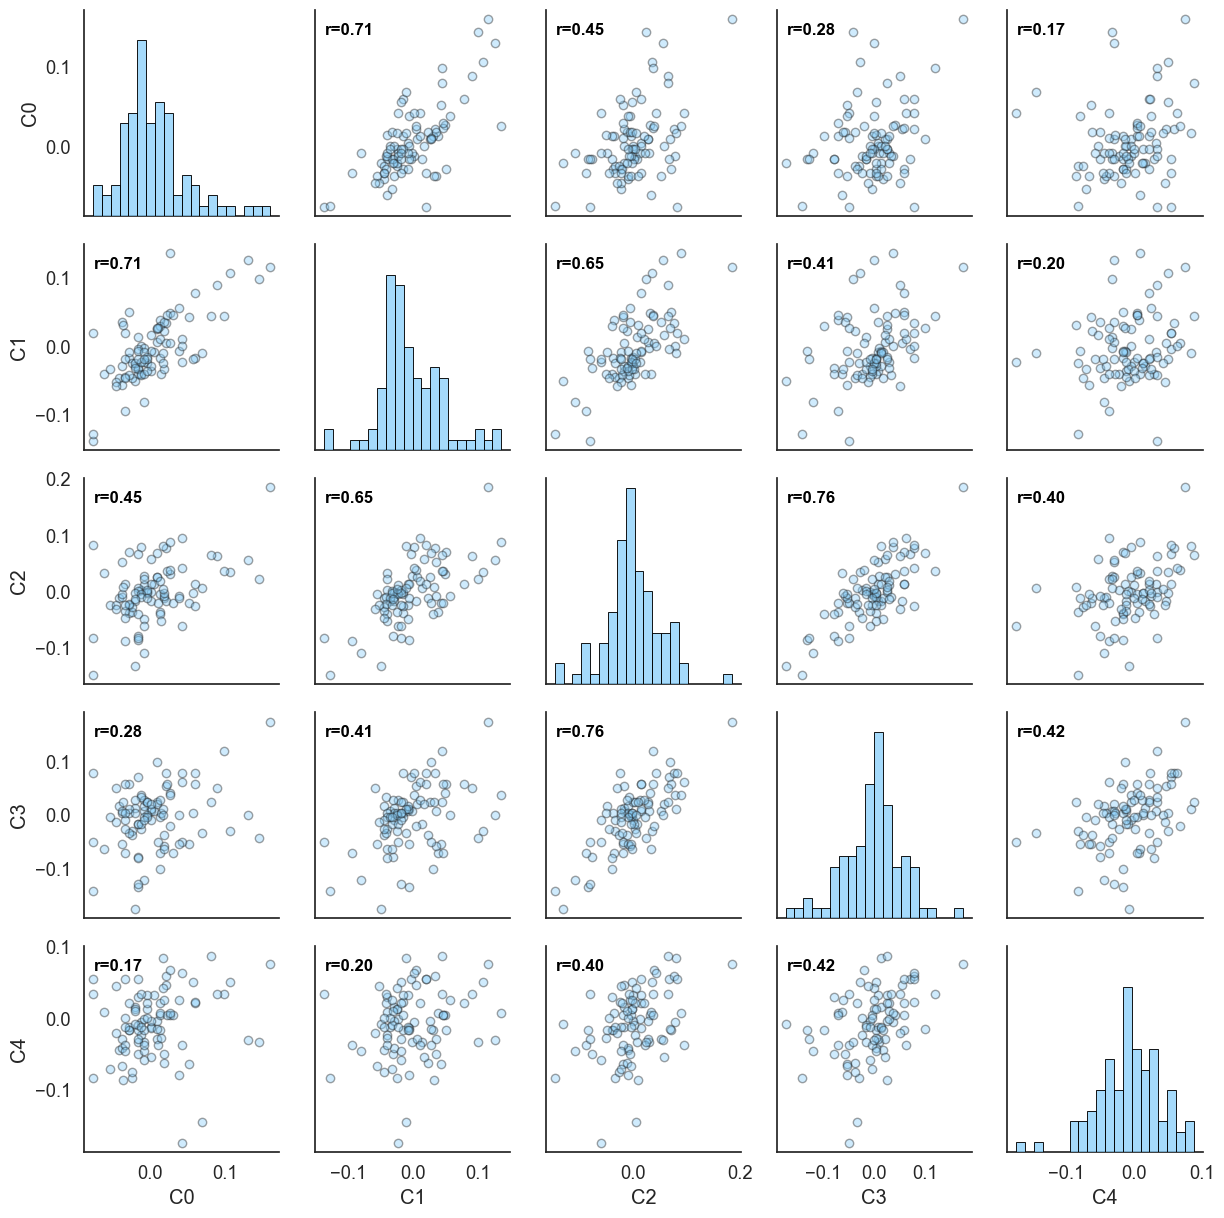

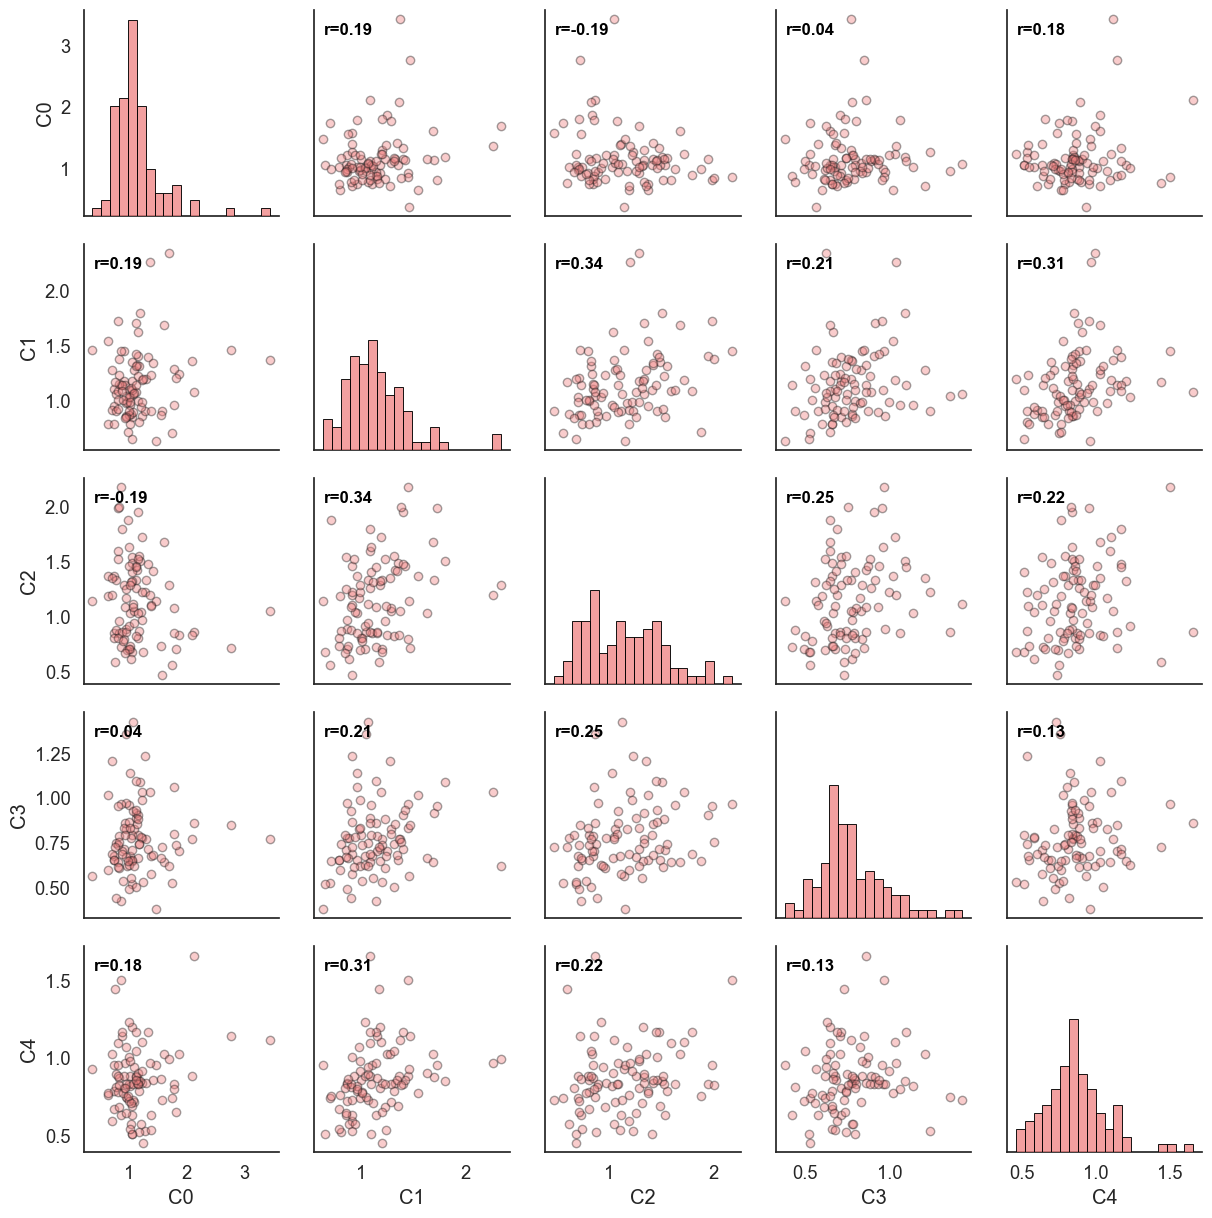

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

sns.set(style="white", context="notebook", font_scale=1.2)


def compute_and_plot_pairwise_matrix(
    data_matrix,         # shape: (len(time), n_samples)
    reference_curve,     # shape: (len(time),)
    time,                # time axis
    peak_times,          # peak locations on the mean curve
    method="difference", # "difference" or "ratio"
    color="skyblue",     # color theme
    title=None
):
    """
    对每个样本在 peak_times 上插值并与参考曲线对比，绘制 pairwise 关系图。

    Parameters:
        data_matrix: shape (len(time), n_samples)
        reference_curve: 1D array of same length as time
        time: 1D array
        peak_times: 1D array
        method: "difference" or "ratio"
        color: matplotlib color string
        title: optional plot title
    """
    n_samples = data_matrix.shape[1]
    n_peaks = len(peak_times)
    values_at_peaks = np.zeros((n_samples, n_peaks))

    # 插值 reference 曲线
    ref_interp = interp1d(time, reference_curve, kind='linear', bounds_error=False, fill_value="extrapolate")
    ref_values_at_peaks = ref_interp(peak_times)

    if method == "ratio":
        epsilon = 1e-8
        ref_values_at_peaks = ref_values_at_peaks + epsilon

    # 插值每个样本
    for i in range(n_samples):
        f_interp = interp1d(time, data_matrix[:, i], kind='linear', bounds_error=False, fill_value="extrapolate")
        values_at_peaks[i, :] = f_interp(peak_times)

    # 差值或比值
    if method == "difference":
        comparison_matrix = values_at_peaks - ref_values_at_peaks
    elif method == "ratio":
        comparison_matrix = values_at_peaks / ref_values_at_peaks
    else:
        raise ValueError("Invalid method. Use 'difference' or 'ratio'.")

    # 构建 DataFrame
    df = pd.DataFrame(comparison_matrix, columns=[f'C{i}' for i in range(n_peaks)])

    # 绘图函数定义
    def diag_hist(x, **kwargs):
        ax = plt.gca()
        sns.histplot(x, bins=20, color=color, edgecolor='black', ax=ax)

    def offdiag_scatter_with_r(x, y, **kwargs):
        ax = plt.gca()
        ax.scatter(x, y, alpha=0.4, color=color, edgecolor='k')
        r = np.corrcoef(x, y)[0, 1]
        ax.annotate(f"r={r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
                    ha='left', va='center', fontsize=12, fontweight='bold', color='black')

    # PairGrid
    g = sns.PairGrid(df, corner=False)
    g.map_diag(diag_hist)
    g.map_offdiag(offdiag_scatter_with_r)

    if title:
        plt.suptitle(title, y=1.02)
    plt.show()



peak_times = time[sorted_peaks]   # mean曲线的峰值位置


gammas = obj_weighted.gam.T  # shape: (n_samples, len(time))
gammas = gammas.T            # transpose to (len(time), n_samples)
reference_gamma = time       # gamma 应该与 time 对比

compute_and_plot_pairwise_matrix(
    data_matrix=gammas,
    reference_curve=reference_gamma,
    time=time,
    peak_times=peak_times,
    method="difference",     # 计算时间偏移量
    color="lightskyblue",
    # title="Pairwise Time Shifts at Peaks"
)


compute_and_plot_pairwise_matrix(
    data_matrix=f_weighted_unwrapped,
    reference_curve=mean_curve,
    time=time,
    peak_times=peak_times,
    method="ratio",          # 计算值相对 mean 的比值
    color="lightcoral",
    # title="Pairwise Curvature Ratios at Peaks"
)


In [11]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from matplotlib.ticker import MaxNLocator

# === IEEE-friendly 全局参数 ===
IEEE_SINGLE_COL_W_IN = 3.45  # 单栏宽度
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "STIX"],
    "mathtext.fontset": "stix",
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})
sns.set(style="white", context="paper", font_scale=1.0)


def compute_and_plot_pairwise_matrix(
    data_matrix,         # shape: (len(time), n_samples)
    reference_curve,     # shape: (len(time),)
    time,                # 1D
    peak_times,          # 1D
    method="difference", # "difference" or "ratio"
    color="skyblue",
    title=None,
    outfile=None,        # 推荐传 .pdf 路径
    width_in=IEEE_SINGLE_COL_W_IN,
    height_in=None,
):
    n_samples = data_matrix.shape[1]
    n_peaks = len(peak_times)

    values_at_peaks = np.zeros((n_samples, n_peaks))
    ref_interp = interp1d(time, reference_curve, kind='linear',
                          bounds_error=False, fill_value="extrapolate")
    ref_values_at_peaks = ref_interp(peak_times)

    if method == "ratio":
        epsilon = 1e-8
        ref_values_at_peaks = ref_values_at_peaks + epsilon

    for i in range(n_samples):
        f_interp = interp1d(time, data_matrix[:, i], kind='linear',
                            bounds_error=False, fill_value="extrapolate")
        values_at_peaks[i, :] = f_interp(peak_times)

    if method == "difference":
        comparison_matrix = values_at_peaks - ref_values_at_peaks
    elif method == "ratio":
        comparison_matrix = values_at_peaks / ref_values_at_peaks
    else:
        raise ValueError("Invalid method. Use 'difference' or 'ratio'.")

    df = pd.DataFrame(comparison_matrix,
                      columns=[f'C{i}' for i in range(n_peaks)])

    # === 绘图 ===
    def diag_hist(x, **kwargs):
        ax = plt.gca()
        sns.histplot(x, bins=20, color=color,
                     edgecolor='black', ax=ax, linewidth=0.5)

    def offdiag_scatter_with_r(x, y, **kwargs):
        ax = plt.gca()
        ax.scatter(x, y, alpha=0.5, s=10, color=color,
                   edgecolors='k', linewidths=0.3)
        r = np.corrcoef(x, y)[0, 1]
        ax.annotate(f"r={r:.2f}", xy=(0.04, 0.92),
                    xycoords='axes fraction', ha='left',
                    va='center', fontsize=8,
                    fontweight='bold', color='black')

    g = sns.PairGrid(df, corner=False)
    g.map_diag(diag_hist)
    g.map_offdiag(offdiag_scatter_with_r)

    # === 整理刻度与标签 ===
    for i, ax_row in enumerate(g.axes):
        for j, ax in enumerate(ax_row):
            if ax is not None:
                ax.grid(True, linewidth=0.3, alpha=0.3)
                ax.tick_params(length=3, width=0.6)
                ax.xaxis.set_major_locator(
                    MaxNLocator(nbins=4, prune="both"))
                ax.yaxis.set_major_locator(
                    MaxNLocator(nbins=4, prune="both"))
                # 去掉内部子图的标签
                if i < n_peaks - 1:  # 非底行
                    ax.set_xlabel("")
                    ax.set_xticklabels([])
                if j > 0:  # 非第一列
                    ax.set_ylabel("")
                    ax.set_yticklabels([])

    # 尺寸
    if height_in is None:
        per_cell = 0.9
        height_in = max(2.6, min(10.0, per_cell * n_peaks))
    g.fig.set_size_inches(width_in, height_in)

    if title:
        g.fig.suptitle(title, y=0.995, fontsize=9)

    g.fig.tight_layout(pad=0.6)
    if outfile:
        g.fig.savefig(outfile, bbox_inches="tight")
        plt.close(g.fig)
    else:
        plt.show()


# === 调用示例 ===

# 时间偏移
compute_and_plot_pairwise_matrix(
    data_matrix=gammas,
    reference_curve=reference_gamma,
    time=time,
    peak_times=peak_times,
    method="difference",
    color="lightskyblue",
    outfile="img/shift_pairwise.pdf",
)

# 曲率比值
compute_and_plot_pairwise_matrix(
    data_matrix=f_weighted_unwrapped,
    reference_curve=mean_curve,
    time=time,
    peak_times=peak_times,
    method="ratio",
    color="lightcoral",
    outfile="img/intensity_pairwise.pdf",
)


In [12]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.signal import find_peaks
from matplotlib import cm
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from AngioMorphPCA.make_figures import set_x_ticks_normalized
import fdasrsf as fs
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage import measure
import vtk
import pandas as pd

from scipy.ndimage import gaussian_filter
sns.set_context('notebook', font_scale=1.2)
from scipy.integrate import simps


def preprocess_open_curve(curve, target_k=100):
    """
    对3D开曲线进行标准化处理：
    - 起点对齐
    - 重采样为 target_k+1 个点（以便后续删去起点）
    - 缩放为单位弧长
    - 去除首点（避免 SRVMetric 奇异）

    返回：
    - processed_curve: 长度为1的统一曲线 (target_k, 3)，不含首点
    - original_length: 原始长度（用于逆缩放）
    """
    # 起点平移
    curve = curve - curve[0]

    # 原始参数化（基于弧长）
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumlen = np.concatenate([[0], np.cumsum(seg_lengths)])
    t_orig = cumlen / cumlen[-1]
    original_length = cumlen[-1]

    # 重采样为 target_k+1 个点
    t_target = np.linspace(0, 1, target_k + 1)
    interp = interp1d(t_orig, curve, axis=0, kind='linear')
    resampled = interp(t_target)

    # 缩放为单位弧长
    resampled /= original_length

    # 删除首点（确保满足 DiscreteCurvesStartingAtOrigin 要求）
    processed_curve = resampled[1:]

    return processed_curve, original_length


tPCA_N_COMPONENTS = 8

k_sampling_points = TARGET_N # TARGET_N=240
# curve_cs = coords_array.copy()
curve_cs = []
for coords in coords_array:
    # 对每条曲线进行预处理
    preprocessed_curve, preprocessed_curve_length = preprocess_open_curve(coords, target_k=k_sampling_points)
    curve_cs.append(preprocessed_curve)
curve_cs = np.array(curve_cs)
print (curve_cs.shape)


(91, 240, 3)


c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


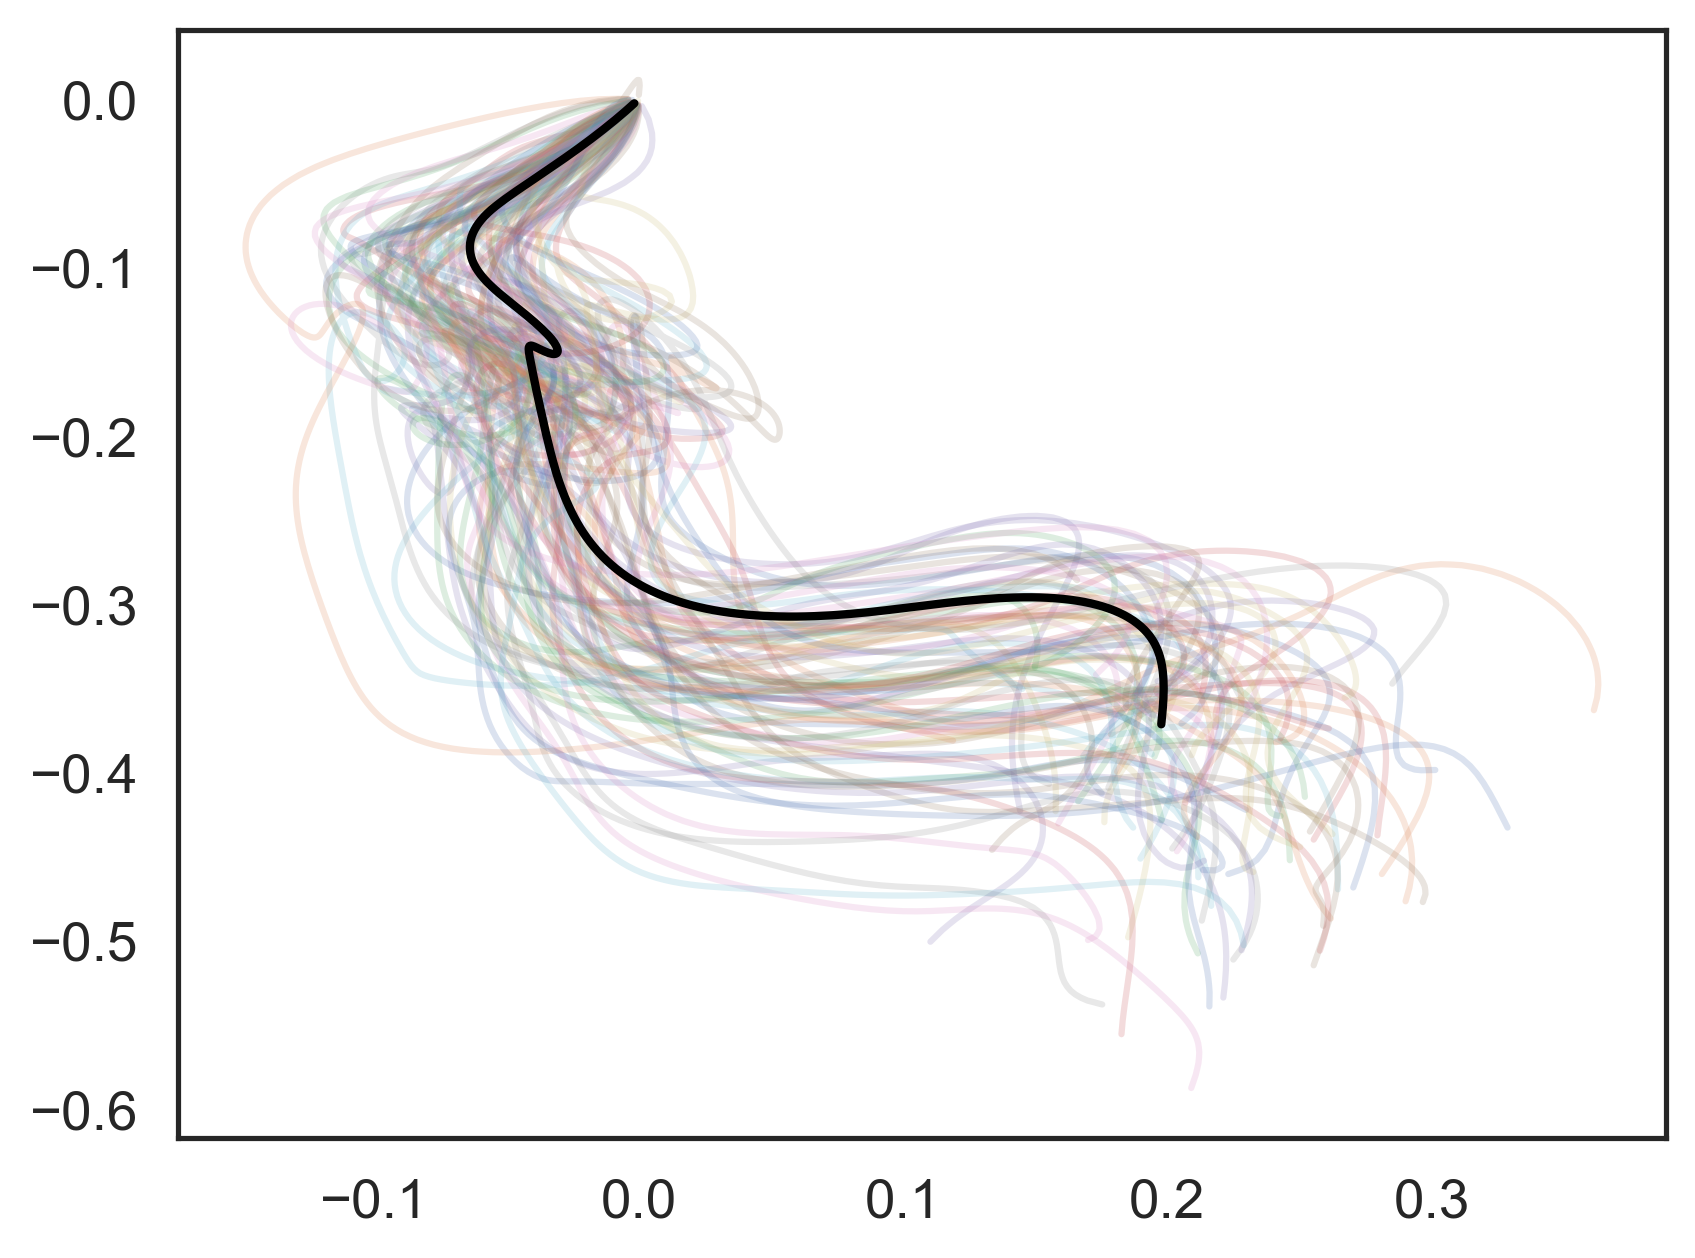

In [13]:
curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points+1, equip=False
)
curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)
mean_estimate = mean.estimate_

for i in range(len(curve_cs)):
    plt.plot(curve_cs[i][:, 0], curve_cs[i][:, 1],alpha=0.2)
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], color='black', linewidth=2, label='Frechet Mean')
plt.show()

tPCA_N_COMPONENTS = 16
tangent_base = mean.estimate_

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_cs, base_point=tangent_base)
tangent_projected_data = tpca.transform(curve_cs)

In [14]:
print (tpca.explained_variance_)

[0.44654528 0.37268467 0.24390672 0.06284089 0.04124155 0.02884757
 0.02640599 0.01987138 0.01198209 0.01039135 0.006354   0.0059358
 0.00528233 0.00381531 0.00354005 0.00252773]


C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\1028532553.py:20: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\1028532553.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels_simple, rotation=45, ha="right")


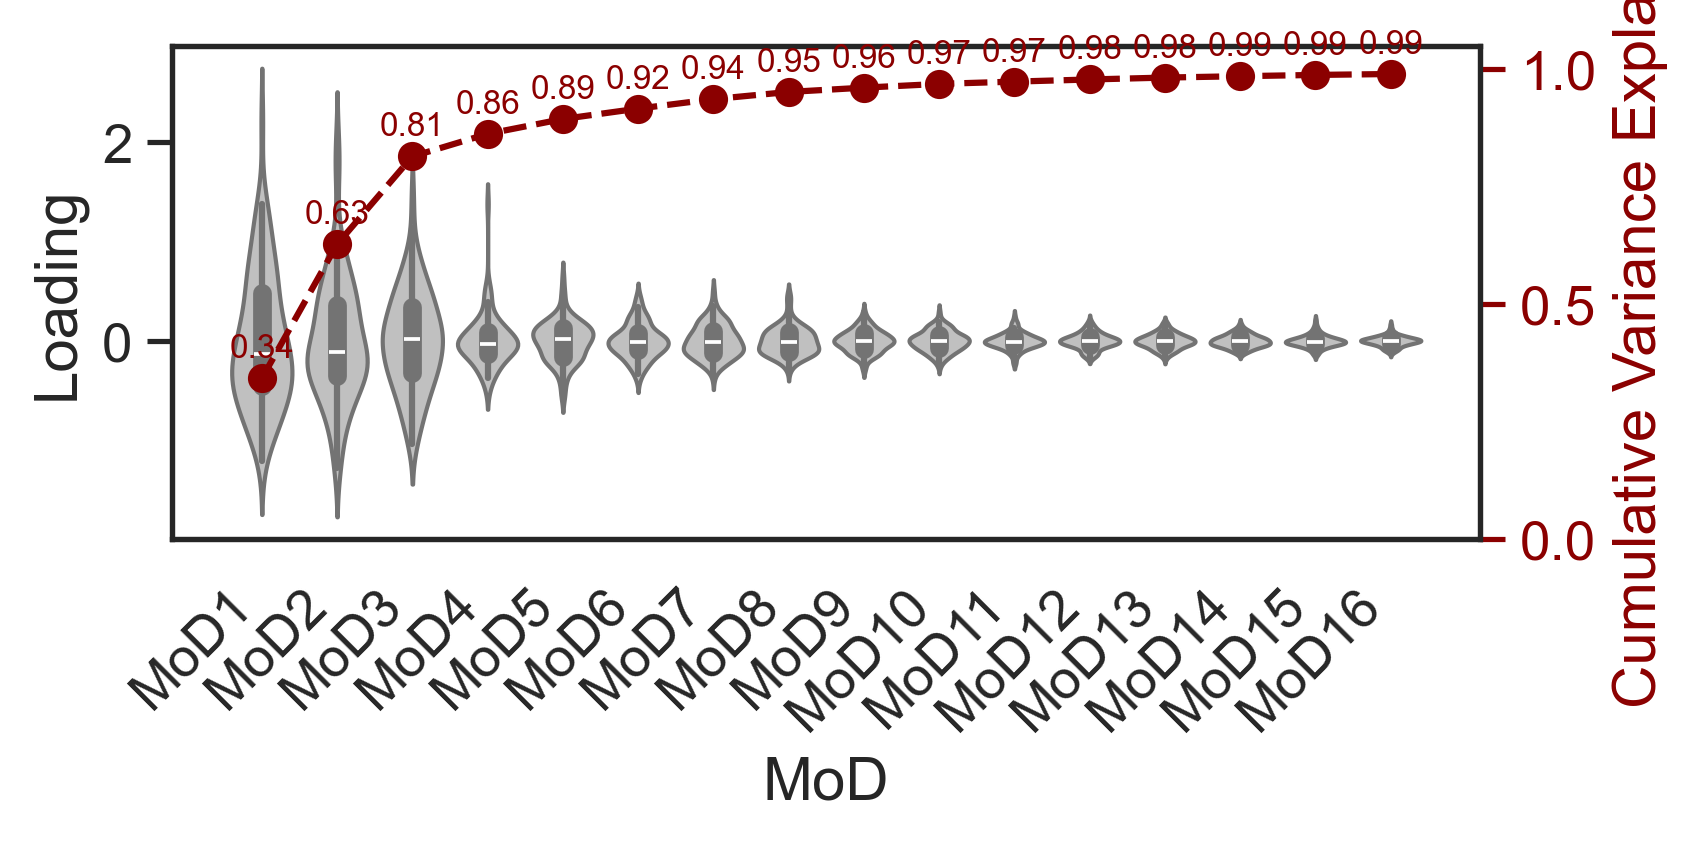

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 预先准备
explained_variance_ratio = tpca.explained_variance_ratio_
cumulative_ratio = np.cumsum(explained_variance_ratio)
labels_simple = [f"MoD{i+1}" for i in range(len(explained_variance_ratio))]

# 构建DataFrame以便使用seaborn绘图
n_components = tangent_projected_data.shape[1]
df = pd.DataFrame(tangent_projected_data, columns=[f"PC{i+1}" for i in range(n_components)])

# 转换为long-form格式以便violinplot
df_long = df.melt(var_name="MoD", value_name="Loading")

fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)

# 左侧y轴：boxplot
sns.violinplot(
    data=df_long,
    x="MoD",
    y="Loading",
    # inner="quartile",     # 在小提琴内画分位数线
    linewidth=1.0,
    cut=2,                # 不外推数据范围
    scale="width",        # 保持宽度一致
    color="silver",
    ax=ax1
)


ax1.set_xlabel("MoD")
ax1.set_ylabel("Loading")
ax1.set_xticklabels(labels_simple, rotation=45, ha="right")

# 右侧y轴：累计解释率
ax2 = ax1.twinx()
x_vals = np.arange(len(explained_variance_ratio))
ax2.plot(x_vals, cumulative_ratio, color='darkred', marker='o',
         linestyle='--', label='Cumulative Variance')
ax2.set_ylabel("Cumulative Variance Explained", color='darkred')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', colors='darkred')

# === 在点上标注数值 ===
for x, y in zip(x_vals, cumulative_ratio):
    ax2.annotate(f"{y:.2f}",
                 (x, y),
                 textcoords="offset points",
                 xytext=(0, 5),  # 向上偏移5pt
                 ha='center',
                 fontsize=8,
                 color='darkred')

# 可选：去掉多余网格
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


In [16]:
print (list(vtk_data_dict.keys()))

['BG0001_L.vtk', 'BG0001_R.vtk', 'BG0003_L.vtk', 'BG0003_R.vtk', 'BG0004_L.vtk', 'BG0004_R.vtk', 'BG0006_L.vtk', 'BG0006_R.vtk', 'BG0007_L.vtk', 'BG0007_R.vtk', 'BG0008_L.vtk', 'BG0008_R.vtk', 'BG0009_L.vtk', 'BG0009_R.vtk', 'BG0010_L.vtk', 'BG0010_R.vtk', 'BG0011_L.vtk', 'BG0011_R.vtk', 'BG0012_L.vtk', 'BG0012_R.vtk', 'BG0015_L.vtk', 'BG0015_R.vtk', 'BG0017_L.vtk', 'BG0017_R.vtk', 'BG0018_L.vtk', 'BG0018_R.vtk', 'BG0019_L.vtk', 'BG0019_R.vtk', 'BG0020_L.vtk', 'BG0020_R.vtk', 'BG0021_R.vtk', 'BG0022_L.vtk', 'BG0022_R.vtk', 'BG0099_L.vtk', 'BG0099_R.vtk', 'BH0005_L.vtk', 'BH0005_R.vtk', 'BH0006_L.vtk', 'BH0006_R.vtk', 'BH0009_L.vtk', 'BH0009_R.vtk', 'BH0010_L.vtk', 'BH0010_R.vtk', 'BH0011_L.vtk', 'BH0011_R.vtk', 'BH0013_L.vtk', 'BH0013_R.vtk', 'BH0014_L.vtk', 'BH0014_R.vtk', 'BH0016_L.vtk', 'BH0016_R.vtk', 'BH0017_L.vtk', 'BH0017_R.vtk', 'BH0018_L.vtk', 'BH0018_R.vtk', 'BH0019_L.vtk', 'BH0019_R.vtk', 'BH0020_L.vtk', 'BH0020_R.vtk', 'BH0021_L.vtk', 'BH0021_R.vtk', 'BH0022_L.vtk', 'BH0022

In [17]:
def print_structure(d, indent=0):
    pad = "  " * indent
    if isinstance(d, dict):
        print(f"{pad}dict with {len(d)} keys")
        for k, v in d.items():
            print(f"{pad}  {k}: ", end="")
            print_structure(v, indent+1)
    elif isinstance(d, (list, tuple)):
        print(f"{pad}{type(d).__name__} of len {len(d)}")
        if len(d) > 0:
            print_structure(d[0], indent+1)
    else:
        print(f"{pad}{type(d)}")

print_structure(vtk_data_dict)


dict with 91 keys
  BG0001_L.vtk:   dict with 3 keys
    point_data:     dict with 5 keys
      Curvature:       <class 'numpy.ndarray'>
      Torsion:       <class 'numpy.ndarray'>
      FrenetTangent:       <class 'numpy.ndarray'>
      FrenetNormal:       <class 'numpy.ndarray'>
      FrenetBinormal:       <class 'numpy.ndarray'>
    cell_data:     dict with 2 keys
      Length:       <class 'numpy.ndarray'>
      Tortuosity:       <class 'numpy.ndarray'>
    coords:     <class 'numpy.ndarray'>
  BG0001_R.vtk:   dict with 3 keys
    point_data:     dict with 5 keys
      Curvature:       <class 'numpy.ndarray'>
      Torsion:       <class 'numpy.ndarray'>
      FrenetTangent:       <class 'numpy.ndarray'>
      FrenetNormal:       <class 'numpy.ndarray'>
      FrenetBinormal:       <class 'numpy.ndarray'>
    cell_data:     dict with 2 keys
      Length:       <class 'numpy.ndarray'>
      Tortuosity:       <class 'numpy.ndarray'>
    coords:     <class 'numpy.ndarray'>
  BG0003_L.v

In [18]:
import plotly.express as px
import pandas as pd

# 假设 tangent_projected_data 和 vtk_data_dict 是一一对应的
keys = list(vtk_data_dict.keys())

# 从 sub-dict 里提取 Tortuosity（示例取 cell_data['Tortuosity'] 的均值）
tortuosity_vals = [
    sub["cell_data"]["Tortuosity"].mean() if "cell_data" in sub else None
    for sub in vtk_data_dict.values()
]

# 构建 DataFrame
df = pd.DataFrame({
    "Key": keys,
    "MoD1": tangent_projected_data[:, 0],
    "MoD2": tangent_projected_data[:, 1],
    "MoD3": tangent_projected_data[:, 2],
    "Tortuosity": tortuosity_vals
})

# 绘制 3D 散点图，hover 可以显示 Key 和 Tortuosity
fig = px.scatter_3d(
    df,
    x="MoD1",
    y="MoD2",
    z="MoD3",
    color="Tortuosity",  # 颜色映射到 Tortuosity
    hover_data=["Key", "Tortuosity"],
    opacity=0.7
)

fig.update_traces(
    marker=dict(size=5, line=dict(width=1, color="black"))
)

fig.update_layout(
    scene=dict(
        xaxis_title="MoD1",
        yaxis_title="MoD2",
        zaxis_title="MoD3"
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    font=dict(family="Times New Roman", size=16)
)

fig.show()


In [19]:
import numpy as np
import random
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin, SRVMetric
from geomstats.learning.frechet_mean import FrechetMean
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# 保证结果可复现
random.seed(42)

def compute_mean_curve(curves_group):
    """在 SRV 流形上计算 Frechet Mean 曲线"""
    manifold = DiscreteCurvesStartingAtOrigin(
        ambient_dim=3,
        k_sampling_points=curves_group.shape[1],
        equip=False
    )
    manifold.equip_with_metric(SRVMetric)
    mean_estimator = FrechetMean(manifold)
    mean_estimator.fit(curves_group)
    return mean_estimator.estimate_

def plot_pc_effect(pc_index, tangent_projected_data, curve_cs, n_examples=5):
    """绘制指定主成分的高低组曲线及差异主方向"""
    scores = tangent_projected_data[:, pc_index]
    threshold = np.median(scores)

    high_group = curve_cs[scores > threshold]
    low_group = curve_cs[scores <= threshold]

    # 随机抽取样例
    high_examples = high_group[np.random.choice(len(high_group), n_examples, replace=False)]
    low_examples = low_group[np.random.choice(len(low_group), n_examples, replace=False)]

    # Frechet Mean
    mean_high_curve = compute_mean_curve(high_group)
    mean_low_curve = compute_mean_curve(low_group)

    # 差异 & PCA
    diff = mean_high_curve - mean_low_curve
    pca = PCA(n_components=3)
    pca.fit(diff)
    principal_direction = pca.components_[0]

    # 箭头起点设为 mean_low_curve 中点
    center_idx = len(mean_low_curve) // 2
    arrow_start = mean_low_curve[center_idx]
    arrow_end = arrow_start + principal_direction * 0.1

    # ==== 可视化 ====
    fig = go.Figure()

    # 样例曲线
    for ex in low_examples:
        fig.add_trace(go.Scatter3d(
            x=ex[:, 0], y=ex[:, 1], z=ex[:, 2],
            mode='lines',
            line=dict(color='blue', width=1, dash='dot'),
            name='Low Example',
            showlegend=False
        ))
    for ex in high_examples:
        fig.add_trace(go.Scatter3d(
            x=ex[:, 0], y=ex[:, 1], z=ex[:, 2],
            mode='lines',
            line=dict(color='red', width=1, dash='dot'),
            name='High Example',
            showlegend=False
        ))

    # Frechet Mean 曲线
    fig.add_trace(go.Scatter3d(
        x=mean_low_curve[:, 0], y=mean_low_curve[:, 1], z=mean_low_curve[:, 2],
        mode='lines',
        name='Low Mean',
        line=dict(color='blue', width=4)
    ))
    fig.add_trace(go.Scatter3d(
        x=mean_high_curve[:, 0], y=mean_high_curve[:, 1], z=mean_high_curve[:, 2],
        mode='lines',
        name='High Mean',
        line=dict(color='red', width=4)
    ))

    # 主方向箭头
    fig.add_trace(go.Scatter3d(
        x=[arrow_start[0], arrow_end[0]],
        y=[arrow_start[1], arrow_end[1]],
        z=[arrow_start[2], arrow_end[2]],
        mode='lines+markers',
        name='Principal Direction',
        line=dict(color='black', width=6, dash='dot'),
        marker=dict(size=3, color='black')
    ))

    fig.update_layout(
        title=f'PC{pc_index+1} Effect: High vs Low Group',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=800,
        height=600
    )

    fig.show()
    return fig

# ==== 循环绘制 PC1, PC2, PC3 ====
for pc in range(3):
    plot_pc_effect(pc, tangent_projected_data, curve_cs, n_examples=5)


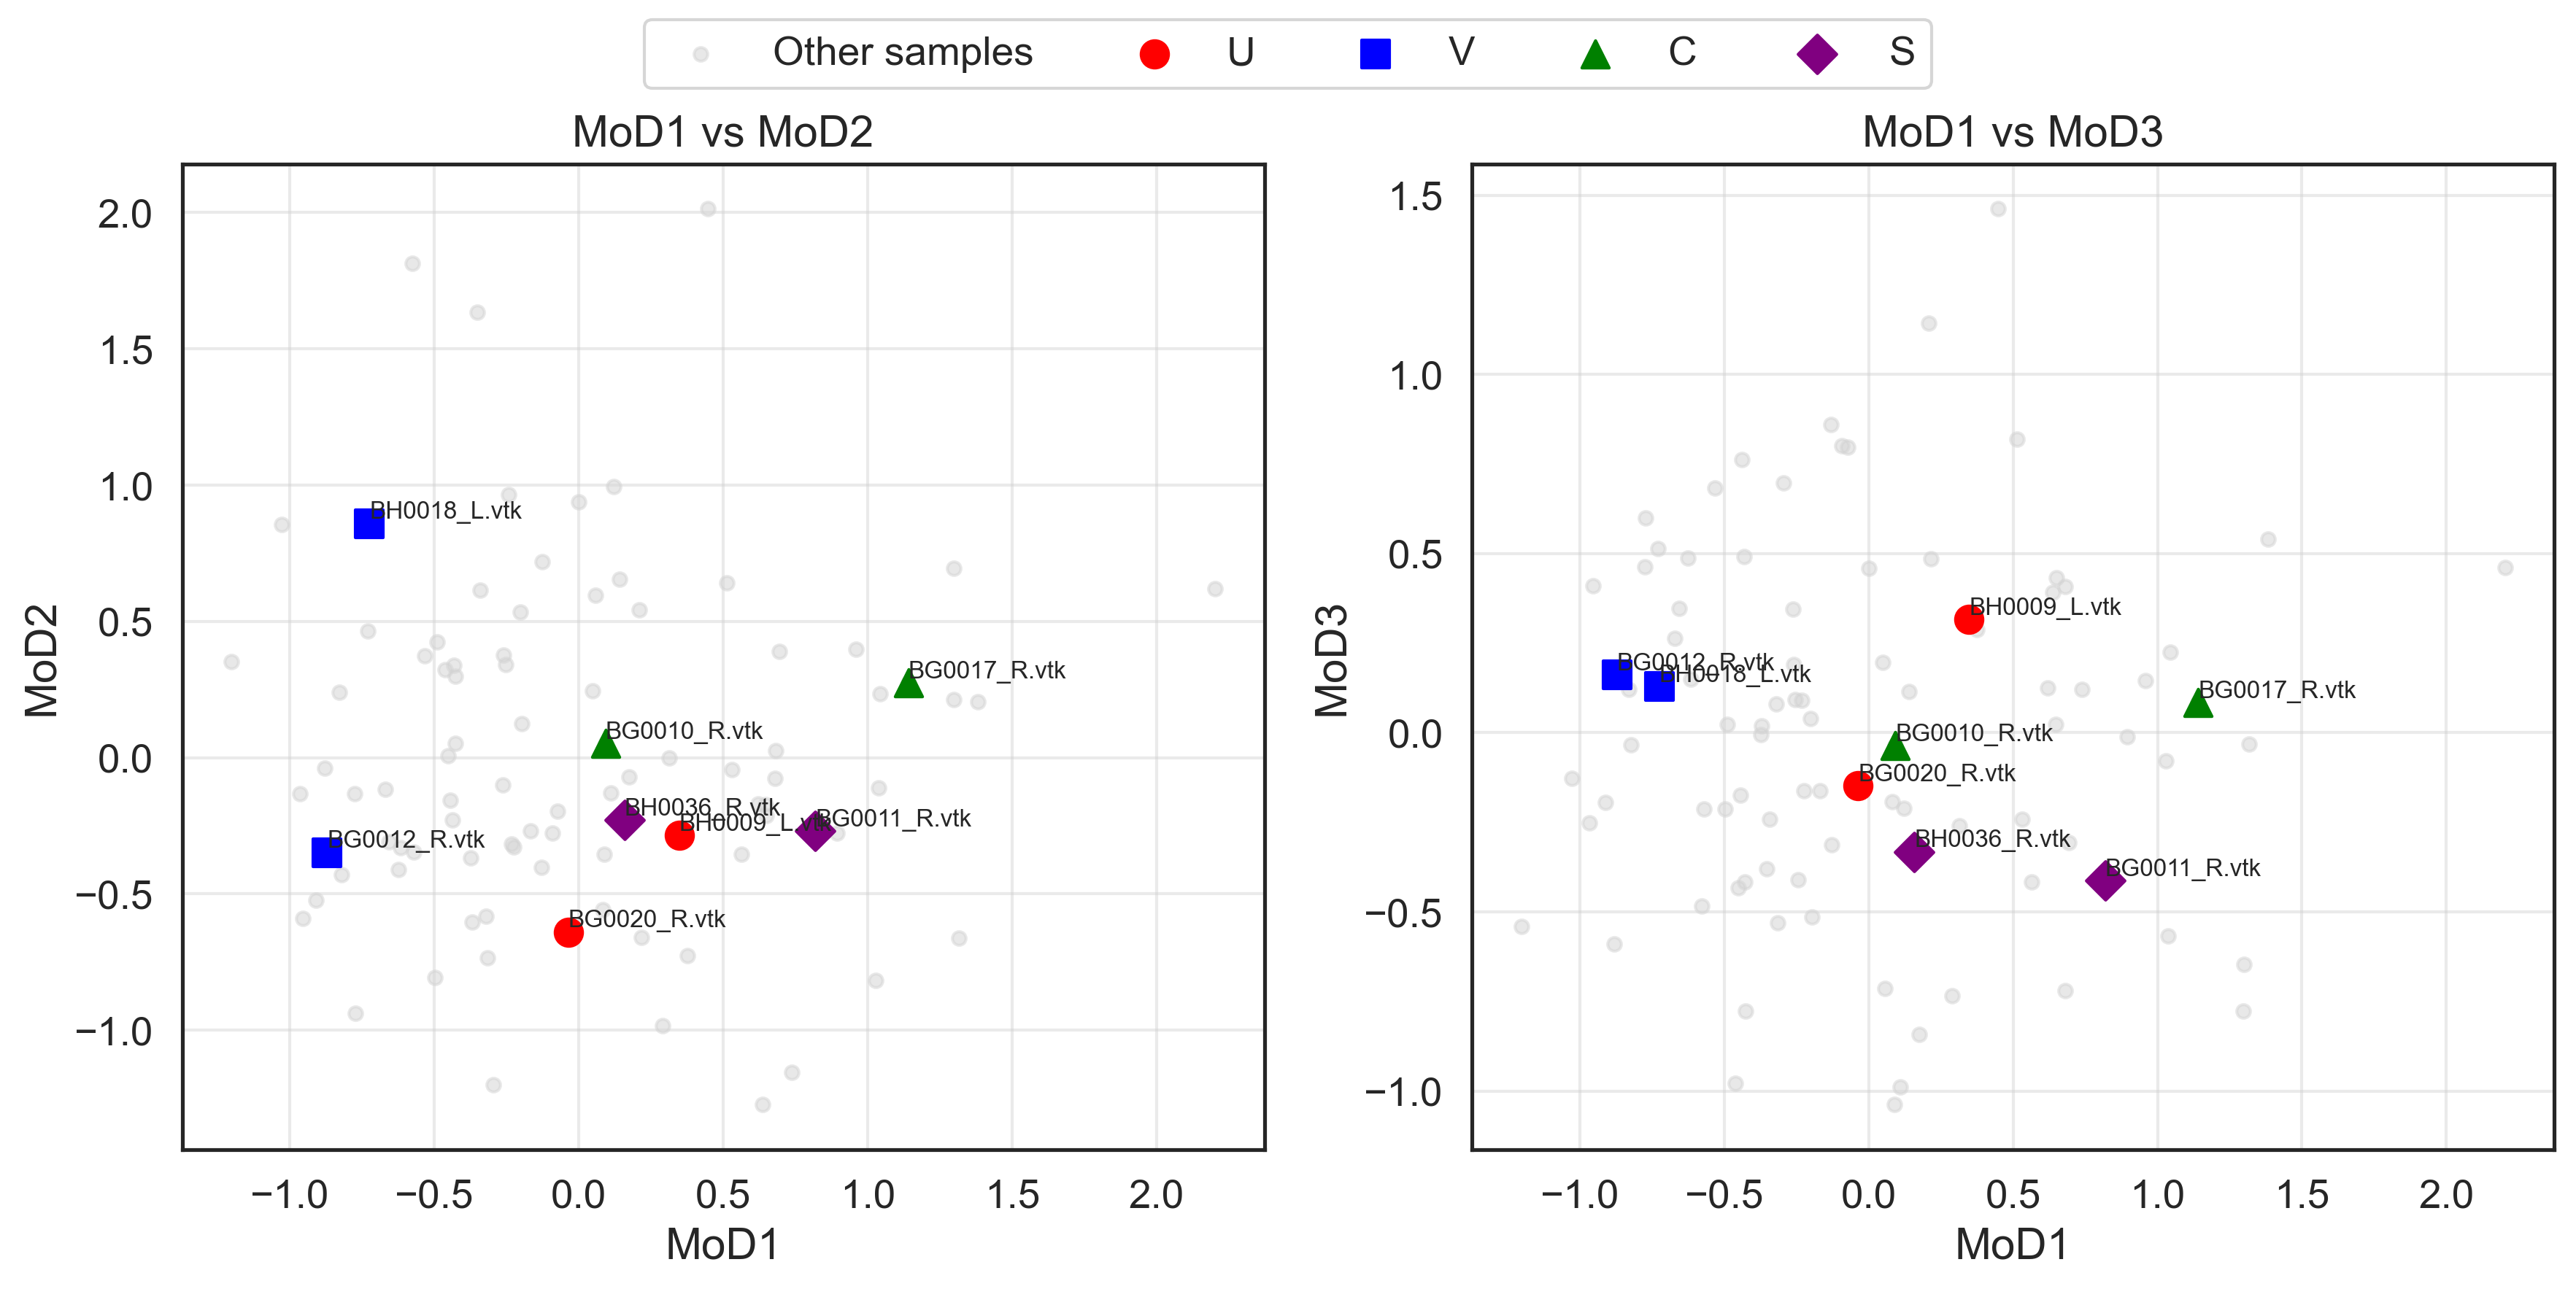

In [20]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# === 1. 高亮 BG0019_L.vtk 在散点图中 ===
keys = list(vtk_data_dict.keys())

df = pd.DataFrame({
    "Key": keys,
    "MoD1": tangent_projected_data[:, 0],
    "MoD2": tangent_projected_data[:, 1],
    "MoD3": tangent_projected_data[:, 2],
})

# target_key = "BG0020_R.vtk"

# U:BG0020_R/BH0009_L 
# V:BG0012_R/BH0018_L 
# C:BG0017_R/BH0010_R 
# S:BG0011_R/BH0036_R


# 定义四类的 key
groups = {
    "U": ["BG0020_R.vtk", "BH0009_L.vtk"],
    "V": ["BG0012_R.vtk", "BH0018_L.vtk"],
    "C": ["BG0017_R.vtk", "BG0010_R.vtk"],
    "S": ["BG0011_R.vtk", "BH0036_R.vtk"],
}

# 给每个 type 指定颜色和 marker
styles = {
    "U": dict(color="red", marker="o"),
    "V": dict(color="blue", marker="s"),
    "C": dict(color="green", marker="^"),
    "S": dict(color="purple", marker="D"),
}



fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# -------- 子图 1: MoD1 vs MoD2 --------
ax = axes[0]
ax.scatter(df["MoD1"], df["MoD2"], c="lightgray", s=20, alpha=0.5, label="Other samples")

for g, keys in groups.items():
    rows = df[df["Key"].isin(keys)]
    ax.scatter(rows["MoD1"], rows["MoD2"],
               s=80,
               label=g,
               **styles[g])
    for _, row in rows.iterrows():
        ax.text(row["MoD1"], row["MoD2"], row["Key"],
                fontsize=8, ha="left", va="bottom")

ax.set_xlabel("MoD1")
ax.set_ylabel("MoD2")
ax.set_title("MoD1 vs MoD2")
ax.grid(True)

# -------- 子图 2: MoD1 vs MoD3 --------
ax = axes[1]
ax.scatter(df["MoD1"], df["MoD3"], c="lightgray", s=20, alpha=0.5, label="Other samples")

for g, keys in groups.items():
    rows = df[df["Key"].isin(keys)]
    ax.scatter(rows["MoD1"], rows["MoD3"],
               s=80,
               label=g,
               **styles[g])
    for _, row in rows.iterrows():
        ax.text(row["MoD1"], row["MoD3"], row["Key"],
                fontsize=8, ha="left", va="bottom")

ax.set_xlabel("MoD1")
ax.set_ylabel("MoD3")
ax.set_title("MoD1 vs MoD3")
ax.grid(True)

# -------- 公共设置 --------
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5)
# plt.suptitle("Highlighted 8 samples by type", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [21]:
print (len(vtk_data_dict))

91


In [22]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import sample_colorscale
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin

# === 1) Geomstats：projection + normalization ===
k_sampling_points = 240  # 你说每条曲线就是 240x3
curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3,
    k_sampling_points=k_sampling_points,
)

aligned_dict = {}
for name, rec in vtk_data_dict.items():
    P = rec["coords"]  # shape (240, 3)
    P_proj = curves_r3.projection(P)
    P_norm = curves_r3.normalize(P_proj)
    aligned_dict[name] = P_norm

# === 2) Plotly：并排交互 3D 图 ===
# 为了区分曲线，给每条曲线取不同颜色（使用连续色带采样）
names = list(vtk_data_dict.keys())
n = len(names)
colors = sample_colorscale("Turbo", np.linspace(0, 1, n))

# fig = make_subplots(
#     rows=1, cols=2,
#     specs=[[{"type": "scene"}, {"type": "scene"}]],
#     horizontal_spacing=0.02,
#     subplot_titles=("All curves (Original)", "All curves (Projected + Normalized)")
# )

# # 初始相机（两侧保持一致）
# init_camera = dict(eye=dict(x=1.6, y=1.6, z=1.2))

# # 左：Original
# for i, name in enumerate(names):
#     P = vtk_data_dict[name]["coords"]
#     fig.add_trace(
#         go.Scatter3d(
#             x=P[:, 0], y=P[:, 1], z=P[:, 2],
#             mode="lines",
#             line=dict(width=2, color=colors[i]),
#             name=name,
#             legendgroup="orig",
#             showlegend=(i == 0),  # 只显示一条图例避免太挤
#             hovertemplate=f"{name}<br>x:%{{x:.2f}} y:%{{y:.2f}} z:%{{z:.2f}}<extra></extra>"
#         ),
#         row=1, col=1
#     )

# # 右：Projected + Normalized
# for i, name in enumerate(names):
#     Pn = aligned_dict[name]
#     fig.add_trace(
#         go.Scatter3d(
#             x=Pn[:, 0], y=Pn[:, 1], z=Pn[:, 2],
#             mode="lines",
#             line=dict(width=2, color=colors[i]),
#             name=name,
#             legendgroup="norm",
#             showlegend=False,
#             hovertemplate=f"{name} (aligned)<br>x:%{{x:.2f}} y:%{{y:.2f}} z:%{{z:.2f}}<extra></extra>"
#         ),
#         row=1, col=2
#     )

# # 轴与相机设置
# fig.update_layout(
#     height=600, width=1100,
#     margin=dict(l=0, r=0, t=50, b=0),
#     scene=dict(
#         xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False),
#         aspectmode="data", camera=init_camera
#     ),
#     scene2=dict(
#         xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False),
#         aspectmode="data", camera=init_camera
#     ),
#     legend=dict(x=0.01, y=0.99, bgcolor="rgba(255,255,255,0.6)", bordercolor="rgba(0,0,0,0.1)")
# )

# fig.show()


In [23]:
# === GPA alignment in the quotient space (rotations + reparametrizations) ===
import os
import json
import numpy as np
import geomstats.backend as gs
import plotly.graph_objects as go
from plotly.colors import sample_colorscale
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin
from geomstats.learning.frechet_mean import FrechetMean
from tqdm import tqdm
from datetime import datetime

# ----------------------------
# Config
# ----------------------------
k_sampling_points = 240         # 每条曲线是 240x3
max_iter = 10
tol = 1e-3
outdir = "aligned_results"
os.makedirs(outdir, exist_ok=True)

# ----------------------------
# Check if we already have saved results
# ----------------------------
saved_files = sorted([f for f in os.listdir(outdir) if f.startswith("aligned_curves_") and f.endswith(".json")])

if saved_files:
    # 直接读取最新的文件
    latest_file = os.path.join(outdir, saved_files[-1])
    print(f"[Load] Found existing alignment file: {latest_file}")
    with open(latest_file, "r") as f:
        saved_data = json.load(f)

    aligned_final_dict = {name: gs.array(coords) for name, coords in saved_data["aligned_curves"].items()}
    mean_curve = gs.array(saved_data["mean_curve"])
    history = saved_data["history"]

else:
    print("[Run] No saved alignment found, performing GPA alignment...")

    # ----------------------------
    # Curve manifold with quotient structure
    # ----------------------------
    M = DiscreteCurvesStartingAtOrigin(ambient_dim=3, k_sampling_points=k_sampling_points)
    M.equip_with_group_action(("rotations", "reparametrizations"))
    M.equip_with_quotient()

    # ----------------------------
    # Load curves (Projected + Normalized)
    # ----------------------------
    if "aligned_dict" in globals():
        curves0_names = list(aligned_dict.keys())
        curves0 = [gs.array(aligned_dict[name]) for name in curves0_names]
    else:
        curves0_names = list(vtk_data_dict.keys())
        curves0 = []
        for name in curves0_names:
            P = gs.array(vtk_data_dict[name]["coords"])  # (240,3)
            P_proj = M.projection(P)
            P_norm = M.normalize(P_proj)
            curves0.append(P_norm)

    n_curves = len(curves0)
    print(f"[Init] number of curves = {n_curves}; points per curve = {k_sampling_points}")

    # ----------------------------
    # GPA iterations
    # ----------------------------
    template = curves0[0]
    last_obj = np.inf
    history = []

    for it in tqdm(range(1, max_iter + 1), desc="GPA iterations", unit="iter"):
        aligned = []
        for C in tqdm(curves0, desc=f" Iter {it} align", leave=False):
            aligned.append(M.fiber_bundle.align(C, template))

        mean_est = FrechetMean(M)
        mean_est.fit(gs.array(aligned))
        new_template = mean_est.estimate_

        diff = gs.linalg.norm((new_template - template).reshape(-1))
        obj_vals = [M.metric.squared_dist(C, new_template) for C in aligned]
        obj = float(gs.mean(obj_vals))
        history.append((it, float(diff), obj))
        tqdm.write(f"[Iter {it:02d}] template-change={diff:.4e}, mean squared dist={obj:.6f}")

        if (abs(float(last_obj) - obj) < tol) and (diff < tol):
            template = new_template
            break

        template = new_template
        last_obj = obj

    aligned_final = [M.fiber_bundle.align(C, template) for C in curves0]
    aligned_final_dict = {name: gs.array(C) for name, C in zip(curves0_names, aligned_final)}
    mean_curve = gs.array(template)

    print(f"[Done] Iterations run: {len(history)}; final mean squared dist={history[-1][2]:.6f}")

    # ----------------------------
    # Save results with timestamp
    # ----------------------------
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    outfile = os.path.join(outdir, f"aligned_curves_{timestamp}.json")

    save_dict = {
        "aligned_curves": {name: C.tolist() for name, C in aligned_final_dict.items()},
        "mean_curve": mean_curve.tolist(),
        "history": history,
    }

    with open(outfile, "w") as f:
        json.dump(save_dict, f)

    print(f"[Saved] Alignment results saved to {outfile}")

# ----------------------------
# Interactive Plotly visualization
# ----------------------------
colors = sample_colorscale("Turbo", np.linspace(0, 1, len(aligned_final_dict)))
fig = go.Figure()

for i, (name, C) in enumerate(aligned_final_dict.items()):
    fig.add_trace(go.Scatter3d(
        x=C[:, 0], y=C[:, 1], z=C[:, 2],
        mode="lines",
        line=dict(width=2, color=colors[i]),
        name=name,
        legendgroup="aligned",
        showlegend=(i == 0),
        hovertemplate=f"{name}<br>x:%{{x:.2f}} y:%{{y:.2f}} z:%{{z:.2f}}<extra></extra>"
    ))

fig.add_trace(go.Scatter3d(
    x=mean_curve[:, 0], y=mean_curve[:, 1], z=mean_curve[:, 2],
    mode="lines",
    line=dict(width=6, color="black"),
    name="Template (mean)",
    hovertemplate="mean<br>x:%{x:.2f} y:%{y:.2f} z:%{z:.2f}<extra></extra>"
))

fig.update_layout(
    height=600, width=700,
    title="Aligned curves in quotient space (rotations + reparam) with mean curve",
    margin=dict(l=0, r=0, t=40, b=0),
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data",
        camera=dict(eye=dict(x=1.6, y=1.6, z=1.2))
    ),
    legend=dict(x=0.01, y=0.99, bgcolor="rgba(255,255,255,0.6)")
)

fig.show()

# === Save interactive Plotly figure as standalone HTML ===
html_path = "aligned_curves_plot.html"

fig.write_html(
    html_path,
    include_plotlyjs="inline",
    full_html=True,           # 生成完整HTML文件
    auto_open=False           # 不自动在浏览器中打开
)

print(f"[Saved] Interactive HTML figure saved to: {html_path}")



[Load] Found existing alignment file: aligned_results\aligned_curves_20251006_173937.json


[Saved] Interactive HTML figure saved to: aligned_curves_plot.html


In [24]:
import os
import json
from datetime import datetime

# === 保存对齐结果 ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = "aligned_results"
os.makedirs(outdir, exist_ok=True)

# 文件名：aligned_curves_时间戳.json
outfile = os.path.join(outdir, f"aligned_curves_{timestamp}.json")

# 把 numpy 数组转成 list 才能写入 JSON
aligned_serializable = {
    name: C.tolist() for name, C in aligned_final_dict.items()
}
mean_serializable = mean_curve.tolist()

save_dict = {
    "aligned_curves": aligned_serializable,
    "mean_curve": mean_serializable,
    "history": history,
}

with open(outfile, "w") as f:
    json.dump(save_dict, f)

print(f"[Saved] Alignment results saved to {outfile}")


[Saved] Alignment results saved to aligned_results\aligned_curves_20251205_122931.json


Number of aligned curves: 91
Shape of one curve: (239, 3)
Aligned array shape: (91, 239, 3)
Aligned array shape: (91, 239, 3)
Mean curve shape: (239, 3)
[tPCA] Explained variance ratio (first 10 PCs): [0.44729444 0.19959457 0.14486808 0.05926367 0.04087337 0.03016406
 0.01443139 0.01162295 0.01002252 0.00880953]


C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\4233598557.py:63: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.

C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\4233598557.py:69: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



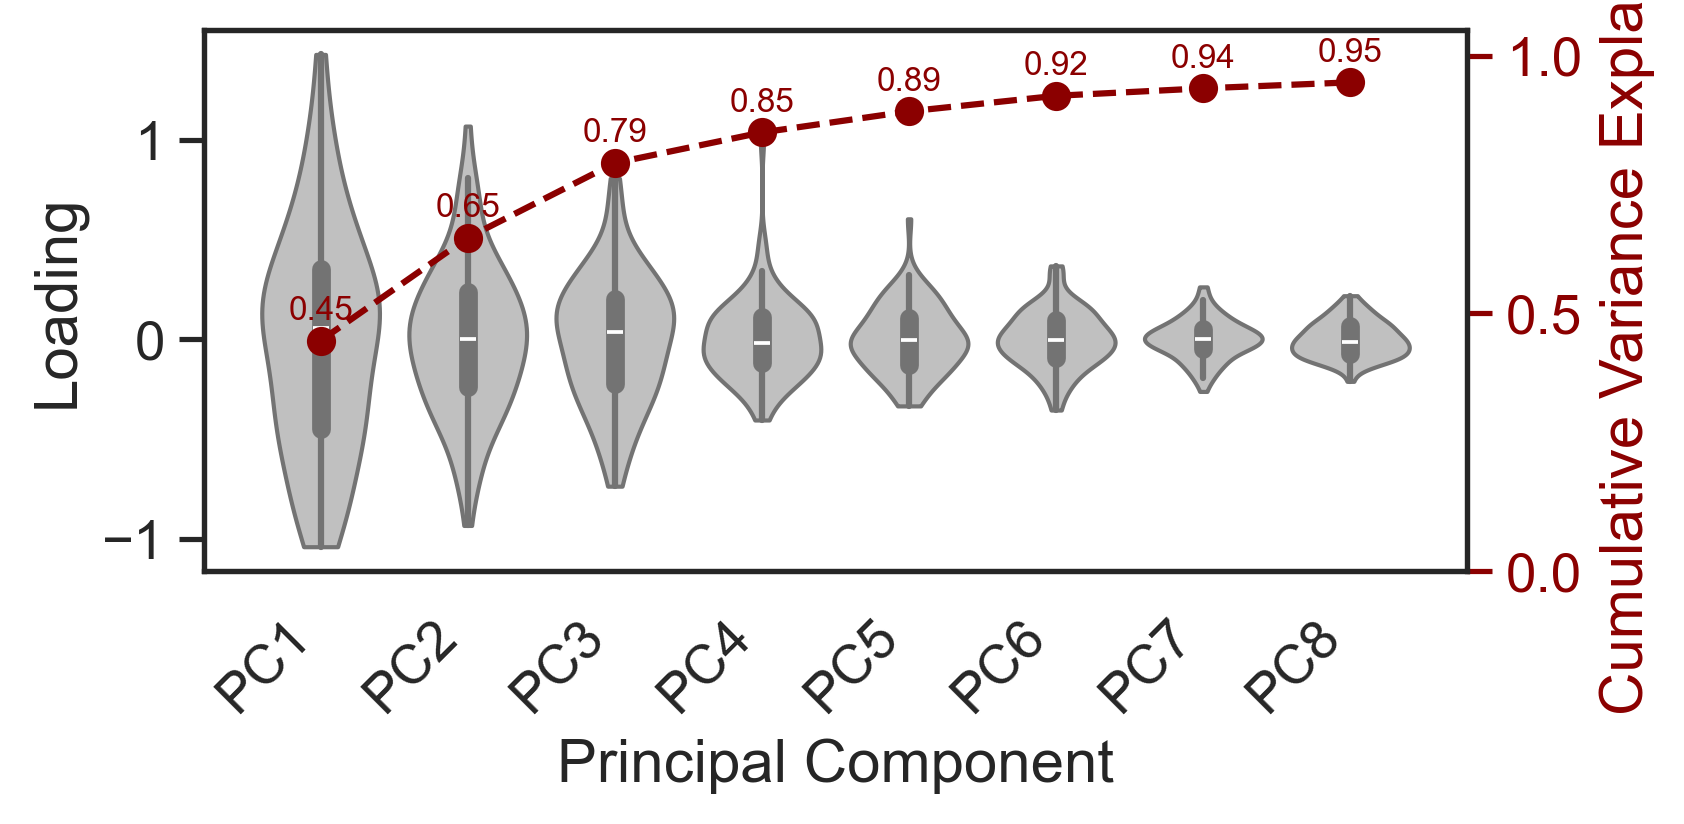


=== Explained Variance per PC ===
  PC  Explained_Variance_Ratio  Cumulative_Variance_Explained
 PC1                  0.447294                       0.447294
 PC2                  0.199595                       0.646889
 PC3                  0.144868                       0.791757
 PC4                  0.059264                       0.851021
 PC5                  0.040873                       0.891894
 PC6                  0.030164                       0.922058
 PC7                  0.014431                       0.936490
 PC8                  0.011623                       0.948113
 PC9                  0.010023                       0.958135
PC10                  0.008810                       0.966945
PC11                  0.006753                       0.973697
PC12                  0.006336                       0.980034
PC13                  0.004284                       0.984318
PC14                  0.003213                       0.987531
PC15                  0.002907     

In [25]:
from geomstats.learning.pca import TangentPCA
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin, SRVMetric
import geomstats.backend as gs

# === tPCA on aligned curves ===
tPCA_N_COMPONENTS = 16

# Manifold
curves_r3_aligned = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3,
    k_sampling_points=k_sampling_points,
)
curves_r3_aligned.equip_with_metric(SRVMetric)

# 从字典转成 list of arrays
aligned_curves = list(aligned_final_dict.values())
print("Number of aligned curves:", len(aligned_curves))
print("Shape of one curve:", aligned_curves[0].shape)

# 堆叠成 (n_curves, 240, 3)
aligned_curves_array = gs.stack(aligned_curves, axis=0)
print("Aligned array shape:", aligned_curves_array.shape)

print("Aligned array shape:", aligned_curves_array.shape)

# Fréchet mean as base point
mean_aligned = FrechetMean(curves_r3_aligned)
mean_aligned.fit(aligned_curves_array)
mean_curve_aligned = mean_aligned.estimate_
print("Mean curve shape:", mean_curve_aligned.shape)

# Tangent PCA
aligned_tpca = TangentPCA(curves_r3_aligned, n_components=tPCA_N_COMPONENTS)
aligned_tpca.fit(aligned_curves_array, base_point=mean_curve_aligned)
aligned_projected_data = aligned_tpca.transform(aligned_curves_array)

print(f"[tPCA] Explained variance ratio (first 10 PCs): {aligned_tpca.explained_variance_ratio_[:10]}")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- 数据准备（前 K=8 个PC）----
explained_variance_ratio = aligned_tpca.explained_variance_ratio_
cumulative_ratio = np.cumsum(explained_variance_ratio)
K = 8

df_long = (
    pd.DataFrame(aligned_projected_data[:, :K],
                 columns=[f"PC{i+1}" for i in range(K)])
      .melt(var_name="PC", value_name="Loading")
)

x_vals = np.arange(K)
labels = [f"PC{i+1}" for i in range(K)]

# ---- 绘图：小提琴 + 累计解释率 ----
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)

sns.violinplot(
    data=df_long, x="PC", y="Loading",
    linewidth=1.0, cut=0, scale="width", color="silver", ax=ax1
)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Loading")
ax1.set_xticklabels(labels, rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(x_vals, cumulative_ratio[:K],
         color='darkred', marker='o', linestyle='--',
         label='Cumulative Variance')
ax2.set_ylabel("Cumulative Variance Explained", color='darkred')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', colors='darkred')

# 数值标注
for x, y in zip(x_vals, cumulative_ratio[:K]):
    ax2.annotate(f"{y:.2f}", (x, y),
                 textcoords="offset points", xytext=(0, 5),
                 ha='center', fontsize=8, color='darkred')

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


# === 导出每个PC的数值 ===

# 1. 每个PC的累计解释方差
cve_table = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    "Explained_Variance_Ratio": explained_variance_ratio,
    "Cumulative_Variance_Explained": cumulative_ratio
})

print("\n=== Explained Variance per PC ===")
print(cve_table.head(16).to_string(index=False))  # 打印前16个

# 2. 每个PC的loadings分布（即投影系数矩阵 aligned_projected_data）
loadings_table = pd.DataFrame(
    aligned_projected_data[:, :tPCA_N_COMPONENTS],
    columns=[f"PC{i+1}" for i in range(tPCA_N_COMPONENTS)]
)

print("\n=== Loadings (first 5 rows) ===")
print(loadings_table.head().to_string(index=False))

# 如果要保存为csv
cve_table.to_csv("tpca_explained_variance.csv", index=False)
loadings_table.to_csv("tpca_loadings.csv", index=False)



In [26]:
def rescale_curve_to_length(curve, target_length=75.0):
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    length = np.sum(seg_lengths)
    scale = target_length / length
    return curve * scale

# === 函数：数值求曲率 ===
def compute_curvature(curve):
    diffs = np.gradient(curve, axis=0)
    d2 = np.gradient(diffs, axis=0)
    cross = np.cross(diffs, d2)
    num = np.linalg.norm(cross, axis=1)
    denom = np.linalg.norm(diffs, axis=1) ** 3
    kappa = np.divide(num, denom, out=np.zeros_like(num), where=denom > 1e-6)
    return kappa

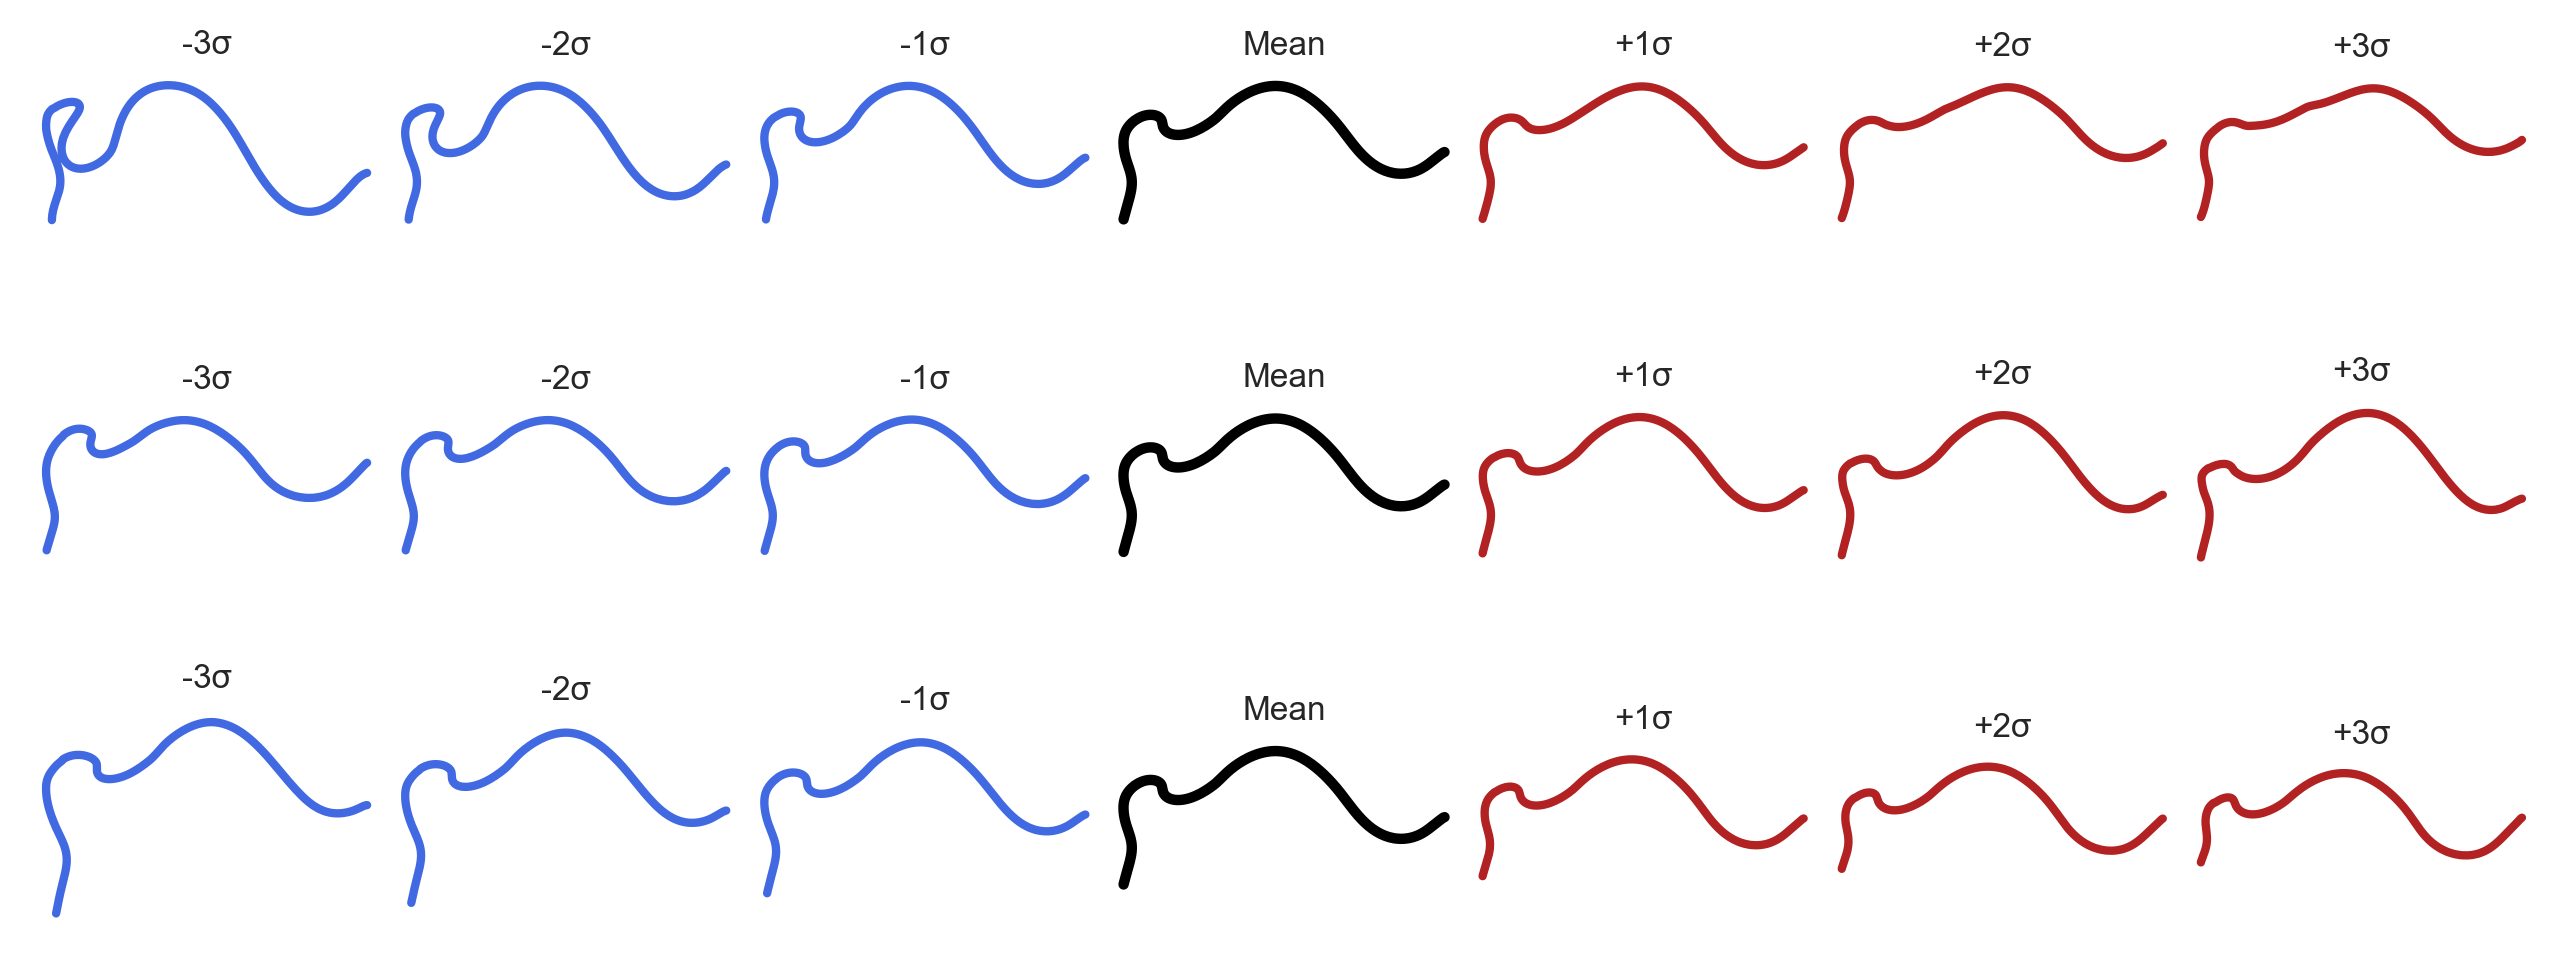

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === 函数：在某个PC方向上做 ±σ 重建 ===
def reconstruct_along_pc(tpca, base_curve, pc_index, n_std, discrete_curves_space):
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    std = np.sqrt(tpca.explained_variance_[pc_index])
    pc_vec = principal_components[pc_index]

    curves = []
    for s in n_std:
        for sign in [-1, 1]:
            tangent_vec = sign * s * std * pc_vec
            curve_recon = discrete_curves_space.metric.exp(
                tangent_vec=tangent_vec,
                base_point=base_curve
            )
            curves.append((sign, s, curve_recon))
    return curves

# === 参数 ===
pcs_to_show = [0, 1, 2]   # PC1, PC2, PC3
n_std = [1, 2, 3]            # ±1σ, ±2σ
n_cols = len(n_std)*2 + 1 # 每行的列数

fig, axes = plt.subplots(
    nrows=len(pcs_to_show),
    ncols=n_cols,
    figsize=(1.2*n_cols, 1.2*len(pcs_to_show)),  # 控制图像整体大小
    dpi=300
)

# 统一做一次 PCA 投影（用均值+所有变形曲线）
all_curves = [mean_curve_aligned]
for pc_idx in pcs_to_show:
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )
    for _, _, C in curves:
        all_curves.append(C)

all_points = np.vstack(all_curves)  # (N_total_points, 3)
pca2d = PCA(n_components=2)
pca2d.fit(all_points)

def project2d(curve):
    return pca2d.transform(curve)

# === 绘制 ===
for row, pc_idx in enumerate(pcs_to_show):
    ax_row = axes[row] if len(pcs_to_show) > 1 else [axes]

    # --- 生成该PC的所有曲线 ---
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )
    # 排序: -2σ, -1σ, Mean, +1σ, +2σ
    ordered = sorted(curves, key=lambda x: (x[0], x[1]))
    ordered = [c for c in ordered if c[0] < 0][::-1] + [(0, 0, mean_curve_aligned)] + [c for c in ordered if c[0] > 0]

    for col, (sign, s, C) in enumerate(ordered):
        ax = ax_row[col]
        proj = project2d(C)

        if s == 0:  # mean
            ax.plot(proj[:,0], proj[:,1], color="black", lw=2.5)
            ax.set_title("Mean", fontsize=8)
        else:  # variations
            color = "royalblue" if sign < 0 else "firebrick"
            ax.plot(proj[:,0], proj[:,1], color=color, lw=2.0)
            ax.set_title(f"{'+' if sign>0 else '-'}{s}σ", fontsize=8)

        # 去掉坐标和边框
        ax.axis("off")
        ax.set_aspect("equal")

    # 行标题
    ax_row[0].set_ylabel(f"PC{pc_idx+1}", fontsize=9, rotation=0, labelpad=20, weight="bold")

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()


C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\1367593068.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



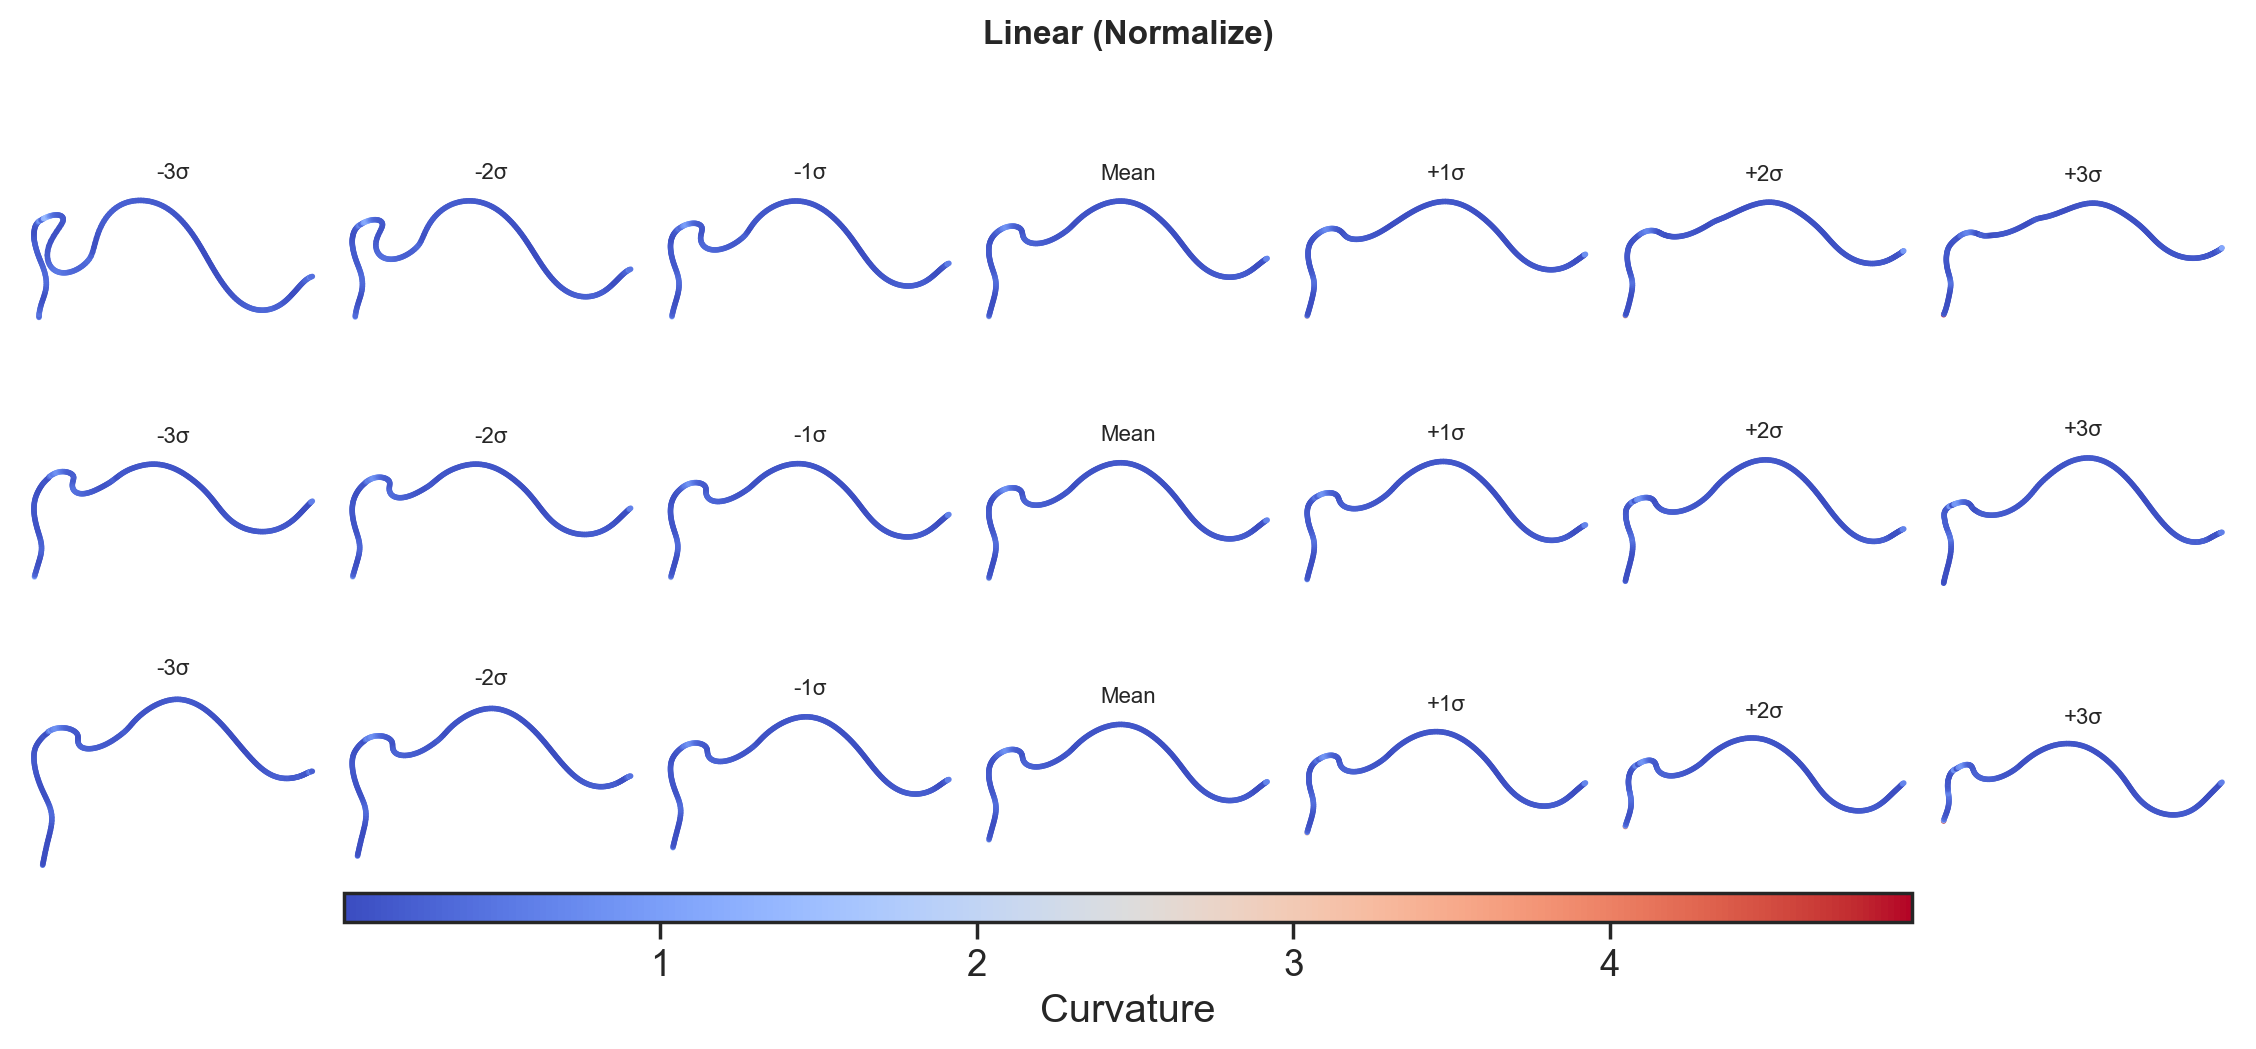

C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\1367593068.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



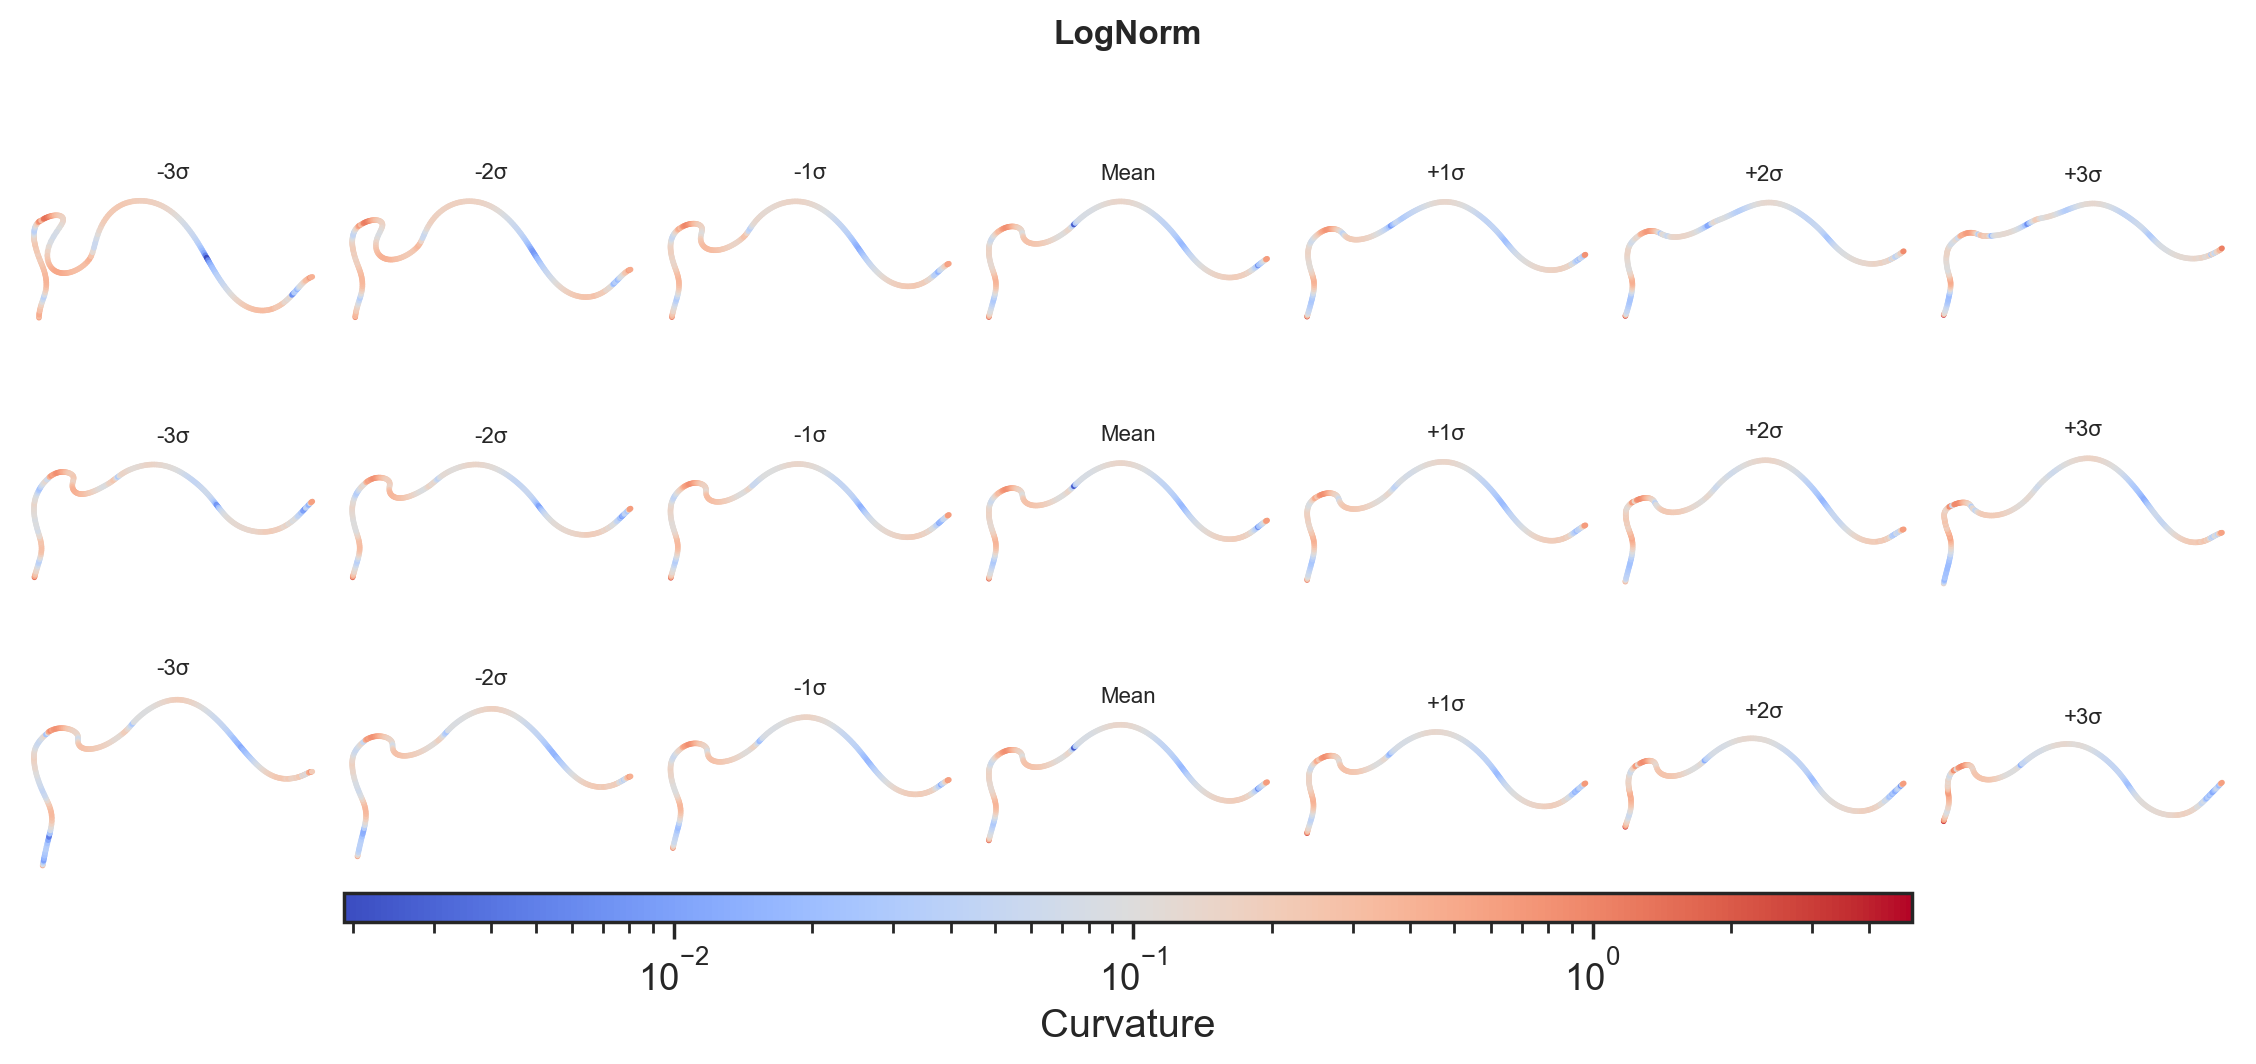

C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\1367593068.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



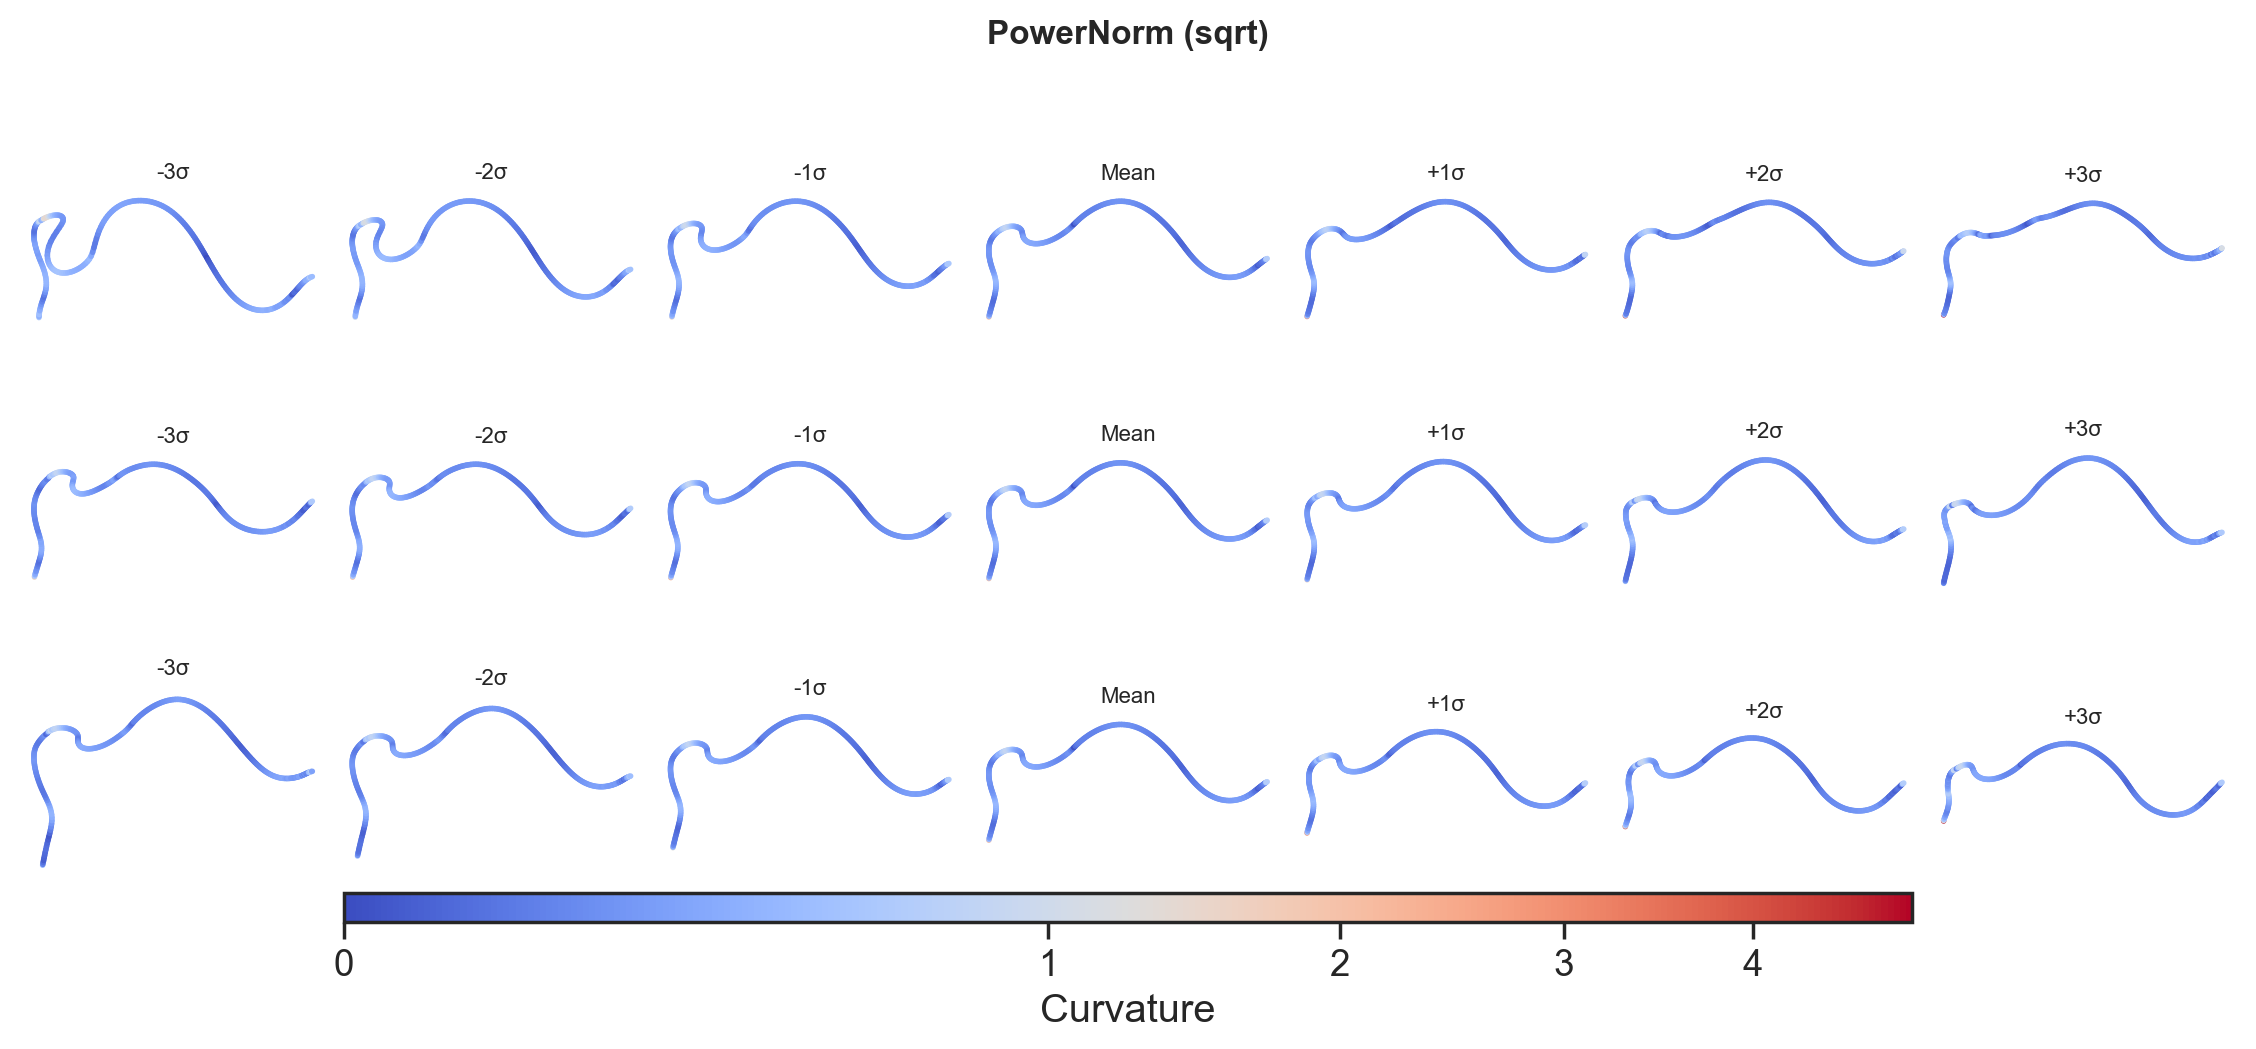

C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\1367593068.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



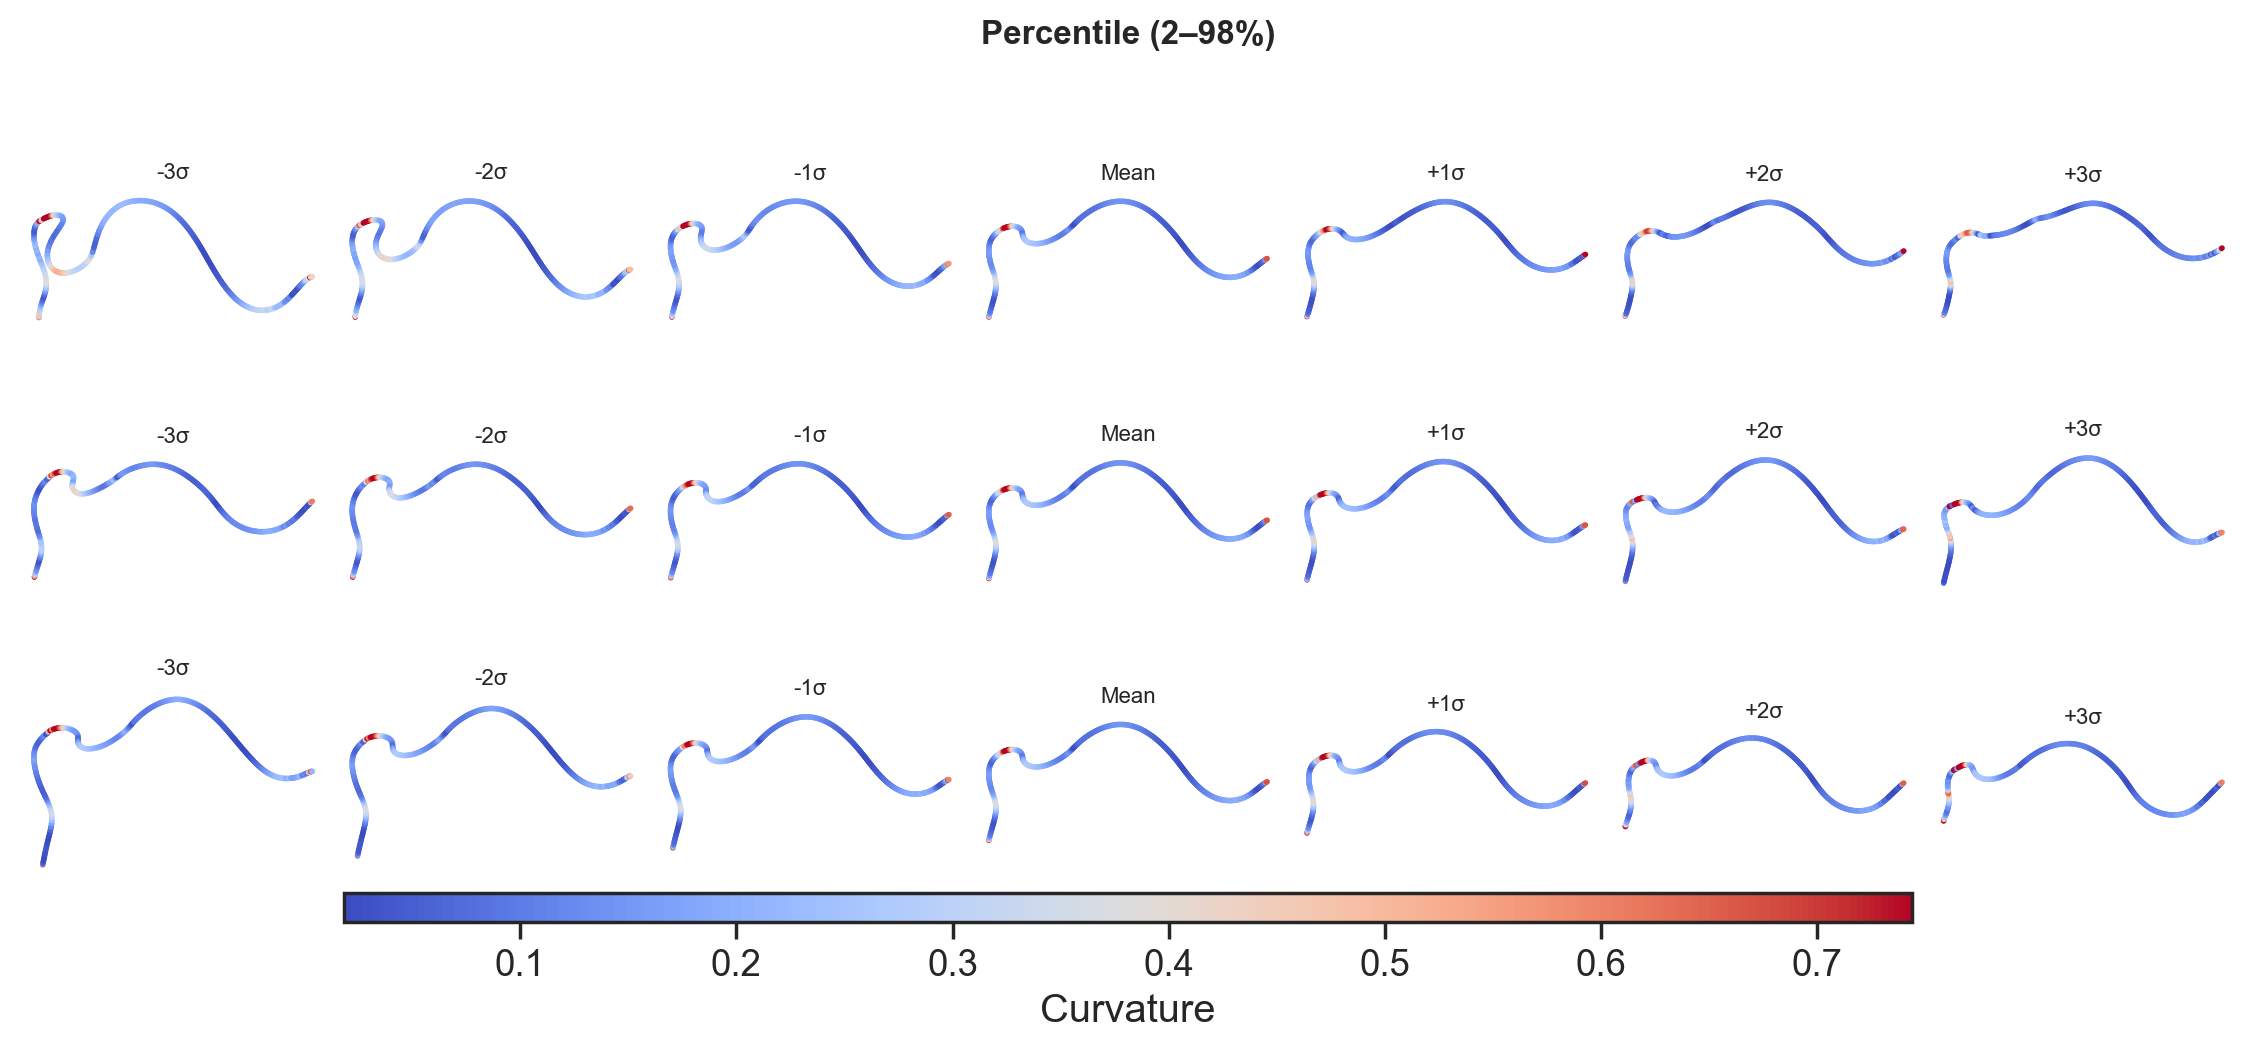

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.decomposition import PCA

# === 函数：在某个PC方向上做 ±σ 重建 ===
def reconstruct_along_pc(tpca, base_curve, pc_index, n_std, discrete_curves_space):
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    std = np.sqrt(tpca.explained_variance_[pc_index])
    pc_vec = principal_components[pc_index]

    curves = []
    for s in n_std:
        for sign in [-1, 1]:
            tangent_vec = sign * s * std * pc_vec
            curve_recon = discrete_curves_space.metric.exp(
                tangent_vec=tangent_vec,
                base_point=base_curve
            )
            curves.append((sign, s, curve_recon))
    return curves

# === 参数 ===
pcs_to_show = [0, 1, 2]   # PC1, PC2, PC3
n_std = [1, 2, 3]         # ±1σ, ±2σ
n_cols = len(n_std)*2 + 1 # 每行的列数
cmap = plt.cm.coolwarm

# === 统一 PCA 投影 ===
all_curves = [mean_curve_aligned]
for pc_idx in pcs_to_show:
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )
    for _, _, C in curves:
        all_curves.append(C)

all_points = np.vstack(all_curves)
pca2d = PCA(n_components=2)
pca2d.fit(all_points)

def project2d(curve):
    return pca2d.transform(curve)

# === 计算所有曲率值，确定全局范围 ===
all_curv_vals = []
for C in all_curves:
    C_rescaled = rescale_curve_to_length(C, target_length=75.0)
    kappa = compute_curvature(C_rescaled)
    all_curv_vals.append(kappa)
all_curv_vals = np.concatenate(all_curv_vals)
vmin, vmax = np.min(all_curv_vals), np.max(all_curv_vals)

# 百分位裁剪
qmin, qmax = np.percentile(all_curv_vals, [2, 98])

# === 四种颜色映射方案 ===
norm_methods = {
    "Linear (Normalize)": colors.Normalize(vmin=vmin, vmax=vmax),
    "LogNorm": colors.LogNorm(vmin=max(vmin, 1e-6), vmax=vmax),
    "PowerNorm (sqrt)": colors.PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax),
    "Percentile (2–98%)": colors.Normalize(vmin=qmin, vmax=qmax),
}

# === 主绘图循环 ===
for norm_name, norm in norm_methods.items():
    fig, axes = plt.subplots(
        nrows=len(pcs_to_show),
        ncols=n_cols,
        figsize=(1.6*n_cols, 1.6*len(pcs_to_show)),
        dpi=200
    )

    for row, pc_idx in enumerate(pcs_to_show):
        ax_row = axes[row] if len(pcs_to_show) > 1 else [axes]

        # 生成该PC的所有曲线
        curves = reconstruct_along_pc(
            tpca=aligned_tpca,
            base_curve=mean_curve_aligned,
            pc_index=pc_idx,
            n_std=n_std,
            discrete_curves_space=curves_r3_aligned
        )

        ordered = sorted(curves, key=lambda x: (x[0], x[1]))
        ordered = [c for c in ordered if c[0] < 0][::-1] + [(0, 0, mean_curve_aligned)] + [c for c in ordered if c[0] > 0]

        for col, (sign, s, C) in enumerate(ordered):
            ax = ax_row[col]
            C_rescaled = rescale_curve_to_length(C, target_length=75.0)
            kappa = compute_curvature(C_rescaled)
            proj = project2d(C_rescaled)

            # 按曲率画彩色线
            for i in range(len(proj)-1):
                color = cmap(norm(kappa[i]))
                ax.plot(proj[i:i+2,0], proj[i:i+2,1], color=color, lw=2)

            # 标题
            if s == 0:
                ax.set_title("Mean", fontsize=8)
            else:
                ax.set_title(f"{'+' if sign>0 else '-'}{s}σ", fontsize=8)

            ax.axis("off")
            ax.set_aspect("equal")

        ax_row[0].set_ylabel(f"PC{pc_idx+1}", fontsize=9, rotation=0, labelpad=20, weight="bold")

    # 统一 colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    # 在底部预留空间并添加横向 colorbar
    plt.subplots_adjust(bottom=0.10)                 # 给底部留出 18% 空间
    cax = fig.add_axes([0.15, 0.04, 0.70, 0.03])     # [left, bottom, width, height]
    fig.colorbar(sm, cax=cax, orientation='horizontal', label="Curvature")


    fig.suptitle(norm_name, fontsize=12, weight="bold")
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=0.3, rect=[0, 0, 1, 0.96])
    plt.show()


C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\3352969899.py:62: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

INFO: maxp pruned
INFO: LTSH dropped
INFO: cmap pruned
INFO: kern dropped
INFO: post pruned
INFO: PCLT dropped
INFO: GPOS pruned
INFO: GSUB pruned
INFO: JSTF dropped
INFO: meta dropped
INFO: DSIG dropped
INFO: name pruned
INFO: glyf pruned
INFO: Added gid0 to subset
INFO: Added first four glyphs to subset
INFO: Closing glyph list over 'GSUB': 25 glyphs before
INFO: Glyph names: ['.notdef', 'C', 'M', 'a', 'e', 'five', 'four', 'glyph00001', 'glyph00002', 'hyphen', 'n', 'one', 'period', 'plus', 'r', 'seven', 'sigma', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'zero']
INFO: Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 38, 48, 68, 72, 81, 85, 87, 88, 89, 305]
INFO: Closed glyph list over 'GSUB': 41 glyphs after
INFO: Glyph names: ['.notdef', 'C', 'M', 'a', 'e', 'five', 'four', 'glyp

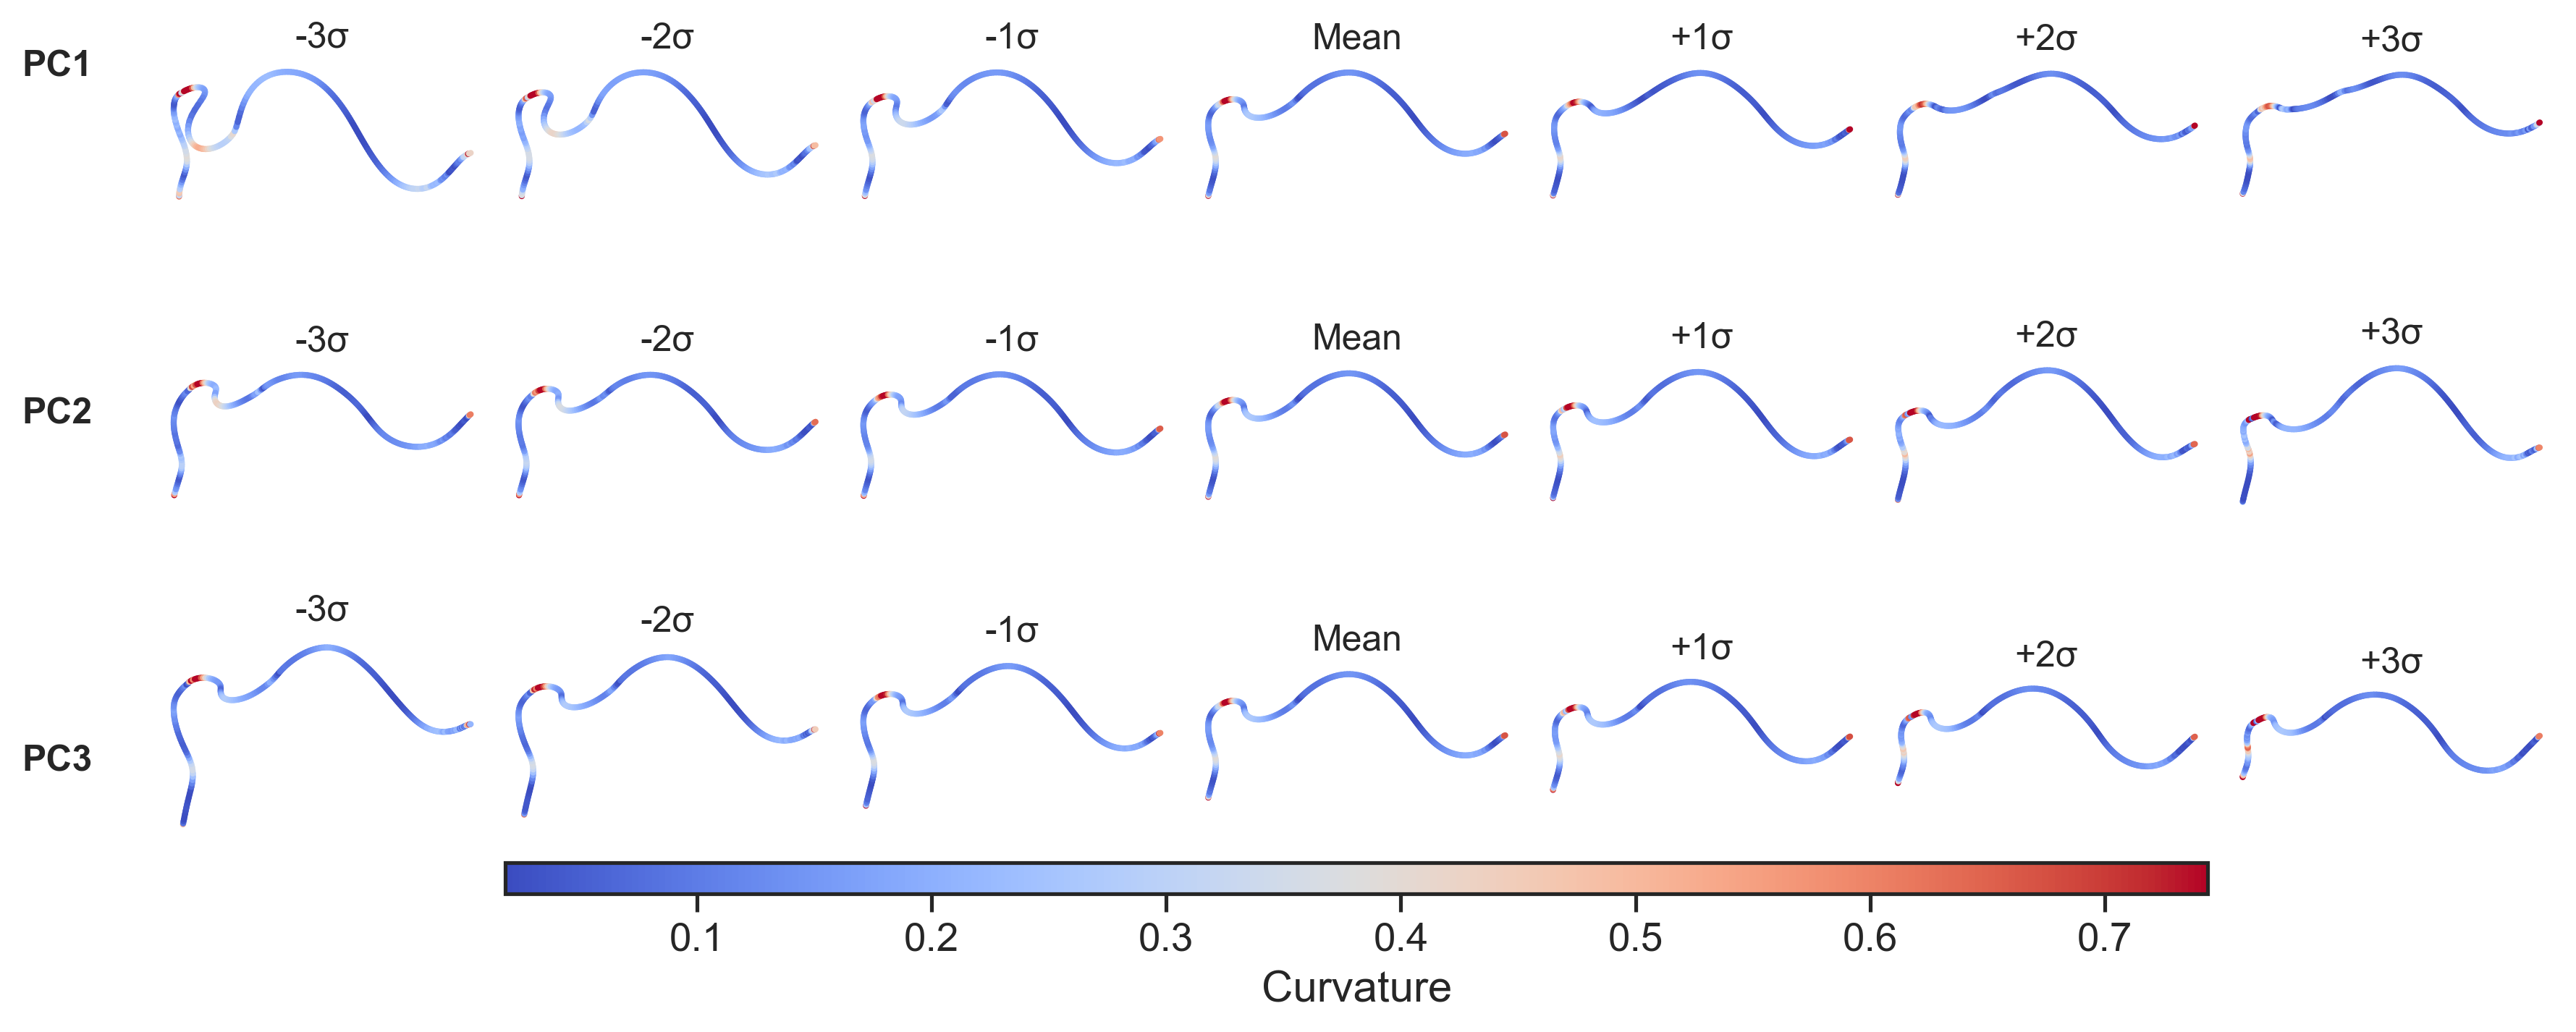

In [29]:
# === 只画 Percentile (2–98%) 并保存为 PDF ===
import matplotlib as mpl
mpl.rcParams.update({
    "font.size": 20,       # 全局默认字体大小
})


norm = colors.Normalize(vmin=qmin, vmax=qmax)
norm_name = "Percentile (2–98%)"

pcs_to_show = [0, 1, 2]
fig, axes = plt.subplots(
    nrows=len(pcs_to_show),
    ncols=n_cols,
    figsize=(1.6*n_cols, 1.6*len(pcs_to_show)),
)

for row, pc_idx in enumerate(pcs_to_show):
    ax_row = axes[row] if len(pcs_to_show) > 1 else [axes]

    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )

    ordered = sorted(curves, key=lambda x: (x[0], x[1]))
    ordered = [c for c in ordered if c[0] < 0][::-1] + [(0, 0, mean_curve_aligned)] + [c for c in ordered if c[0] > 0]

    for col, (sign, s, C) in enumerate(ordered):
        ax = ax_row[col]
        C_rescaled = rescale_curve_to_length(C, target_length=75.0)
        kappa = compute_curvature(C_rescaled)
        proj = project2d(C_rescaled)

        for i in range(len(proj)-1):
            color = cmap(norm(kappa[i]))
            ax.plot(proj[i:i+2,0], proj[i:i+2,1], color=color, lw=2)

        if s == 0:
            ax.set_title("Mean", fontsize=12)
        else:
            ax.set_title(f"{'+' if sign>0 else '-'}{s}σ", fontsize=12)

        ax.axis("off")
        ax.set_aspect("equal")

    # --- 用 fig.text 在每行最左侧添加标签 ---
    ypos = (len(pcs_to_show) - row - 0.5) / len(pcs_to_show)   # 计算行中心的 y 坐标
    fig.text(-0.02, ypos, f"PC{pc_idx+1}", va="center", ha="right",
             fontsize=12, weight="bold")

# 统一 colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.subplots_adjust(bottom=0.10)
cax = fig.add_axes([0.15, 0.04, 0.70, 0.03])
fig.colorbar(sm, cax=cax, orientation='horizontal', label="Curvature")

# === 保存为 PDF ===
plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=0.3, rect=[0, 0, 1, 0.96])
plt.savefig("pc_percentile_curvature.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# === 函数：提取对应的landmarks并与RC比较 ===
def extract_landmarks(curvature, s, ref_curve, ref_peaks):
    peaks, _ = find_peaks(
        curvature,
        prominence=(np.max(curvature)-np.min(curvature))*0.08,
        distance=len(curvature)//10
    )
    peaks_sorted = peaks[np.argsort(s[peaks])]
    n = min(len(peaks_sorted), len(ref_peaks))

    # === 归一化到 [0,1] 区间 (相对弧长位置) ===
    s_norm = s / s[-1]                 # 当前曲线归一化位置
    ref_s_norm = s[ref_peaks] / s[-1]  # RC 上的归一化位置

    pos_diff = s_norm[peaks_sorted[:n]] - ref_s_norm[:n]
    val_diff = curvature[peaks_sorted[:n]] - ref_curve[ref_peaks[:n]]
    return pos_diff, val_diff, peaks_sorted[:n]

# === Reference Curvature (RC, 群体曲率均值) ===
aligned_curves_scaled = [rescale_curve_to_length(C, 75.0) for C in aligned_curves]
all_curvatures = [compute_curvature(C) for C in aligned_curves_scaled]
# RC_curve = np.mean(all_curvatures, axis=0)
RC_curve = obj_weighted.fmean
RC_s = np.linspace(0, 75.0, aligned_curves_scaled[0].shape[0])

# 找 RC 上的 landmark
RC_peaks, _ = find_peaks(
    RC_curve,
    prominence=(np.max(RC_curve) - np.min(RC_curve)) * 0.08,
    distance=len(RC_curve) // 10
)
RC_peaks = RC_peaks[np.argsort(RC_s[RC_peaks])]

# === 去掉最后一个峰值，保留前 5 个 ===
if len(RC_peaks) > 5:
    RC_peaks = RC_peaks[:5]

print(f"RC found {len(RC_peaks)} landmarks (last one ignored if >5)")

# === 计算 mean_curve_aligned 的曲率（单独保存，用于比较） ===
mean_curve_scaled = rescale_curve_to_length(mean_curve_aligned, 75.0)
mean_curve_kappa = compute_curvature(mean_curve_scaled)

# === 构造要比较的曲线集合 ===
curves_to_check = {"MeanCurve": mean_curve_aligned}

pcs_to_show = [0, 1, 2]   # PC1~PC3
n_std = [1, 2, 3]         # ±1σ, ±2σ, ±3σ

for pc_idx in pcs_to_show:
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )
    for sign, s, C in curves:
        label = f"PC{pc_idx+1}_{'+' if sign>0 else '-'}{s}σ"
        curves_to_check[label] = C

# === 计算并比较 ===
results = {}

for name, curve in curves_to_check.items():
    curve_scaled = rescale_curve_to_length(curve, 75.0)
    s = np.linspace(0, 75.0, curve_scaled.shape[0])
    kappa = compute_curvature(curve_scaled)

    pos_diff, val_diff, peaks = extract_landmarks(
        kappa, s, RC_curve, RC_peaks
    )

    results[name] = {
        "pos_diff": pos_diff,
        "val_diff": val_diff,
        "peaks": peaks,
        "kappa": kappa,
        "s": s,
    }

# === 打印 landmark 差异（只保留 C0 ~ C4） ===
print("\n--- RC (Reference Curvature) ---")
RC_s_norm = RC_s / RC_s[-1]   # 归一化到 [0,1]
print(f"Landmark positions (normalized): {RC_s_norm[RC_peaks]}")
print(f"Landmark values: {RC_curve[RC_peaks]}")

print("\n--- Comparisons ---")
for name, res in results.items():
    print(f"\n{name}:")
    n_landmarks = min(5, len(res["pos_diff"]))  # 最多打印 5 个
    for i in range(n_landmarks):
        dp, dv = res["pos_diff"][i], res["val_diff"][i]
        print(f"  Landmark C{i}: Δpos={dp:.3f} (relative), Δval={dv:.3f}")


RC found 5 landmarks (last one ignored if >5)

--- RC (Reference Curvature) ---
Landmark positions (normalized): [0.08403361 0.29831933 0.45378151 0.64705882 0.89915966]
Landmark values: [0.28334765 0.42491911 0.1942218  0.17446767 0.19939986]

--- Comparisons ---

MeanCurve:
  Landmark C0: Δpos=0.000 (relative), Δval=0.110
  Landmark C1: Δpos=-0.034 (relative), Δval=0.423
  Landmark C2: Δpos=-0.080 (relative), Δval=0.080
  Landmark C3: Δpos=0.210 (relative), Δval=0.025
  Landmark C4: Δpos=0.097 (relative), Δval=0.470

PC1_-1σ:
  Landmark C0: Δpos=0.000 (relative), Δval=0.091
  Landmark C1: Δpos=-0.034 (relative), Δval=0.564
  Landmark C2: Δpos=-0.071 (relative), Δval=0.145
  Landmark C3: Δpos=-0.071 (relative), Δval=-0.018
  Landmark C4: Δpos=-0.038 (relative), Δval=0.034

PC1_+1σ:
  Landmark C0: Δpos=0.000 (relative), Δval=0.134
  Landmark C1: Δpos=-0.029 (relative), Δval=0.345
  Landmark C2: Δpos=0.542 (relative), Δval=0.598

PC1_-2σ:
  Landmark C0: Δpos=0.181 (relative), Δval=0.894

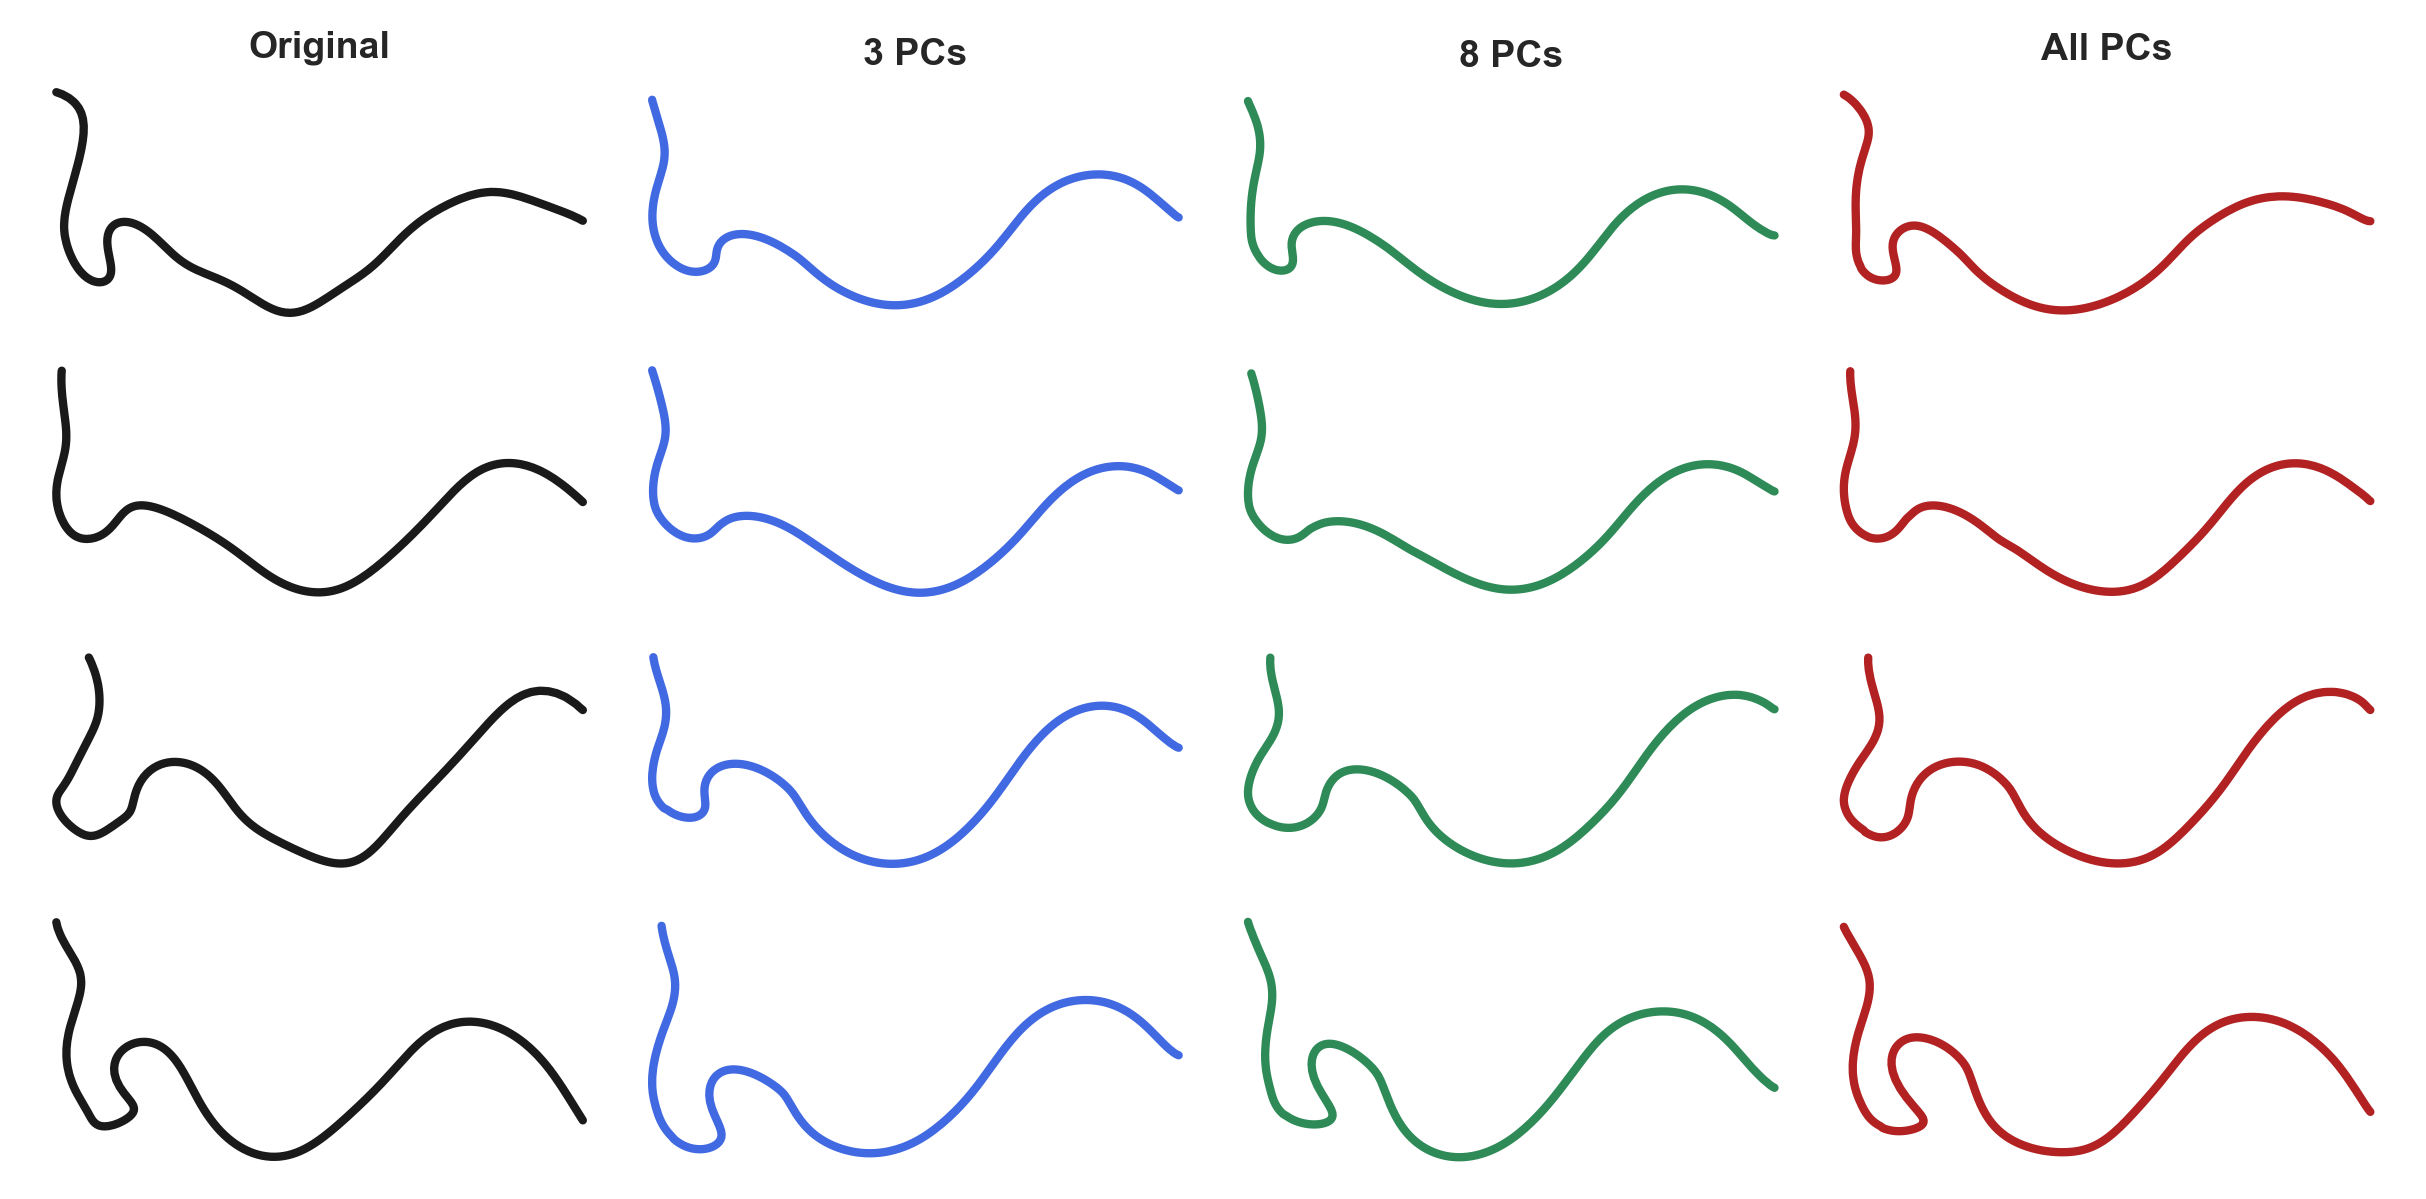

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === 函数：用前 k 个主成分重建 ===
def reconstruct_with_k_pcs(tpca, projected_data, curve_idx, k, discrete_curves_space, base_curve):
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    coeffs = projected_data[curve_idx]

    tangent_vec = np.zeros_like(base_curve)
    for i in range(k):
        tangent_vec += coeffs[i] * principal_components[i]

    curve_recon = discrete_curves_space.metric.exp(
        tangent_vec=tangent_vec,
        base_point=base_curve
    )
    return curve_recon

# === 要展示的 case ===
groups = {
    "U": ["BG0020_R.vtk"],
    "V": ["BG0012_R.vtk"],
    "C": ["BG0017_R.vtk"], 
    "S": ["BG0011_R.vtk"], 
}

# === 准备所有需要的曲线（为了统一投影到2D） ===
all_curves = []
curve_cache = {}

for gname, keys in groups.items():
    key = keys[0]
    idx = list(vtk_data_dict.keys()).index(key)
    orig = aligned_curves_array[idx]

    rec3  = reconstruct_with_k_pcs(aligned_tpca, aligned_projected_data, idx, 3,  curves_r3_aligned, mean_curve_aligned)
    rec8  = reconstruct_with_k_pcs(aligned_tpca, aligned_projected_data, idx, 8,  curves_r3_aligned, mean_curve_aligned)
    recAll = reconstruct_with_k_pcs(aligned_tpca, aligned_projected_data, idx, aligned_tpca.n_components_, curves_r3_aligned, mean_curve_aligned)

    curve_cache[gname] = {"Original": orig, "3 PCs": rec3, "8 PCs": rec8, "All PCs": recAll}
    all_curves.extend([orig, rec3, rec8, recAll])

# === PCA 统一投影到 2D ===
all_points = np.vstack(all_curves)  # (N_total_points, 3)
pca2d = PCA(n_components=2)
pca2d.fit(all_points)

def project2d(curve):
    return pca2d.transform(curve)

# === 绘图 ===
fig, axes = plt.subplots(len(groups), 4, figsize=(8, 4), dpi=300)

titles = ["Original", "3 PCs", "8 PCs", "All PCs"]
colors = {"Original": "k", "3 PCs": "royalblue", "8 PCs": "seagreen", "All PCs": "firebrick"}

for row_idx, (gname, _) in enumerate(groups.items()):
    curves = curve_cache[gname]
    for col_idx, name in enumerate(titles):
        ax = axes[row_idx, col_idx]
        proj = project2d(curves[name])
        ax.plot(proj[:,0], proj[:,1], color=colors[name], lw=2.0)
        ax.set_aspect("equal")
        ax.axis("off")
        if row_idx == 0:
            ax.set_title(name, fontsize=9, weight="bold")
        if col_idx == 0:
            ax.set_ylabel(gname, fontsize=9, rotation=0, labelpad=20, weight="bold")

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.show()


C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\326078261.py:109: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

INFO: maxp pruned
INFO: LTSH dropped
INFO: cmap pruned
INFO: kern dropped
INFO: post pruned
INFO: PCLT dropped
INFO: GPOS pruned
INFO: GSUB pruned
INFO: JSTF dropped
INFO: meta dropped
INFO: DSIG dropped
INFO: name pruned
INFO: glyf pruned
INFO: Added gid0 to subset
INFO: Added first four glyphs to subset
INFO: Closing glyph list over 'GSUB': 21 glyphs before
INFO: Glyph names: ['.notdef', 'C', 'a', 'e', 'eight', 'five', 'four', 'glyph00001', 'glyph00002', 'one', 'period', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'zero']
INFO: Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38, 68, 72, 85, 87, 88, 89]
INFO: Closed glyph list over 'GSUB': 39 glyphs after
INFO: Glyph names: ['.notdef', 'C', 'a', 'e', 'eight', 'five', 'four', 'glyph00001', 'glyph00002', 'glyph03674', 'gly

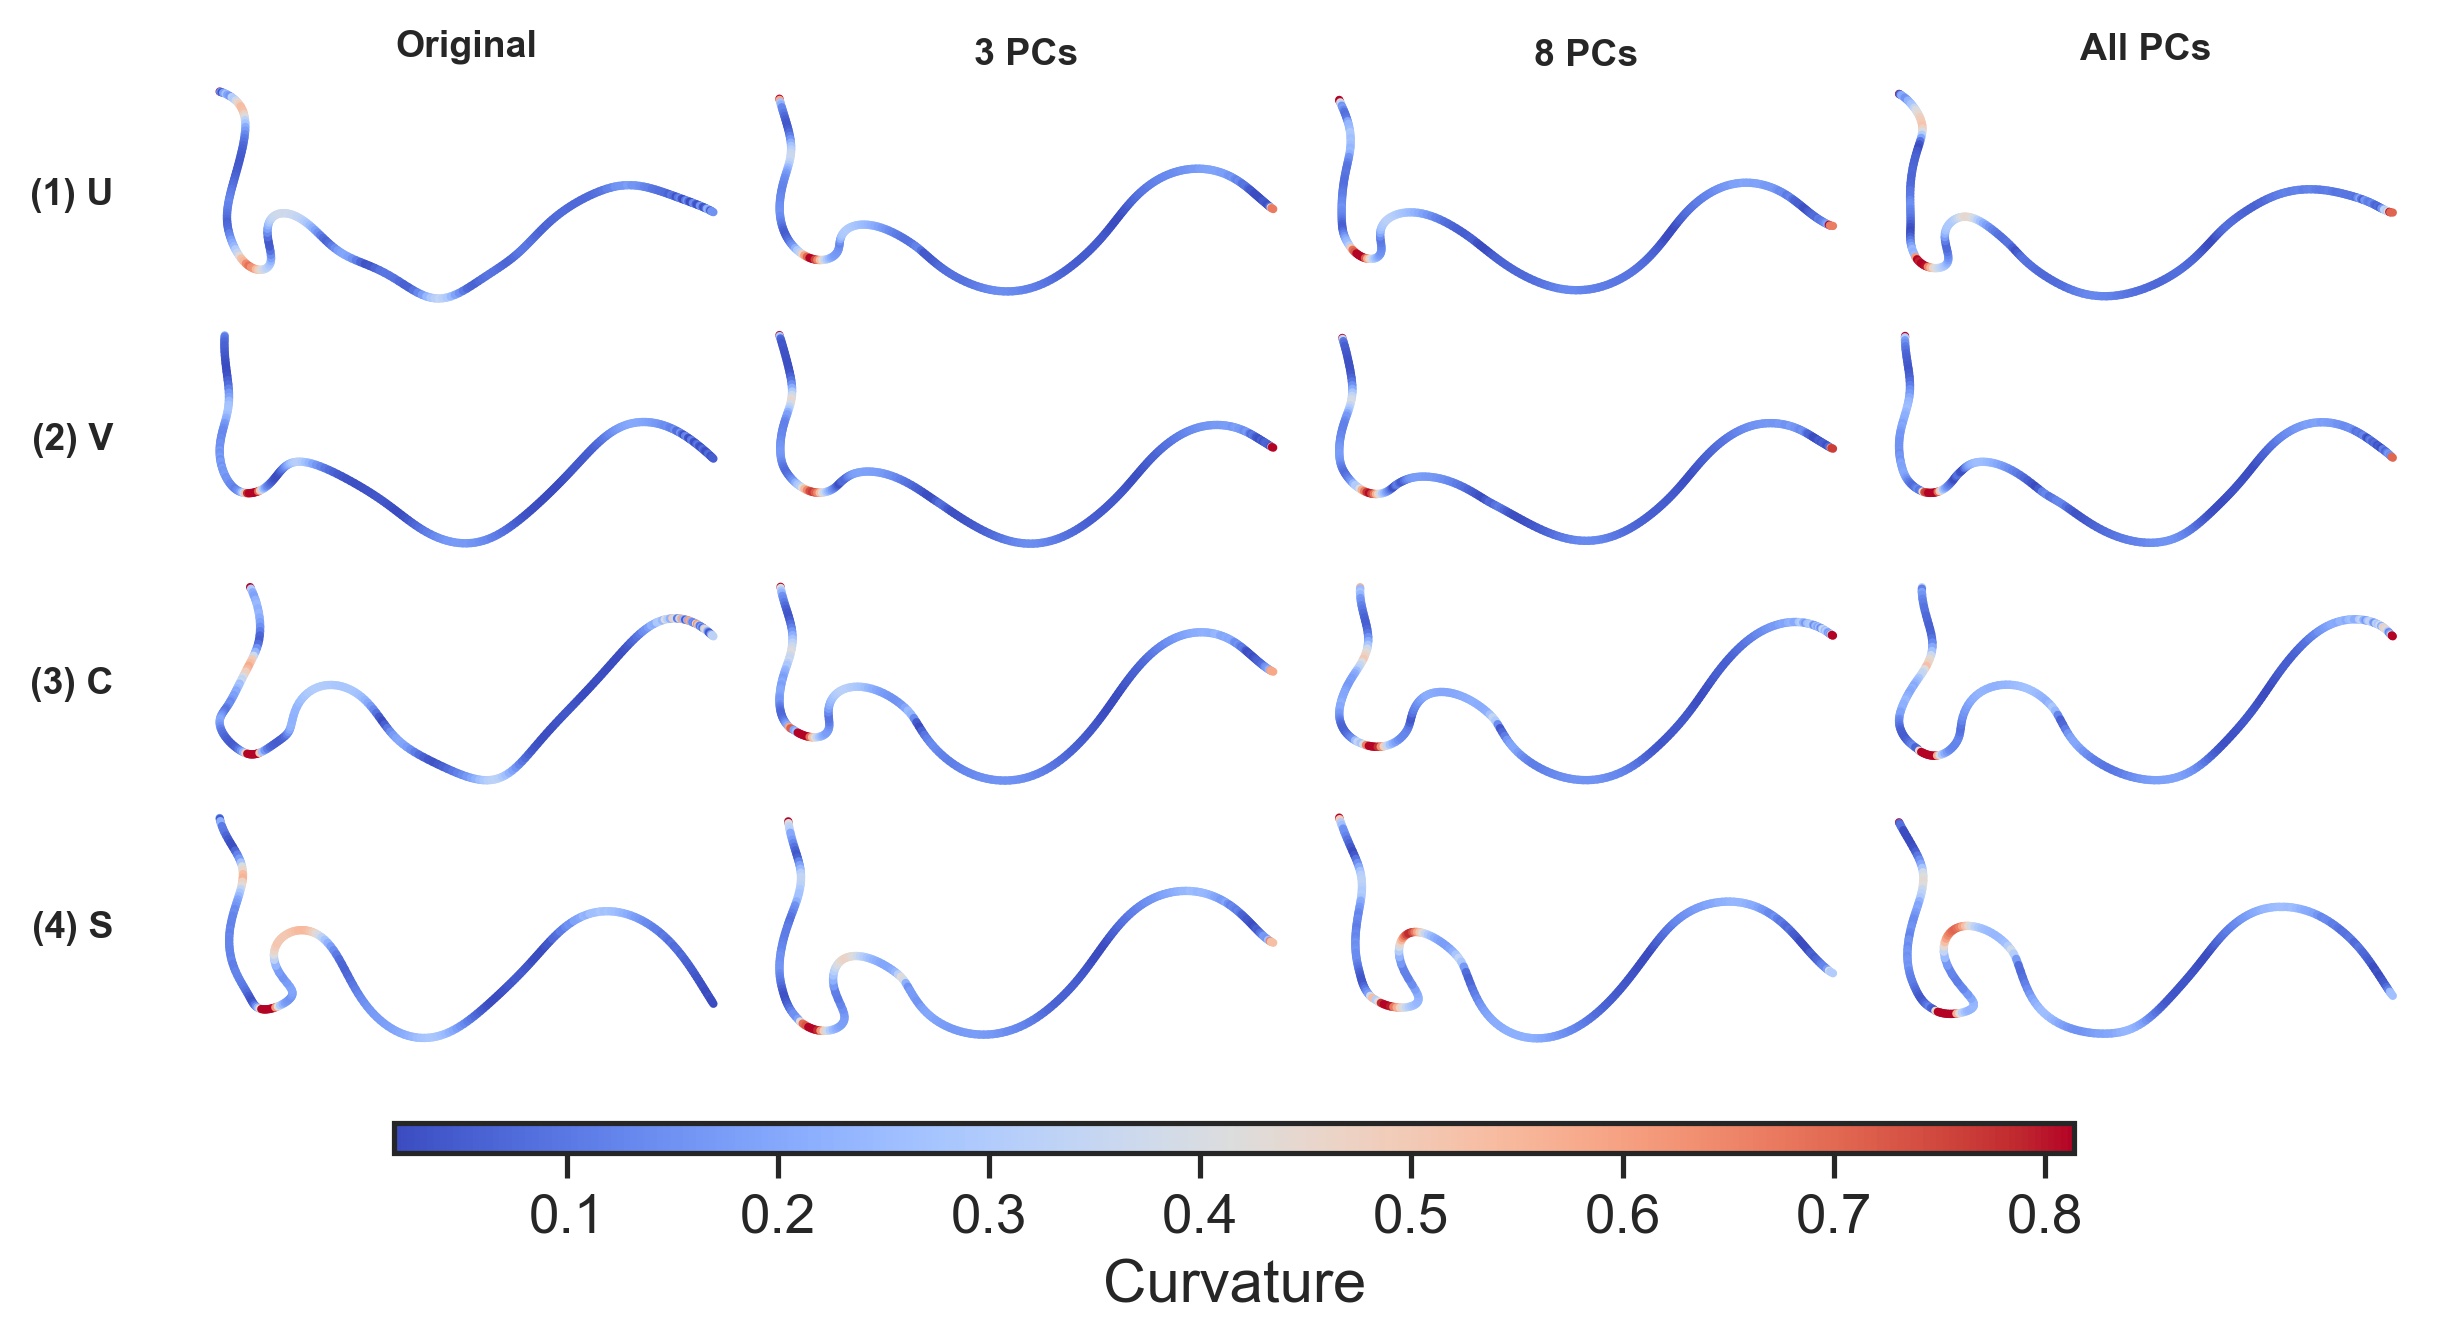

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.decomposition import PCA

# === 函数：用前 k 个主成分重建 ===
def reconstruct_with_k_pcs(tpca, projected_data, curve_idx, k, discrete_curves_space, base_curve):
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    coeffs = projected_data[curve_idx]

    tangent_vec = np.zeros_like(base_curve)
    for i in range(k):
        tangent_vec += coeffs[i] * principal_components[i]

    curve_recon = discrete_curves_space.metric.exp(
        tangent_vec=tangent_vec,
        base_point=base_curve
    )
    return curve_recon

# === 要展示的 case ===
groups = {
    "U": ["BG0020_R.vtk"],
    "V": ["BG0012_R.vtk"],
    "C": ["BG0017_R.vtk"],
    "S": ["BG0011_R.vtk"],
}

# === 准备所有需要的曲线 ===
all_curves = []
curve_cache = {}

for gname, keys in groups.items():
    key = keys[0]
    idx = list(vtk_data_dict.keys()).index(key)
    orig = aligned_curves_array[idx]

    rec3  = reconstruct_with_k_pcs(aligned_tpca, aligned_projected_data, idx, 3,  curves_r3_aligned, mean_curve_aligned)
    rec8  = reconstruct_with_k_pcs(aligned_tpca, aligned_projected_data, idx, 8,  curves_r3_aligned, mean_curve_aligned)
    recAll = reconstruct_with_k_pcs(aligned_tpca, aligned_projected_data, idx, aligned_tpca.n_components_, curves_r3_aligned, mean_curve_aligned)

    curve_cache[gname] = {"Original": orig, "3 PCs": rec3, "8 PCs": rec8, "All PCs": recAll}
    all_curves.extend([orig, rec3, rec8, recAll])

# === 统一投影到 2D ===
all_points = np.vstack(all_curves)
pca2d = PCA(n_components=2)
pca2d.fit(all_points)

def project2d(curve):
    return pca2d.transform(curve)

# === 统一曲率范围（百分位剪裁 2–98%） ===
all_curv_vals = []
for C in all_curves:
    C_rescaled = rescale_curve_to_length(C, target_length=75.0)
    kappa = compute_curvature(C_rescaled)
    all_curv_vals.append(kappa)
all_curv_vals = np.concatenate(all_curv_vals)

qmin, qmax = np.percentile(all_curv_vals, [2, 98])
norm = colors.Normalize(vmin=qmin, vmax=qmax)
cmap = plt.cm.coolwarm

# === 绘图 ===
fig, axes = plt.subplots(len(groups), 4, figsize=(8, 4), dpi=300)

titles = ["Original", "3 PCs", "8 PCs", "All PCs"]

for row_idx, (gname, _) in enumerate(groups.items()):
    curves = curve_cache[gname]
    for col_idx, name in enumerate(titles):
        ax = axes[row_idx, col_idx]

        # --- 计算曲率 ---
        C_rescaled = rescale_curve_to_length(curves[name], target_length=75.0)
        kappa = compute_curvature(C_rescaled)
        proj = project2d(C_rescaled)

        # --- 按曲率上色 ---
        for i in range(len(proj)-1):
            color = cmap(norm(kappa[i]))
            ax.plot(proj[i:i+2,0], proj[i:i+2,1], color=color, lw=2)

        ax.set_aspect("equal")
        ax.axis("off")

        # 标题（首行）
        if row_idx == 0:
            ax.set_title(name, fontsize=9, weight="bold")

        # 左侧标签（带编号）
        if col_idx == 0:
            ax.text(-0.15, 0.5, f"({row_idx+1}) {gname}",
                    transform=ax.transAxes,
                    ha="right", va="center",
                    fontsize=9, weight="bold")

# === 统一 colorbar（横放在底部） ===
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.subplots_adjust(bottom=0.15)
cax = fig.add_axes([0.15, 0.05, 0.70, 0.025])
fig.colorbar(sm, cax=cax, orientation='horizontal', label="Curvature")

# === 保存为 PDF（矢量图，可直接插入 LaTeX） ===
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2, rect=[0, 0.12, 1, 1])
plt.savefig("tpca_reconstructions.pdf", format="pdf", bbox_inches="tight")
plt.show()


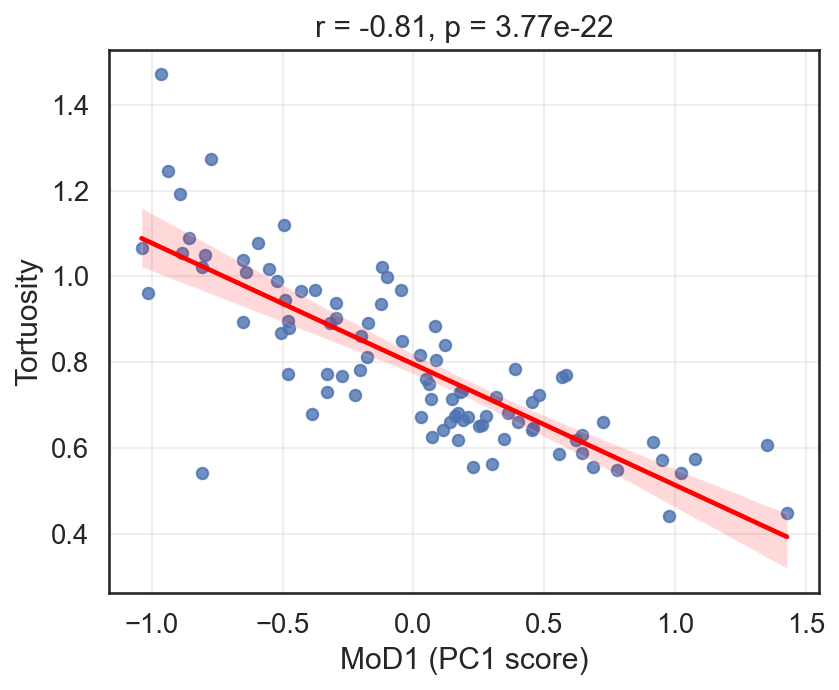

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import pearsonr

# === Step 1. 收集 tortuosity & scores ===
scores = aligned_projected_data  # shape (n_samples, n_components)
MoD1, MoD2, MoD3 = scores[:, 0], scores[:, 1], scores[:, 2]

names = list(vtk_data_dict.keys())
tortuosity_list = []

for idx, name in enumerate(names):
    rec = vtk_data_dict[name]
    tort = rec["cell_data"]["Tortuosity"]
    tortuosity_list.append(tort)

# 转换为 numpy array
tortuosity_list = np.array(tortuosity_list).ravel()

# === Step 2. 绘制相关性图 ===
def scatter_with_corr(x, y, xlabel, ylabel, ax):
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    mask = ~np.isnan(y)
    x, y = x[mask], y[mask]
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={'s':30}, line_kws={'color':'red'})
    r, p = pearsonr(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"r = {r:.2f}, p = {p:.2e}")
    ax.grid(alpha=0.3)

# === Step 3. 只画 MoD1 vs Tortuosity ===
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

scatter_with_corr(MoD1, tortuosity_list, "MoD1 (PC1 score)", "Tortuosity", ax)

plt.tight_layout()
plt.show()


Var[γ'(s)] vs MoD2: PearsonRResult(statistic=0.0541930880882176, pvalue=0.609912910873443)
Mean[γ'(s)] vs MoD2: PearsonRResult(statistic=0.19044857923764644, pvalue=0.07056952937883627)
Δγ interval 0.0-0.2 vs MoD2: PearsonRResult(statistic=-0.03824165959552529, pvalue=0.718928726353186)
Δγ interval 0.2-0.4 vs MoD2: PearsonRResult(statistic=-0.13317049749112525, pvalue=0.20824073270503443)
Δγ interval 0.4-0.6 vs MoD2: PearsonRResult(statistic=0.19527776984895084, pvalue=0.06359892208676905)
Δγ interval 0.6-0.8 vs MoD2: PearsonRResult(statistic=0.015741539669093904, pvalue=0.8822654150432788)
Δγ interval 0.8-1.0 vs MoD2: PearsonRResult(statistic=-0.1144074797397917, pvalue=0.280212997702483)


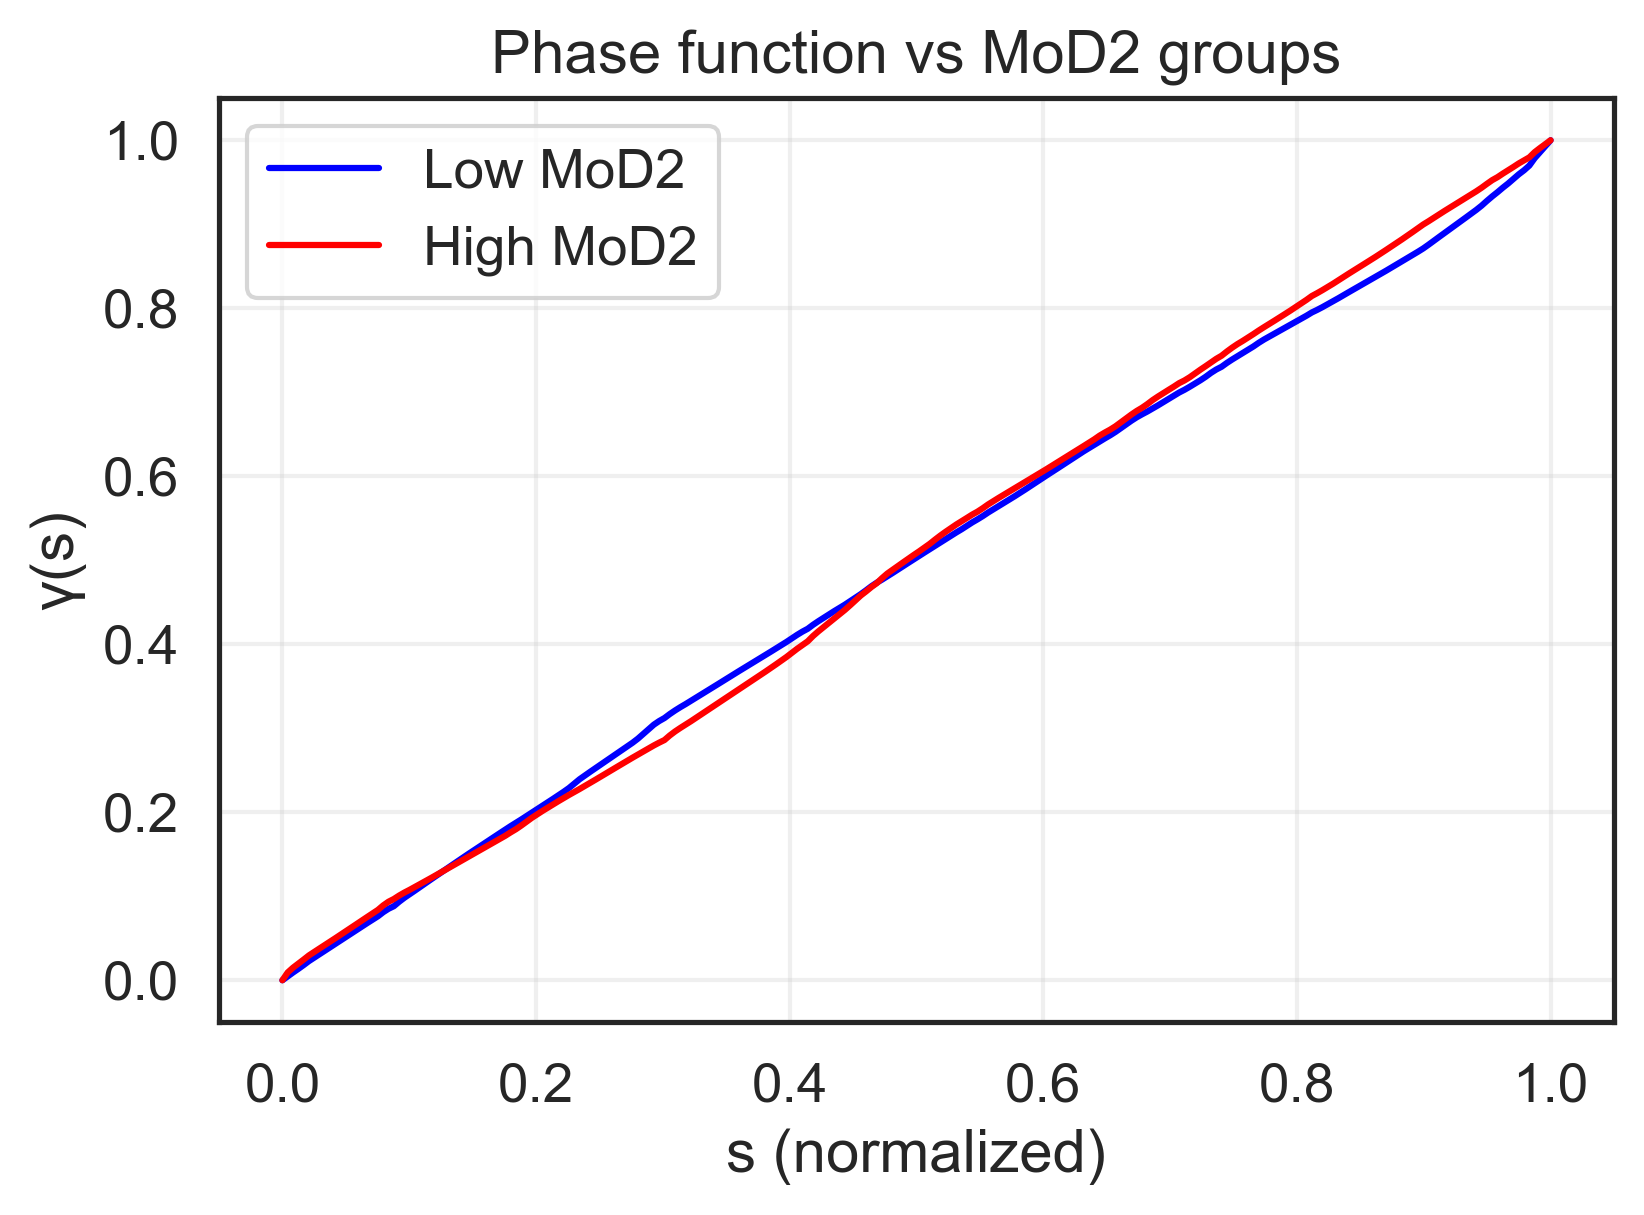

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === Step 1. 转置 gamma(s)，确保 (n_samples, T) ===
gammas = obj_weighted.gam.T   # (91, 240)
n_samples, T = gammas.shape
s = np.linspace(0, 1, T)

# 求导 γ'(s)
gamma_derivs = np.gradient(gammas, axis=1) / (1/T)  # (91, 240)

# === Step 2. 定义特征 ===
var_gamma_prime = np.var(gamma_derivs, axis=1)   # (91,)
mean_gamma_prime = np.mean(gamma_derivs, axis=1) # (91,)

# 区间 Δγ
intervals = [(0,0.2),(0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,1.0)]
delta_gammas = {}
for i, (a,b) in enumerate(intervals):
    idx_a = int(round(a*(T-1)))
    idx_b = int(round(b*(T-1)))
    delta_gammas[i] = gammas[:, idx_b] - gammas[:, idx_a]  # (91,)

# === Step 3. 相关性 ===
MoD2 = aligned_projected_data[:,1]  # (91,)
print("Var[γ'(s)] vs MoD2:", pearsonr(var_gamma_prime, MoD2))
print("Mean[γ'(s)] vs MoD2:", pearsonr(mean_gamma_prime, MoD2))
for i,(a,b) in enumerate(intervals):
    print(f"Δγ interval {a:.1f}-{b:.1f} vs MoD2:", pearsonr(delta_gammas[i], MoD2))

# === Step 4. 可视化高低组 ===
idx_sorted = np.argsort(MoD2)
low_idx = idx_sorted[:n_samples//4]
high_idx = idx_sorted[-n_samples//4:]

mean_low = gammas[low_idx].mean(axis=0)
mean_high = gammas[high_idx].mean(axis=0)

plt.figure(figsize=(6,4))
plt.plot(s, mean_low, label="Low MoD2", color="blue")
plt.plot(s, mean_high, label="High MoD2", color="red")
plt.xlabel("s (normalized)")
plt.ylabel("γ(s)")
plt.legend()
plt.title("Phase function vs MoD2 groups")
plt.grid(alpha=0.3)
plt.show()


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from typing import Tuple

sns.set(style="whitegrid", context="talk", font_scale=1.2)

# =========================
# 必要的已知变量（来自你现有环境）
# - time: 1D array, shape (T,), 已归一化到 [0,1]
# - sorted_peaks: mean_curve 上的峰索引（C0, C1, C2, ...），从左到右
# - obj_weighted.gam: warp 函数采样值，形状可能是 (T, n_samples) 或 (n_samples, T)
# - aligned_projected_data: PCA 得分矩阵, shape (n_samples, n_components)，其中第2列是 MoD2
# =========================

# ---- 配置：指出 γ 的映射方向 ----
# True  表示 γ: mean-domain s  → subject-domain t   （常见；gamma(s)与time对比接近恒等）
# False 表示 γ: subject-domain t → mean-domain s     （若如此，需取逆来获得 t=γ^{-1}(s)）
GAMMA_MAPS_MEAN_TO_SUBJECT = True

def ensure_TxN(arr, T_expected) -> np.ndarray:
    """保证 warp 矩阵为 (T, n_samples)"""
    return arr if arr.shape[0] == T_expected else arr.T

def monotone_fix_and_01(g: np.ndarray) -> np.ndarray:
    """
    对单条 γ 序列做：
    1) 限制到 [0,1]
    2) 强制非降（数值噪声时有助）
    3) 线性重标定到精确 [0,1] 区间
    """
    g = np.clip(g, 0.0, 1.0)
    g = np.maximum.accumulate(g)
    span = g[-1] - g[0]
    if span < 1e-8:
        # 极端退化：接近常数，做个轻微拉伸避免除零
        eps = 1e-6
        g = (g - g[0]) + eps * np.linspace(0, 1, g.size)
        span = g[-1] - g[0]
    g = (g - g[0]) / span
    return g

def invert_monotone_mapping(x: np.ndarray, y: np.ndarray, x_new: np.ndarray) -> np.ndarray:
    """
    给定单调映射 y = f(x)，返回 f^{-1}(x_new)（即在 y 轴上查 x）：
    - x: 原域坐标（如 subject t），严格递增
    - y: 对应的值（如 mean s），非降
    - x_new: 要在 y 轴上查找的目标（如给定 mean s*，求 subject t*）
    """
    # 为了安全，先做非降修复
    y_fixed = np.maximum.accumulate(np.clip(y, 0.0, 1.0))
    # y_fixed 单调非降，用它作为“自变量”插值回 x
    # 注意 np.interp 的签名：np.interp(x, xp, fp) -> 在 xp 上查 x，返回 fp
    # 这里我们希望：给定 y* (x_new)，在 xp=y_fixed 上查找，返回 fp=x
    # 需确保 xp 递增：y_fixed 已非降；x 假定递增（[0,1]）
    return np.interp(x_new, y_fixed, x)

def map_mean_peaks_to_subject_times(
    time: np.ndarray,
    gamma_TxN: np.ndarray,
    mean_peak_s: np.ndarray,
    maps_mean_to_subject: bool = True
) -> np.ndarray:
    """
    将 mean-curve 的 peak s 位置映射到每个样本的 subject 时间轴:
      如果 γ: s_mean -> t_subj, 直接取 t = γ(s)
      如果 γ: t_subj -> s_mean, 取逆 t = γ^{-1}(s)
    返回 shape (n_samples, n_peaks) 的矩阵，按列对应 C0, C1, C2...
    """
    T, n_samples = gamma_TxN.shape
    subj_times = np.zeros((n_samples, len(mean_peak_s)), dtype=float)

    # 预先修复 & 01 归一化所有 γ
    gam_fixed = np.empty_like(gamma_TxN)
    for j in range(n_samples):
        gam_fixed[:, j] = monotone_fix_and_01(gamma_TxN[:, j])

    # 主循环
    for j in range(n_samples):
        g = gam_fixed[:, j]  # 长度 T
        if maps_mean_to_subject:
            # γ: s -> t, 直接 t = γ(s*)
            # 在 time (s 轴) 上查 g (t)
            subj_times[j, :] = np.interp(mean_peak_s, time, g)
        else:
            # γ: t -> s，需要反查：给定 s*，求 t*
            # x = subject t 轴, y = mean s 轴
            subj_times[j, :] = invert_monotone_mapping(x=time, y=g, x_new=mean_peak_s)

        # 数值安全：限制到 [0,1]
        subj_times[j, :] = np.clip(subj_times[j, :], 0.0, 1.0)

    return subj_times

# ---------- 主流程 ----------

# 1) 取 mean-curve 的 C0, C1, C2 在 mean 域的 s 坐标
C0_s, C1_s, C2_s = time[sorted_peaks[0]], time[sorted_peaks[1]], time[sorted_peaks[2]]
mean_peak_s = np.array([C0_s, C1_s, C2_s], dtype=float)

# 2) 整理 warp 矩阵为 (T, n_samples)
gamma_TxN = ensure_TxN(obj_weighted.gam, T_expected=len(time))  # shape: (T, n_samples)
T, n_samples = gamma_TxN.shape

# 3) 把 mean 的 landmarks 映射到每个样本的 subject 时间轴
subj_peak_times = map_mean_peaks_to_subject_times(
    time=time,
    gamma_TxN=gamma_TxN,
    mean_peak_s=mean_peak_s,
    maps_mean_to_subject=GAMMA_MAPS_MEAN_TO_SUBJECT
)
# subj_peak_times[:, 0] -> 每个样本的 C0_t；[:,1] -> C1_t；[:,2] -> C2_t

# 4) 计算每个样本的 siphon 比例（C0→C2）
siphon_ratio = subj_peak_times[:, 2] - subj_peak_times[:, 0]
# 保险起见，裁剪到 [0,1]
siphon_ratio = np.clip(siphon_ratio, 0.0, 1.0)

# 也可选分解为两个子段的比例，辅助诊断
seg_C0C1 = np.clip(subj_peak_times[:, 1] - subj_peak_times[:, 0], 0.0, 1.0)
seg_C1C2 = np.clip(subj_peak_times[:, 2] - subj_peak_times[:, 1], 0.0, 1.0)

# 5) 取 MoD2 得分并对齐样本数
MoD2 = aligned_projected_data[:, 1].reshape(-1)
assert MoD2.shape[0] == n_samples, "样本数不一致：MoD2 与 warp 数量不同"

# 6) 相关性分析
mask = ~np.isnan(MoD2) & ~np.isnan(siphon_ratio)
r_p, p_p = pearsonr(MoD2[mask], siphon_ratio[mask])
r_s, p_s = spearmanr(MoD2[mask], siphon_ratio[mask])

print(f"[Pearson] MoD2 vs siphon_ratio (C0→C2): r = {r_p:.3f}, p = {p_p:.3e}")
print(f"[Spearman] MoD2 vs siphon_ratio (C0→C2): ρ = {r_s:.3f}, p = {p_s:.3e}")

# 子段也输出看看（可选）
r_p_01, p_p_01 = pearsonr(MoD2[mask], seg_C0C1[mask])
r_p_12, p_p_12 = pearsonr(MoD2[mask], seg_C1C2[mask])
print(f"[Pearson] MoD2 vs seg_C0C1: r = {r_p_01:.3f}, p = {p_p_01:.3e}")
print(f"[Pearson] MoD2 vs seg_C1C2: r = {r_p_12:.3f}, p = {p_p_12:.3e}")



[Pearson] MoD2 vs siphon_ratio (C0→C2): r = -0.125, p = 2.371e-01
[Spearman] MoD2 vs siphon_ratio (C0→C2): ρ = -0.162, p = 1.245e-01
[Pearson] MoD2 vs seg_C0C1: r = -0.417, p = 3.911e-05
[Pearson] MoD2 vs seg_C1C2: r = 0.201, p = 5.595e-02


In [36]:
import numpy as np
import plotly.graph_objects as go
import plotly.colors as pc

# === 函数：在某个PC方向上做 ±σ 重建 ===
def reconstruct_along_pc(tpca, base_curve, pc_index, n_std, discrete_curves_space):
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    std = np.sqrt(tpca.explained_variance_[pc_index])
    pc_vec = principal_components[pc_index]

    curves = []
    for s in n_std:
        for sign in [-1, 1]:
            tangent_vec = sign * s * std * pc_vec
            curve_recon = discrete_curves_space.metric.exp(
                tangent_vec=tangent_vec,
                base_point=base_curve
            )
            curves.append((sign, s, curve_recon))
    return curves

# === 参数 ===
pcs_to_show = [1, 2]     # PC2, PC3
n_std = [1, 2, 3]        # ±1σ, ±2σ, ±3σ

def plot_pc(pc_idx, n_std):
    fig = go.Figure()

    # mean curve
    fig.add_trace(go.Scatter3d(
        x=mean_curve_aligned[:,0],
        y=mean_curve_aligned[:,1],
        z=mean_curve_aligned[:,2],
        mode="lines",
        line=dict(color="black", width=6),
        name=f"PC{pc_idx+1} Mean"
    ))

    # 获取 ±σ curves
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )

    # 渐变配色
    blue_scale = pc.get_colorscale("Blues")
    red_scale = pc.get_colorscale("Reds")
    max_s = max(n_std)

    for sign, s, C in curves:
        if sign < 0:  # 蓝色渐变
            frac = s / max_s
            color = pc.sample_colorscale(blue_scale, frac)[0]
        else:         # 红色渐变
            frac = s / max_s
            color = pc.sample_colorscale(red_scale, frac)[0]

        fig.add_trace(go.Scatter3d(
            x=C[:,0], y=C[:,1], z=C[:,2],
            mode="lines",
            line=dict(color=color, width=4),
            name=f"{'+' if sign>0 else '-'}{s}σ"
        ))

    # === 布局美化 ===
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode="data"
        ),
        legend=dict(
            itemsizing="constant",
            font=dict(size=12)
        ),
        margin=dict(l=0, r=0, t=30, b=0),
        height=700,
        title=f"PC{pc_idx+1} Shape Variations (±σ)"
    )
    return fig

# 分别画 PC2 和 PC3
fig_pc2 = plot_pc(1, n_std)   # PC2 (index=1)
fig_pc3 = plot_pc(2, n_std)   # PC3 (index=2)

fig_pc2.show()
fig_pc3.show()


=== k = 2 PCs ===
[Pearson] r = -0.947, p = 1.07e-45
[Spearman] ρ = -0.949, p = 2.58e-46
=== k = 3 PCs ===
[Pearson] r = -0.593, p = 5.68e-10
[Spearman] ρ = -0.573, p = 2.86e-09
=== k = 4 PCs ===
[Pearson] r = -0.358, p = 5.01e-04
[Spearman] ρ = -0.285, p = 6.18e-03
=== k = 5 PCs ===
[Pearson] r = -0.360, p = 4.63e-04
[Spearman] ρ = -0.287, p = 5.75e-03
=== k = 6 PCs ===
[Pearson] r = -0.357, p = 5.20e-04
[Spearman] ρ = -0.297, p = 4.29e-03
=== k = 7 PCs ===
[Pearson] r = -0.359, p = 4.78e-04
[Spearman] ρ = -0.316, p = 2.26e-03
=== k = 8 PCs ===
[Pearson] r = -0.335, p = 1.17e-03
[Spearman] ρ = -0.331, p = 1.35e-03
=== k = 9 PCs ===
[Pearson] r = -0.339, p = 1.01e-03
[Spearman] ρ = -0.338, p = 1.04e-03
=== k = 10 PCs ===
[Pearson] r = -0.347, p = 7.39e-04
[Spearman] ρ = -0.349, p = 6.88e-04


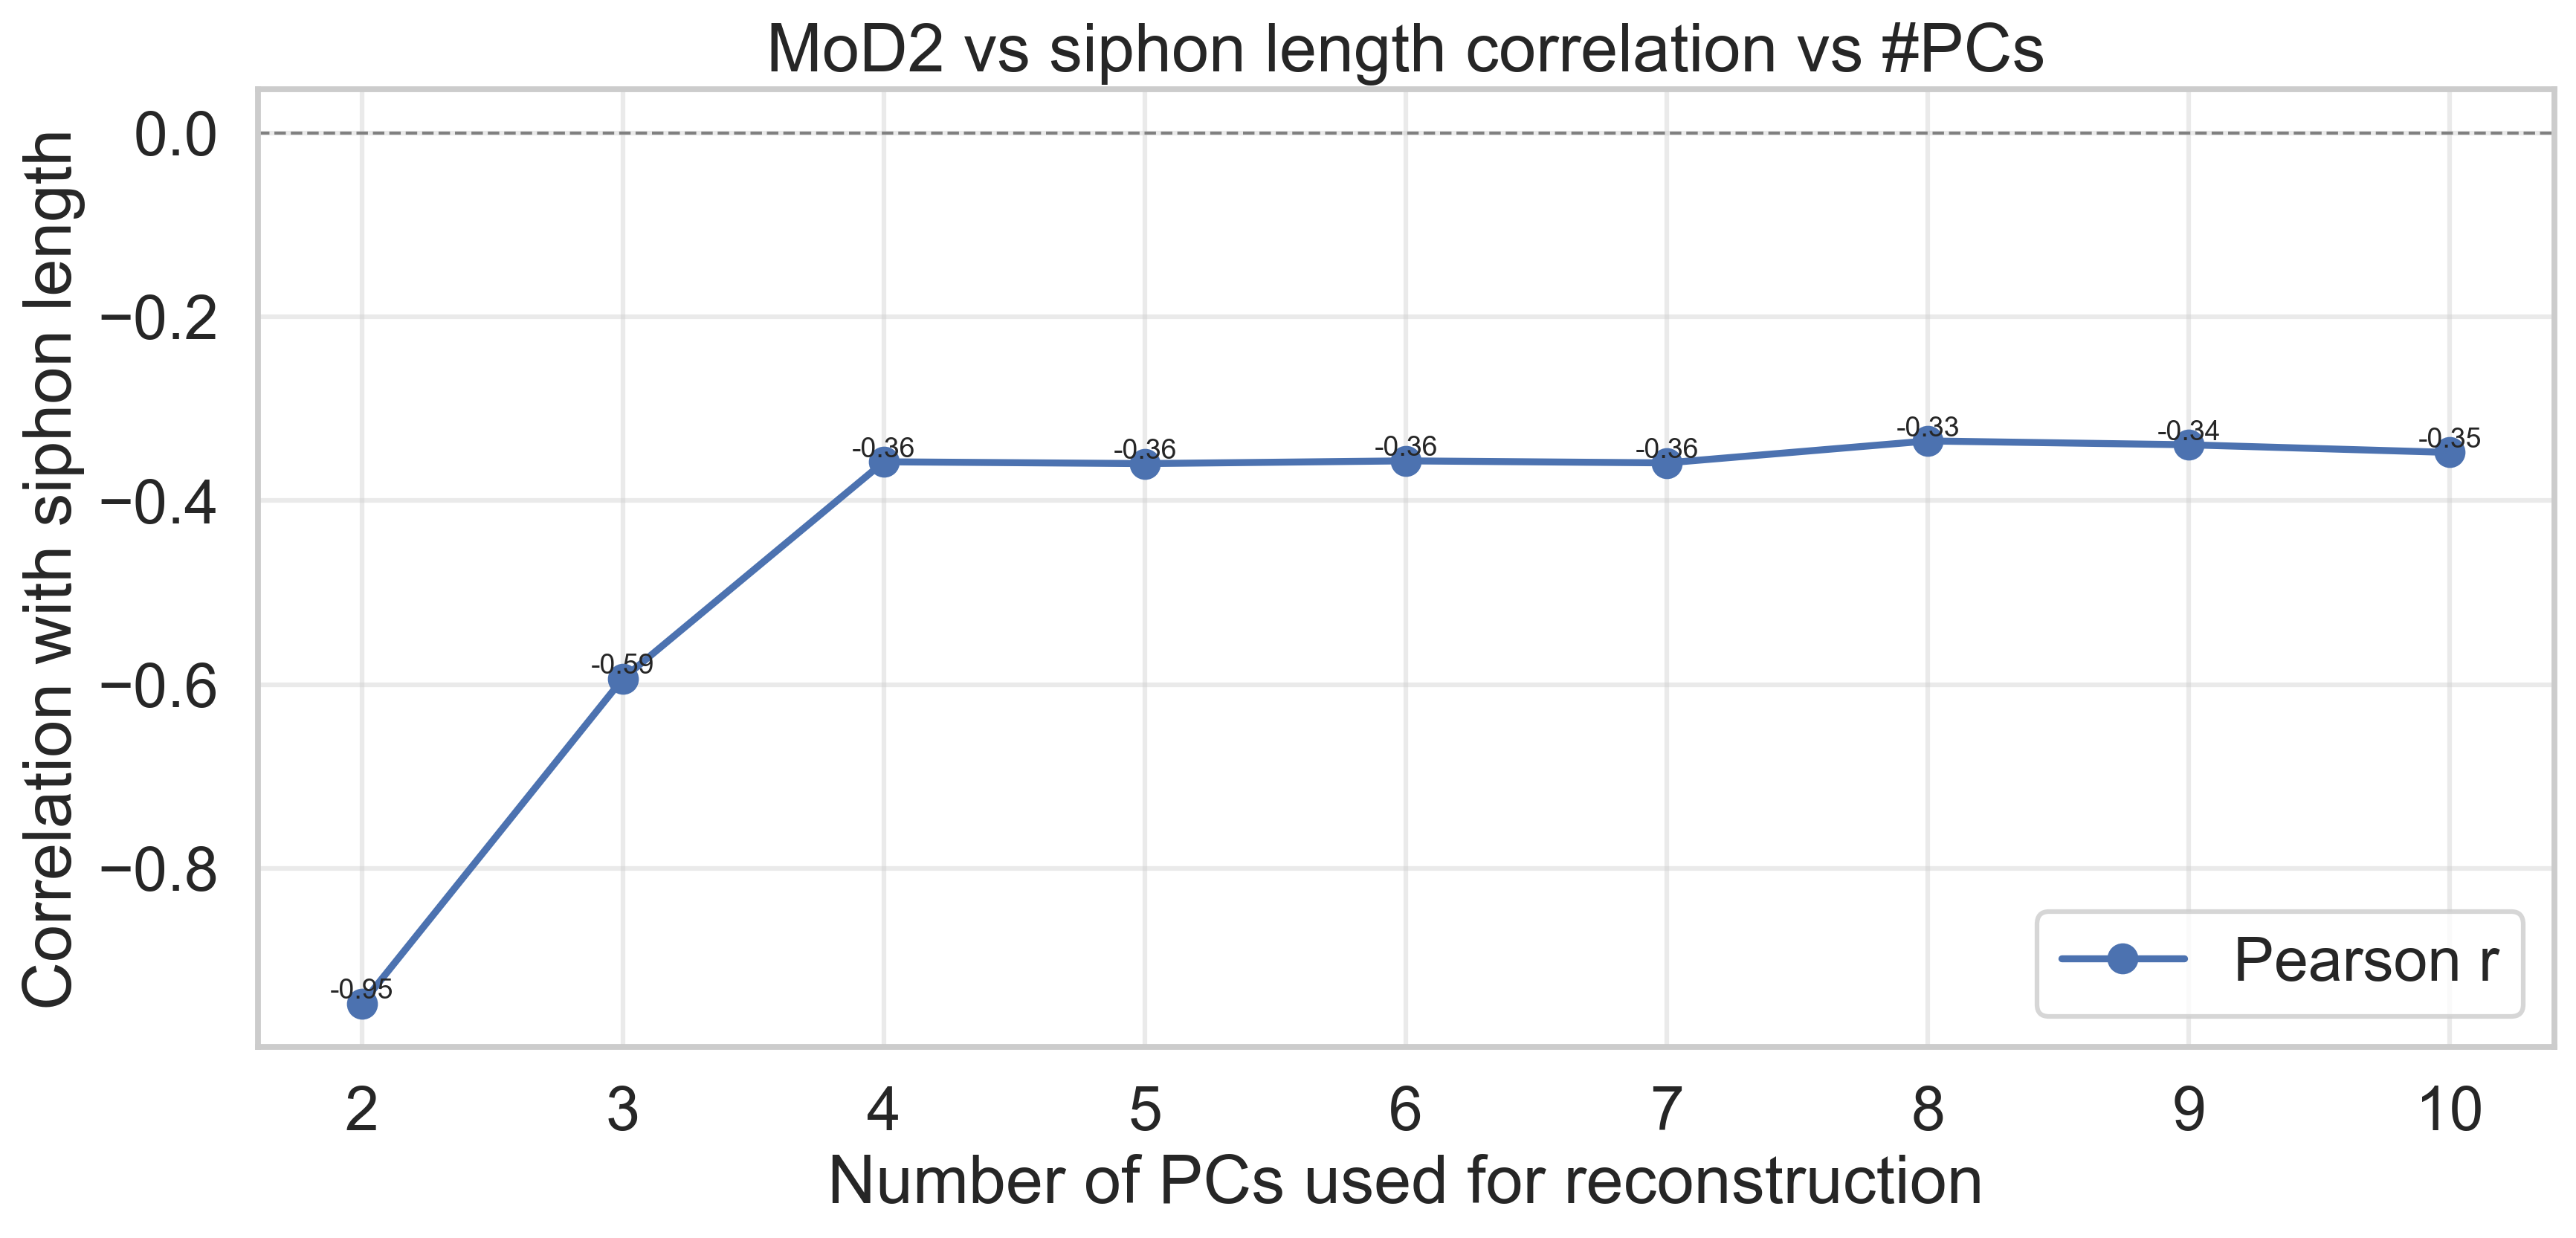

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# ========= 函数 =========
def reconstruct_with_k_pcs(tpca, projected_data, curve_idx, k, discrete_curves_space, base_curve):
    """
    用前 k 个主成分重建第 curve_idx 个样本的曲线
    """
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    coeffs = projected_data[curve_idx]

    tangent_vec = np.zeros_like(base_curve)
    for i in range(k):
        tangent_vec += coeffs[i] * principal_components[i]

    curve_recon = discrete_curves_space.metric.exp(
        tangent_vec=tangent_vec,
        base_point=base_curve
    )
    return curve_recon


def compute_arc_length(curve, idx_start, idx_end):
    """计算 curve 上 idx_start 到 idx_end 的弧长"""
    segment = curve[idx_start:idx_end+1]
    diffs = np.diff(segment, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    return np.sum(seg_lengths)


def compute_siphon_length(curve, time, sorted_peaks):
    """
    计算 siphon 长度 (C0→C2) 的弧长
    curve: (T, 3) 单条曲线
    time:  (T,) 参数化 (0~1)
    sorted_peaks: mean curve 上的峰索引 (至少有 3 个，C0, C1, C2)
    """
    C0_s, C2_s = time[sorted_peaks[0]], time[sorted_peaks[2]]

    # 找到 curve 上最接近这两个参数的位置
    idx_C0 = np.argmin(np.abs(time - C0_s))
    idx_C2 = np.argmin(np.abs(time - C2_s))

    if idx_C0 > idx_C2:  # 确保顺序
        idx_C0, idx_C2 = idx_C2, idx_C0

    return compute_arc_length(curve, idx_C0, idx_C2)


# ========= 主流程 =========
max_k = 10  # 最多看前10个PC，可以改大
n_samples = aligned_projected_data.shape[0]

results = []

for k in range(2, max_k + 1):  # 从2开始，因为我们关心 MoD2
    print(f"=== k = {k} PCs ===")
    reconstructed_curves = [
        reconstruct_with_k_pcs(
            tpca=aligned_tpca,
            projected_data=aligned_projected_data,
            curve_idx=i,
            k=k,
            discrete_curves_space=curves_r3_aligned,
            base_curve=mean_curve_aligned
        )
        for i in range(n_samples)
    ]

    # 在重建曲线上计算 siphon 长度
    siphon_lengths = np.array([
        compute_siphon_length(C, time, sorted_peaks)
        for C in reconstructed_curves
    ])
    MoD2 = aligned_projected_data[:, 1]  # PC2 得分

    # 相关性分析
    mask = ~np.isnan(MoD2) & ~np.isnan(siphon_lengths)
    r_p, p_p = pearsonr(MoD2[mask], siphon_lengths[mask])
    r_s, p_s = spearmanr(MoD2[mask], siphon_lengths[mask])

    print(f"[Pearson] r = {r_p:.3f}, p = {p_p:.2e}")
    print(f"[Spearman] ρ = {r_s:.3f}, p = {p_s:.2e}")

    results.append((k, r_p, p_p, r_s, p_s))


# ========= 保存结果并绘图 =========
results_arr = np.array(results, dtype=[
    ("k", int), ("r_p", float), ("p_p", float), ("r_s", float), ("p_s", float)
])

plt.figure(figsize=(12,6))

# Pearson 曲线
plt.plot(results_arr["k"], results_arr["r_p"], marker="o", label="Pearson r")
for k, r in zip(results_arr["k"], results_arr["r_p"]):
    plt.text(k, r, f"{r:.2f}", fontsize=9, ha="center", va="bottom")

# Spearman 曲线（如果需要可以解开）
# plt.plot(results_arr["k"], results_arr["r_s"], marker="s", label="Spearman ρ")
# for k, r in zip(results_arr["k"], results_arr["r_s"]):
#     plt.text(k, r, f"{r:.2f}", fontsize=9, ha="center", va="bottom")

plt.axhline(0, color="gray", ls="--", lw=1)
plt.xlabel("Number of PCs used for reconstruction")
plt.ylabel("Correlation with siphon length")
plt.title("MoD2 vs siphon length correlation vs #PCs")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# ========= 函数 =========
def reconstruct_with_k_pcs(tpca, projected_data, curve_idx, k, discrete_curves_space, base_curve):
    """用前 k 个主成分重建第 curve_idx 个样本的曲线"""
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    coeffs = projected_data[curve_idx]

    tangent_vec = np.zeros_like(base_curve)
    for i in range(k):
        tangent_vec += coeffs[i] * principal_components[i]

    curve_recon = discrete_curves_space.metric.exp(
        tangent_vec=tangent_vec,
        base_point=base_curve
    )
    return curve_recon


def compute_curvature(curve):
    """数值近似计算一条曲线的曲率: |r' × r''| / |r'|^3"""
    d1 = np.gradient(curve, axis=0)
    d2 = np.gradient(d1, axis=0)
    cross = np.cross(d1, d2)
    num = np.linalg.norm(cross, axis=1)
    den = np.linalg.norm(d1, axis=1) ** 3 + 1e-8
    return num / den


def extract_peak_curvatures(curve, time, sorted_peaks):
    """取曲线在 C0, C1, C2 位置的曲率值"""
    curv = compute_curvature(curve)
    idxs = [np.argmin(np.abs(time - time[sorted_peaks[i]])) for i in [0,1,2]]
    return curv[idxs]  # (C0, C1, C2)


# ========= 主流程 =========
max_k = 10
n_samples = aligned_projected_data.shape[0]

results_C0, results_C1, results_C2 = [], [], []

for k in range(2, max_k + 1):
    print(f"=== k = {k} PCs ===")

    # 重建所有样本
    reconstructed_curves = [
        reconstruct_with_k_pcs(
            tpca=aligned_tpca,
            projected_data=aligned_projected_data,
            curve_idx=i,
            k=k,
            discrete_curves_space=curves_r3_aligned,
            base_curve=mean_curve_aligned
        )
        for i in range(n_samples)
    ]

    # 取每条曲线在 C0, C1, C2 的曲率
    peak_curvs = np.array([
        extract_peak_curvatures(C, time, sorted_peaks)
        for C in reconstructed_curves
    ])  # shape (n_samples, 3)

    MoD2 = aligned_projected_data[:, 1]

    mask = ~np.isnan(MoD2)

    # 分别计算 MoD2 与 C0, C1, C2 的相关性
    for j, (label, store) in enumerate(zip(["C0","C1","C2"], [results_C0, results_C1, results_C2])):
        vals = peak_curvs[:, j]
        valid_mask = mask & ~np.isnan(vals)

        r_p, p_p = pearsonr(MoD2[valid_mask], vals[valid_mask])
        r_s, p_s = spearmanr(MoD2[valid_mask], vals[valid_mask])

        print(f"[{label}] Pearson r = {r_p:.3f}, p = {p_p:.2e} | Spearman ρ = {r_s:.3f}, p = {p_s:.2e}")
        store.append((k, r_p, p_p, r_s, p_s))


# ========= 转为数组并绘图 =========
def results_to_arr(results):
    return np.array(results, dtype=[
        ("k", int), ("r_p", float), ("p_p", float), ("r_s", float), ("p_s", float)
    ])

arr_C0 = results_to_arr(results_C0)
arr_C1 = results_to_arr(results_C1)
arr_C2 = results_to_arr(results_C2)

# plt.figure(figsize=(12,6))
# plt.plot(arr_C0["k"], arr_C0["r_p"], marker="o", label="C0 (Pearson)")
# plt.plot(arr_C1["k"], arr_C1["r_p"], marker="s", label="C1 (Pearson)")
# plt.plot(arr_C2["k"], arr_C2["r_p"], marker="^", label="C2 (Pearson)")

# # 给点加标注
# for arr, lbl in zip([arr_C0, arr_C1, arr_C2], ["C0","C1","C2"]):
#     for k, r in zip(arr["k"], arr["r_p"]):
#         plt.text(k, r, f"{r:.2f}", fontsize=8, ha="center", va="bottom")

# plt.axhline(0, color="gray", ls="--", lw=1)
# plt.xlabel("Number of PCs used for reconstruction")
# plt.ylabel("Correlation (Pearson r)")
# plt.title("MoD2 vs peak curvatures (C0, C1, C2) across PCs")
# plt.legend()
# plt.tight_layout()
# plt.show()


=== k = 2 PCs ===
[C0] Pearson r = 0.928, p = 7.87e-40 | Spearman ρ = 0.909, p = 1.36e-35
[C1] Pearson r = 0.260, p = 1.27e-02 | Spearman ρ = 0.438, p = 1.40e-05
[C2] Pearson r = 0.020, p = 8.51e-01 | Spearman ρ = 0.061, p = 5.63e-01
=== k = 3 PCs ===
[C0] Pearson r = 0.886, p = 1.83e-31 | Spearman ρ = 0.880, p = 1.78e-30
[C1] Pearson r = 0.147, p = 1.63e-01 | Spearman ρ = 0.144, p = 1.74e-01
[C2] Pearson r = 0.017, p = 8.70e-01 | Spearman ρ = 0.057, p = 5.93e-01
=== k = 4 PCs ===
[C0] Pearson r = 0.743, p = 3.31e-17 | Spearman ρ = 0.707, p = 5.06e-15
[C1] Pearson r = 0.025, p = 8.11e-01 | Spearman ρ = -0.039, p = 7.15e-01
[C2] Pearson r = -0.018, p = 8.69e-01 | Spearman ρ = 0.029, p = 7.84e-01
=== k = 5 PCs ===
[C0] Pearson r = 0.609, p = 1.49e-10 | Spearman ρ = 0.667, p = 5.53e-13
[C1] Pearson r = -0.031, p = 7.74e-01 | Spearman ρ = -0.008, p = 9.40e-01
[C2] Pearson r = -0.046, p = 6.64e-01 | Spearman ρ = 0.015, p = 8.85e-01
=== k = 6 PCs ===
[C0] Pearson r = 0.590, p = 7.40e-10 | Sp

In [39]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# ========= 函数 =========
def reconstruct_with_k_pcs(tpca, projected_data, curve_idx, k, discrete_curves_space, base_curve):
    """只用前k个PC重建曲线"""
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    coeffs = projected_data[curve_idx]

    tangent_vec = np.zeros_like(base_curve)
    for i in range(k):
        tangent_vec += coeffs[i] * principal_components[i]

    curve_recon = discrete_curves_space.metric.exp(
        tangent_vec=tangent_vec,
        base_point=base_curve
    )
    return curve_recon

def compute_arc_length(curve, idx_start, idx_end):
    """计算曲线段弧长"""
    segment = curve[idx_start:idx_end+1]
    diffs = np.diff(segment, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    return np.sum(seg_lengths)

def compute_siphon_length(curve, time, sorted_peaks):
    """siphon 长度 (C0→C2)"""
    C0_s, C2_s = time[sorted_peaks[0]], time[sorted_peaks[2]]
    idx_C0 = np.argmin(np.abs(time - C0_s))
    idx_C2 = np.argmin(np.abs(time - C2_s))
    if idx_C0 > idx_C2:
        idx_C0, idx_C2 = idx_C2, idx_C0
    return compute_arc_length(curve, idx_C0, idx_C2)

def compute_curvatures(curve):
    """简单曲率近似 (二阶差分法)，返回每点曲率"""
    d1 = np.gradient(curve, axis=0)
    d2 = np.gradient(d1, axis=0)
    num = np.linalg.norm(np.cross(d1, d2), axis=1)
    den = np.linalg.norm(d1, axis=1) ** 3 + 1e-8
    return num / den

def compute_siphon_position(curve, time, sorted_peaks):
    """C1 在 C0→C2 弧长范围中的百分比位置"""
    C0_s, C1_s, C2_s = time[sorted_peaks[0]], time[sorted_peaks[1]], time[sorted_peaks[2]]
    idx_C0 = np.argmin(np.abs(time - C0_s))
    idx_C1 = np.argmin(np.abs(time - C1_s))
    idx_C2 = np.argmin(np.abs(time - C2_s))
    if idx_C0 > idx_C2:
        idx_C0, idx_C2 = idx_C2, idx_C0
    len_total = compute_arc_length(curve, idx_C0, idx_C2)
    len_C0C1 = compute_arc_length(curve, idx_C0, idx_C1)
    return len_C0C1 / (len_total + 1e-8)

def compute_landmark_position(curve, time, sorted_peaks, lm_idx):
    """
    计算某个 landmark 在曲线整体弧长中的百分比位置
    注意：C0 (起点=0) 和 C4 (终点=1) 位置恒定，因此排除
    """
    idx_start = np.argmin(np.abs(time - time[sorted_peaks[0]]))  # 起点C0
    idx_end   = np.argmin(np.abs(time - time[sorted_peaks[-1]])) # 终点C4
    idx_lm    = np.argmin(np.abs(time - time[sorted_peaks[lm_idx]]))
    
    total_len = compute_arc_length(curve, idx_start, idx_end)
    len_C0_lm = compute_arc_length(curve, idx_start, idx_lm)
    return len_C0_lm / (total_len + 1e-8)

# ========= 主流程 =========
max_k = 10   # 前10个PC
n_samples = aligned_projected_data.shape[0]
n_landmarks = 5  # 有5个landmarks (C0..C4)

results = []

for k in range(2, max_k + 1):
    # 重建所有曲线
    reconstructed_curves = [
        reconstruct_with_k_pcs(
            tpca=aligned_tpca,
            projected_data=aligned_projected_data,
            curve_idx=i,
            k=k,
            discrete_curves_space=curves_r3_aligned,
            base_curve=mean_curve_aligned
        )
        for i in range(n_samples)
    ]

    siphon_lengths = np.array([
        compute_siphon_length(C, time, sorted_peaks) for C in reconstructed_curves
    ])
    siphon_positions = np.array([
        compute_siphon_position(C, time, sorted_peaks) for C in reconstructed_curves
    ])

    curvatures_landmarks = np.zeros((n_samples, n_landmarks))
    positions_landmarks  = np.zeros((n_samples, n_landmarks))
    for i, C in enumerate(reconstructed_curves):
        curvs = compute_curvatures(C)
        for lm_idx in range(n_landmarks):
            idx = np.argmin(np.abs(time - time[sorted_peaks[lm_idx]]))
            curvatures_landmarks[i, lm_idx] = curvs[idx]
            positions_landmarks[i, lm_idx]  = compute_landmark_position(C, time, sorted_peaks, lm_idx)

    # === 每个PC的相关性 ===
    for pc_idx in range(k):  
        pc_scores = aligned_projected_data[:, pc_idx]

        # siphon length
        mask = ~np.isnan(pc_scores) & ~np.isnan(siphon_lengths)
        r_p, p_p = pearsonr(pc_scores[mask], siphon_lengths[mask])
        r_s, p_s = spearmanr(pc_scores[mask], siphon_lengths[mask])
        results.append((k, f"PC{pc_idx+1}", "siphon_length", r_p, p_p, r_s, p_s))

        # siphon position
        mask = ~np.isnan(pc_scores) & ~np.isnan(siphon_positions)
        r_p, p_p = pearsonr(pc_scores[mask], siphon_positions[mask])
        r_s, p_s = spearmanr(pc_scores[mask], siphon_positions[mask])
        results.append((k, f"PC{pc_idx+1}", "siphon_position", r_p, p_p, r_s, p_s))

        # landmarks curvature
        for lm_idx in range(n_landmarks):
            lm_vals = curvatures_landmarks[:, lm_idx]
            mask = ~np.isnan(pc_scores) & ~np.isnan(lm_vals)
            r_p, p_p = pearsonr(pc_scores[mask], lm_vals[mask])
            r_s, p_s = spearmanr(pc_scores[mask], lm_vals[mask])
            results.append((k, f"PC{pc_idx+1}", f"intensity_C{lm_idx}", r_p, p_p, r_s, p_s))

        # landmarks position (只保留 C1–C3)
        for lm_idx in range(1, n_landmarks-1):
            lm_vals = positions_landmarks[:, lm_idx]
            mask = ~np.isnan(pc_scores) & ~np.isnan(lm_vals)
            r_p, p_p = pearsonr(pc_scores[mask], lm_vals[mask])
            r_s, p_s = spearmanr(pc_scores[mask], lm_vals[mask])
            results.append((k, f"PC{pc_idx+1}", f"shift_C{lm_idx}", r_p, p_p, r_s, p_s))

# ========= 转成 DataFrame =========
df_results_all = pd.DataFrame(
    results, columns=["k", "PC", "feature", "pearson_r", "pearson_p", "spearman_r", "spearman_p"]
)

print("=== 前20行结果 ===")
print(df_results_all.head(20))

# ===== 可选：pivot 表格便于后续画图 =====
pivot_r = df_results_all.pivot_table(
    index=["k", "PC"], columns="feature", values="pearson_r"
)
pivot_s = df_results_all.pivot_table(
    index=["k", "PC"], columns="feature", values="spearman_r"
)

print("\n=== Pearson r 矩阵 ===")
print(pivot_r.round(3).head())

print("\n=== Spearman ρ 矩阵 ===")
print(pivot_s.round(3).head())

df_results_all.to_csv("pc_feature_correlation_results_all.csv", index=False)

=== 前20行结果 ===
    k   PC          feature  pearson_r     pearson_p  spearman_r    spearman_p
0   2  PC1    siphon_length   0.111490  2.927395e-01    0.126039  2.338615e-01
1   2  PC1  siphon_position   0.443658  1.059654e-05    0.446026  9.381798e-06
2   2  PC1     intensity_C0   0.371528  2.880108e-04    0.348224  7.184302e-04
3   2  PC1     intensity_C1  -0.796278  3.927125e-21   -0.782545  5.173516e-20
4   2  PC1     intensity_C2  -0.970595  7.816626e-57   -0.992929  3.621087e-84
5   2  PC1     intensity_C3  -0.881656  8.941067e-31   -0.871763  2.546164e-29
6   2  PC1     intensity_C4  -0.405592  6.650541e-05   -0.459245  4.675905e-06
7   2  PC1         shift_C1   0.131457  2.142055e-01    0.136980  1.954035e-01
8   2  PC1         shift_C2  -0.388579  1.410698e-04   -0.376716  2.327496e-04
9   2  PC1         shift_C3  -0.206335  4.973085e-02   -0.273849  8.622787e-03
10  2  PC2    siphon_length  -0.947078  1.067599e-45   -0.948782  2.583629e-46
11  2  PC2  siphon_position  -0.87398

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 定义 PC 排序函数
def pc_sort_key(pc_label):
    return int(pc_label.replace("PC", ""))

# 画折线图：每个 PC 在某个特征上的相关性随 k 的变化
def plot_feature_trends(df_results, feature_name, corr_type="pearson_r"):
    plt.figure(figsize=(10,6))
    
    for pc, group in df_results[df_results["feature"] == feature_name].groupby("PC"):
        if pc_sort_key(pc) > 8:   # 只画 PC1-PC8
            continue
        group = group.sort_values("k")
        plt.plot(group["k"], group[corr_type], marker="o", label=pc)
    
    plt.axhline(0, color="gray", ls="--", lw=1)
    plt.ylim(-1, 1)   # 统一纵轴范围
    plt.xlim(2, 10)   # 横轴固定到 k=10
    plt.xlabel("Number of PCs used for reconstruction (k)")
    plt.ylabel(f"{corr_type}")
    plt.title(f"{feature_name}: {corr_type} vs k")
    # legend 按 PC 序号排序
    handles, labels = plt.gca().get_legend_handles_labels()
    order = sorted(range(len(labels)), key=lambda i: pc_sort_key(labels[i]))
    plt.legend([handles[i] for i in order], [labels[i] for i in order], 
               bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# # 1. siphon 相关
# plot_feature_trends(df_results_all, feature_name="siphon_length", corr_type="pearson_r")
# plot_feature_trends(df_results_all, feature_name="siphon_position", corr_type="pearson_r")

# 2. curvature (C0–C4)
# for i in range(5):
#     plot_feature_trends(df_results_all, feature_name=f"curvature_C{i}", corr_type="pearson_r")

# # 3. landmark position (只保留 C1–C3)
# for i in range(1, 4):
#     plot_feature_trends(df_results_all, feature_name=f"position_C{i}", corr_type="pearson_r")




C:\Users\cheno\AppData\Local\Temp\ipykernel_46188\3399272221.py:92: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

INFO: maxp pruned
INFO: LTSH dropped
INFO: cmap pruned
INFO: kern dropped
INFO: post pruned
INFO: PCLT dropped
INFO: GPOS pruned
INFO: GSUB pruned
INFO: JSTF dropped
INFO: meta dropped
INFO: DSIG dropped
INFO: name pruned
INFO: glyf pruned
INFO: Added gid0 to subset
INFO: Added first four glyphs to subset
INFO: Closing glyph list over 'GSUB': 30 glyphs before
INFO: Glyph names: ['.notdef', 'C', 'P', 'a', 'e', 'eight', 'f', 'five', 'four', 'glyph00001', 'glyph00002', 'h', 'i', 'k', 'minus', 'n', 'o', 'one', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'y', 'zero']
INFO: Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38, 51, 66, 68, 72, 73, 75, 76, 78, 81, 82, 85, 86, 87, 92, 237]
INFO: Closed glyph list over 'GSUB': 49 glyphs after
INFO: Glyph names: ['.

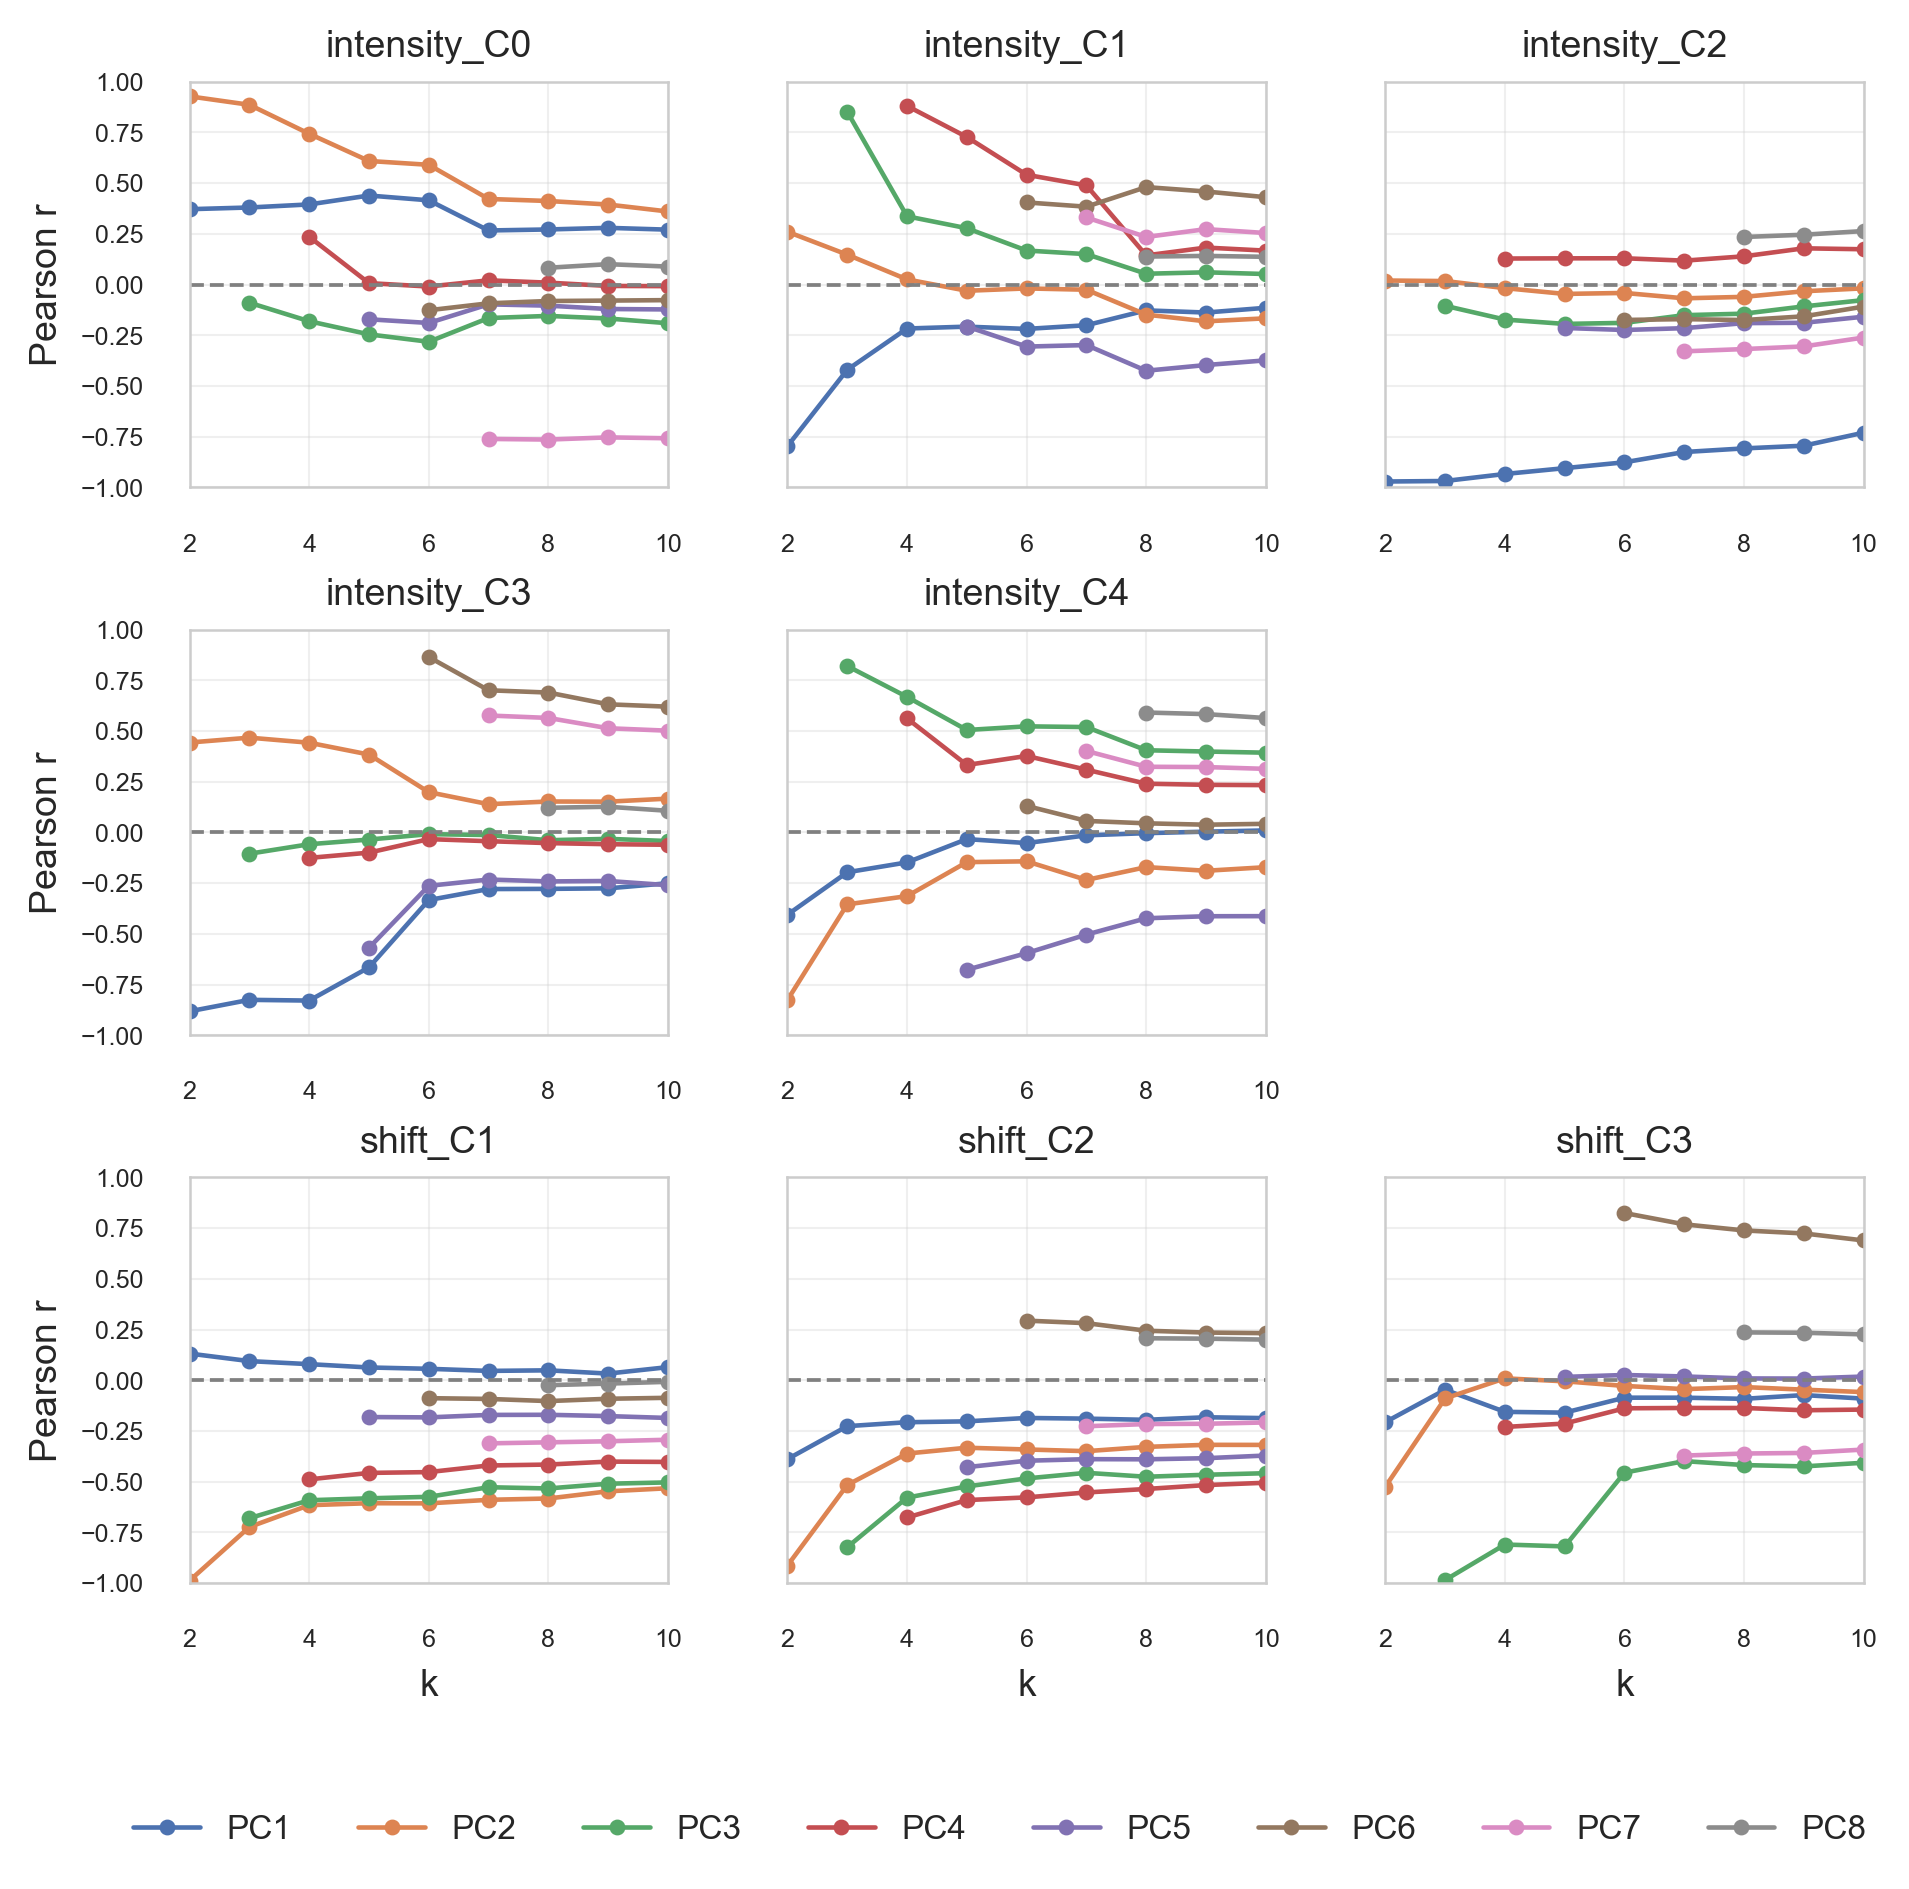

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---- 全局样式参数 ----
mpl.rcParams.update({
    "font.size": 7,          # 默认字体大小
    "axes.titlesize": 7,     # 子图标题
    "axes.labelsize": 7,     # 坐标轴标签
    "xtick.labelsize": 6,    # x 轴刻度
    "ytick.labelsize": 6,    # y 轴刻度
    "legend.fontsize": 6,    # 图例字体
    "axes.linewidth": 0.6,   # 坐标轴边框线宽
    "grid.linewidth": 0.5,   # 网格线宽
    "grid.alpha": 0.3,       # 网格透明度
})

# 矢量 PDF 设置：文字保持为文本
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42
# 可选字体
# mpl.rcParams["font.family"] = "Times New Roman"

# ---- PC 排序函数 ----
def pc_sort_key(pc_label):
    return int(pc_label.replace("PC", ""))

# ---- 布局顺序（与论文描述一致）----
row1 = [f"intensity_C{i}" for i in range(3)]      # C0, C1, C2
row2 = [f"intensity_C{i}" for i in range(3, 5)]   # C3, C4
row3 = [f"shift_C{i}"  for i in range(1, 4)]   # C1, C2, C3

# ---- 建图（两栏论文建议宽度 ~7.2 in）----
fig = plt.figure(figsize=(7.2, 6.5))
gs  = fig.add_gridspec(nrows=3, ncols=3, height_ratios=[1,1,1], wspace=0.25, hspace=0.35)

# ---- 按网格放置子图 ----
axes_map = {}
# 第一行
axes_map[row1[0]] = fig.add_subplot(gs[0, 0])
axes_map[row1[1]] = fig.add_subplot(gs[0, 1])
axes_map[row1[2]] = fig.add_subplot(gs[0, 2])
# 第二行（占 0、1 列，留一个空位使视觉上居中）
axes_map[row2[0]] = fig.add_subplot(gs[1, 0])
axes_map[row2[1]] = fig.add_subplot(gs[1, 1])
# 第三行
axes_map[row3[0]] = fig.add_subplot(gs[2, 0])
axes_map[row3[1]] = fig.add_subplot(gs[2, 1])
axes_map[row3[2]] = fig.add_subplot(gs[2, 2])

# ---- 绘制每个子图 ----
for feat, ax in axes_map.items():
    sub = df_results_all[df_results_all["feature"] == feat]
    for pc, grp in sub.groupby("PC"):
        if pc_sort_key(pc) > 8:
            continue
        grp = grp.sort_values("k")
        ax.plot(grp["k"], grp["pearson_r"], marker="o", ms=2.8, lw=1.1, label=pc)

    ax.axhline(0, color="gray", ls="--", lw=0.9)
    ax.set_ylim(-1, 1)
    ax.set_xlim(2, 10)
    ax.set_title(feat, fontsize=9)

# ---- 标签 & 刻度控制 ----
left_feats   = [row1[0], row2[0], row3[0]]  # 每行的第一个图 → 显示 y 轴
bottom_feats = row3                         # 最后一行 → 显示 x 轴

for feat, ax in axes_map.items():
    if feat in left_feats:
        ax.set_ylabel("Pearson r", fontsize=9)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])   # 非最左列去掉 y 轴刻度
    if feat in bottom_feats:
        ax.set_xlabel("k", fontsize=9)
    else:
        ax.set_xlabel("")
    # 调整刻度标签靠近轴
    ax.tick_params(axis="y", which="major", pad=2)
    ax.tick_params(axis="x", which="major", pad=2)

# ---- 统一 legend 放底部外侧 ----
any_ax = axes_map[row1[0]]
handles, labels = any_ax.get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda i: pc_sort_key(labels[i]))
fig.legend([handles[i] for i in order],
           [labels[i] for i in order],
           loc="lower center", ncol=8, bbox_to_anchor=(0.5, -0.04),
           fontsize=8, frameon=False)

# ---- 紧凑排版（为底部 legend 预留空间）----
plt.tight_layout(rect=[0, 0.05, 1, 1])

# ---- 保存为矢量 PDF ----
plt.savefig("pc_feature_trends.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [42]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_feature_heatmap(df_results, feature_name, corr_type="pearson_r"):
#     # 筛选该特征的数据
#     df_feat = df_results[df_results["feature"] == feature_name].copy()
    
#     # 只保留 PC1-PC8
#     df_feat["PC_num"] = df_feat["PC"].str.extract("PC(\d+)").astype(int)
#     df_feat = df_feat[df_feat["PC_num"] <= 8]
    
#     # 透视表：行=PC，列=k，值=相关系数
#     pivot_table = df_feat.pivot_table(
#         index="PC_num", columns="k", values=corr_type
#     ).sort_index()
    
#     # 画热图
#     plt.figure(figsize=(10,6))
#     sns.heatmap(
#         pivot_table, 
#         cmap="RdBu_r", 
#         vmin=-1, vmax=1,  # 统一颜色范围
#         annot=True, fmt=".2f", cbar_kws={"label": corr_type}
#     )
#     plt.title(f"{feature_name}: {corr_type} heatmap (PC1–PC8, k=2–10)")
#     plt.xlabel("Number of PCs used for reconstruction (k)")
#     plt.ylabel("PC")
#     plt.yticks(rotation=0)  # PC标签横放
#     plt.tight_layout()
#     plt.show()

# # ===== 使用示例 =====
# plot_feature_heatmap(df_results_all, feature_name="siphon_length", corr_type="pearson_r")
# # 例如还可以:
# plot_feature_heatmap(df_results_all, feature_name="siphon_position", corr_type="pearson_r")
# for i in range(5):
#     feat = f"curvature_C{i}"
#     plot_feature_heatmap(df_results_all, feature_name=feat, corr_type="pearson_r")


# # ====== 位置统计（C1–C3）的热图 ======
# for i in range(1, 4):  # 只保留 C1–C3
#     feat = f"position_C{i}"
#     plot_feature_heatmap(df_results_all, feature_name=feat, corr_type="pearson_r")



In [43]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def pc_sort_key(pc_label):
    return int(pc_label.replace("PC", ""))

def compute_persistence_metrics(
    df_results_all: pd.DataFrame,
    feature_name: str = "position_C1",
    corr_type: str = "pearson_r",
    p_col: str = "pearson_p",
    alpha: float = 0.05,
    tau: float = 0.5,     # half-life 阈值比例
    pc_max: int = 8       # 只看 PC1~PC8（可改为 None 看全部）
) -> pd.DataFrame:
    """
    计算在给定 feature 上，各 PC 的“影响持久度”指标。
    需要 df_results_all 含列：["k","PC","feature",corr_type,p_col]
    """
    # 取该 feature 的数据
    df_feat = df_results_all[df_results_all["feature"] == feature_name].copy()

    # 只保留 PC1~PC8（可按需关闭）
    if pc_max is not None:
        df_feat["PC_num"] = df_feat["PC"].str.extract(r"PC(\d+)").astype(int)
        df_feat = df_feat[df_feat["PC_num"] <= pc_max]

    # 去重防护（同 (k,PC,feature) 重复行）
    df_feat = df_feat.drop_duplicates(subset=["k","PC","feature"])

    pcs = sorted(df_feat["PC"].unique(), key=pc_sort_key)
    rows = []

    for pc in pcs:
        g = df_feat[df_feat["PC"] == pc].sort_values("k")
        ks = g["k"].to_numpy()
        r  = g[corr_type].to_numpy()
        p  = g[p_col].to_numpy()

        if ks.size == 0:
            continue

        abs_r = np.abs(r)
        kmin, kmax = ks[0], ks[-1]

        # 1) AUC_norm（用梯形法则 / 区间长度）
        auc = np.trapz(abs_r, ks) / (kmax - kmin) if kmax > kmin else np.mean(abs_r)

        # 2) Half-life index（首次跌破 tau*初值 的 k；未跌破则记满分 1）
        start = abs_r[0]
        thresh = tau * start
        below = np.where(abs_r <= thresh)[0]
        if below.size == 0:
            hl_index = 1.0
            k_half = np.nan
        else:
            k_half = ks[below[0]]
            hl_index = (k_half - kmin) / (kmax - kmin) if kmax > kmin else 0.0
            hl_index = np.clip(hl_index, 0.0, 1.0)

        # 3) 斜率（|r| ~ k）
        # 为避免病态，只有 >=2 个 k 才做回归
        if ks.size >= 2:
            X = ks.reshape(-1,1)
            y = abs_r.reshape(-1,1)
            lr = LinearRegression().fit(X,y)
            slope = float(lr.coef_[0,0])
        else:
            slope = np.nan

        # 4) 显著性覆盖率
        sig_cov = float(np.mean(p < alpha)) if p.size > 0 else np.nan

        # 5) 最大值与其位置
        max_abs_r = float(np.max(abs_r))
        k_at_max  = int(ks[np.argmax(abs_r)])

        # 6) 稳定性（方差/标准差）
        std_abs = float(np.std(abs_r))

        # 7) 综合分数（可按需改权重）
        persistence_score = 0.4*auc + 0.3*hl_index + 0.2*sig_cov + 0.1*max_abs_r

        rows.append({
            "feature": feature_name,
            "PC": pc,
            "k_min": int(kmin),
            "k_max": int(kmax),
            "AUC_norm": auc,
            "HalfLife_index": hl_index,
            "k_half": k_half,
            "slope_|r|~k": slope,
            "SigCoverage(p<%.2f)" % alpha: sig_cov,
            "max|r|": max_abs_r,
            "k_at_max": k_at_max,
            "std_|r|": std_abs,
            "PersistenceScore": persistence_score
        })

    out = pd.DataFrame(rows)
    # 排序：综合分数优先，其次 AUC_norm、HalfLife_index
    out = out.sort_values(
        ["PersistenceScore","AUC_norm","HalfLife_index","max|r|"],
        ascending=False
    ).reset_index(drop=True)
    return out

# ====== 使用示例 ======
# 假设你已经有 df_results_all（含 position_C1 的记录）
tbl_posC1 = compute_persistence_metrics(
    df_results_all,
    feature_name="position_C1",
    corr_type="pearson_r",
    p_col="pearson_p",
    alpha=0.05,
    tau=0.5,
    pc_max=8
)
# print("=== position_C1 持久度评估（按 PersistenceScore 降序）===")
# print(tbl_posC1.round(3))

# 你也可以对其他特征做同样评估：
for feat in ["siphon_length","siphon_position","curvature_C0","curvature_C1","curvature_C2","curvature_C3","curvature_C4","position_C2","position_C3"]:
    print(f"\n=== {feat} ===")
    print(compute_persistence_metrics(df_results_all, feature_name=feat).round(3))


KeyError: 'PersistenceScore'

=== AUC_norm values (rounded to 3 decimals) ===
PC_num            1      2      3      4      5      6      7      8
feature                                                             
curvature_C0  0.346  0.588  0.191  0.029  0.132  0.088  0.759  0.093
curvature_C1  0.248  0.099  0.214  0.434  0.343  0.435  0.267  0.139
curvature_C2  0.870  0.038  0.150  0.141  0.201  0.161  0.306  0.247
curvature_C3  0.506  0.280  0.037  0.063  0.278  0.691  0.539  0.120
curvature_C4  0.082  0.256  0.518  0.315  0.496  0.056  0.334  0.580
position_C1   0.065  0.629  0.558  0.432  0.177  0.093  0.303  0.016
position_C2   0.209  0.395  0.518  0.561  0.392  0.256  0.216  0.204
position_C3   0.106  0.068  0.574  0.160  0.016  0.747  0.359  0.233


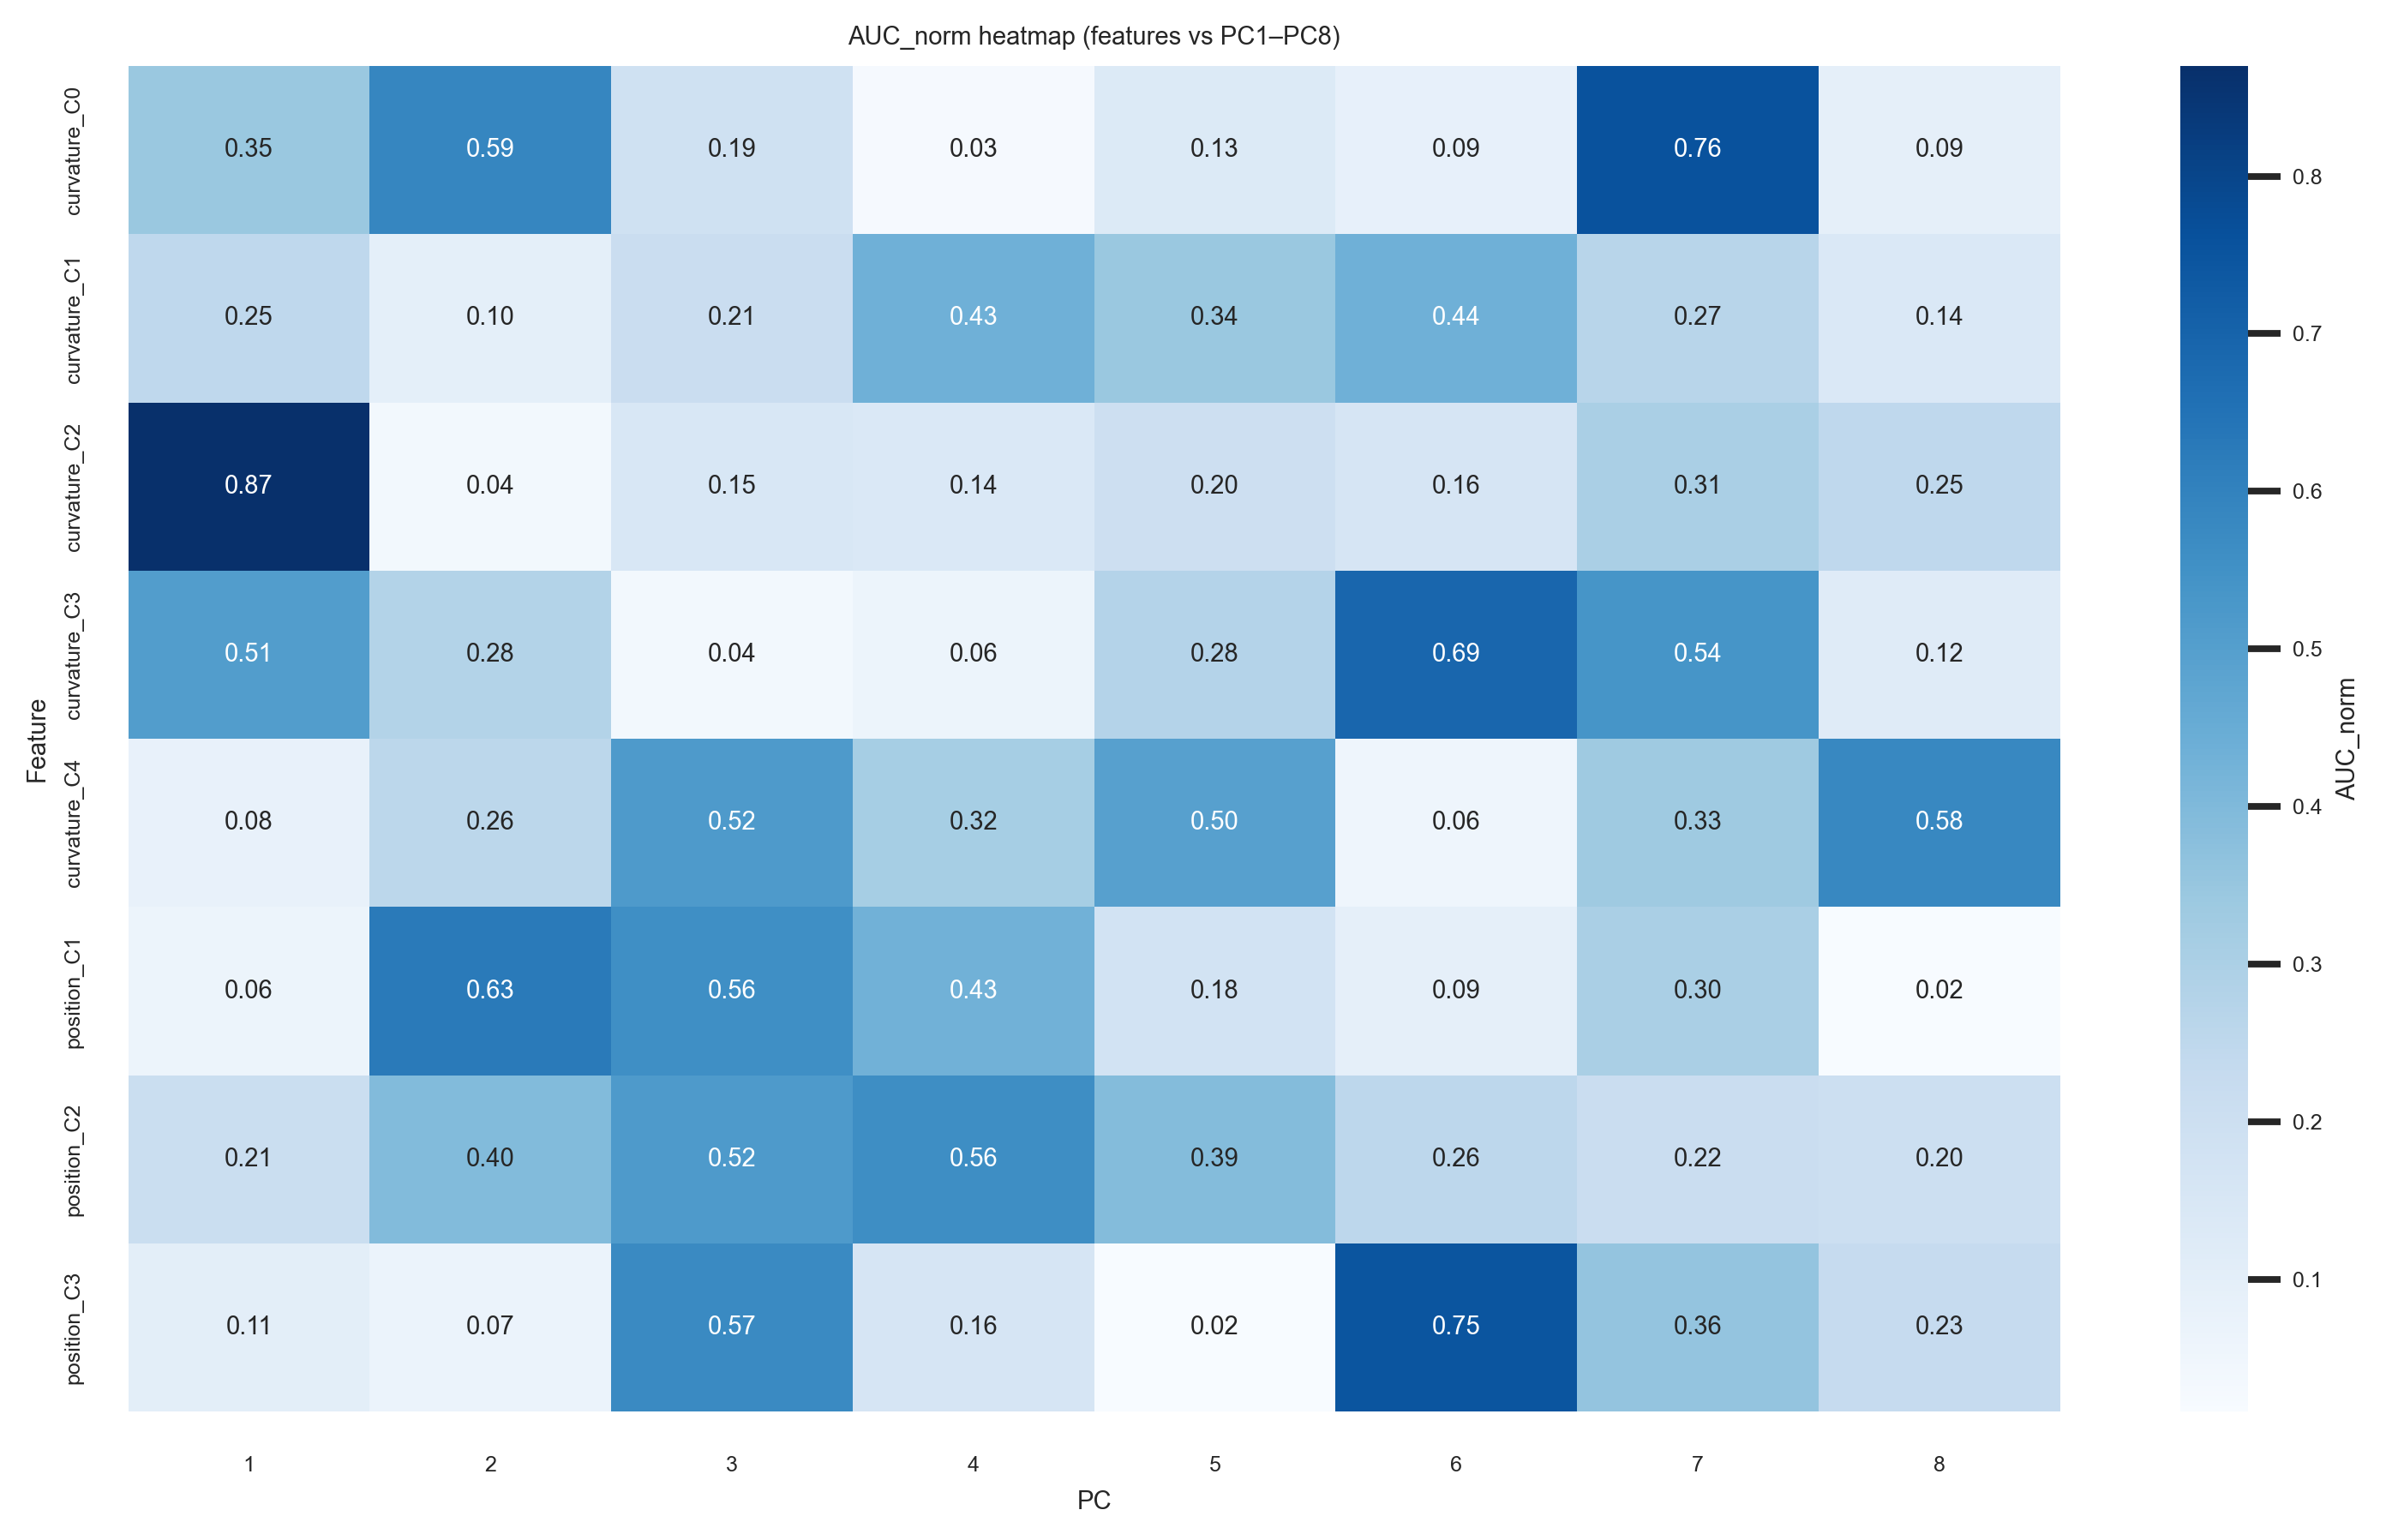

In [ ]:
import seaborn as sns

def plot_auc_heatmap(df_results_all, feature_list, corr_type="pearson_r", pc_max=8):
    rows = []
    for feat in feature_list:
        tbl = compute_persistence_metrics(
            df_results_all, 
            feature_name=feat, 
            corr_type=corr_type,
            pc_max=pc_max
        )
        for _, row in tbl.iterrows():
            rows.append((feat, row["PC"], row["AUC_norm"]))
    
    df_auc = pd.DataFrame(rows, columns=["feature","PC","AUC_norm"])
    df_auc["PC_num"] = df_auc["PC"].str.extract("PC(\d+)").astype(int)
    
    pivot_auc = df_auc.pivot(index="feature", columns="PC_num", values="AUC_norm")
    pivot_auc = pivot_auc.sort_index()

    # ==== 打印数值 ====
    print("=== AUC_norm values (rounded to 3 decimals) ===")
    print(pivot_auc.round(3))
    
    # ==== 热图 ====
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_auc, cmap="Blues", annot=True, fmt=".2f", cbar_kws={"label":"AUC_norm"})
    plt.title(f"AUC_norm heatmap (features vs PC1–PC{pc_max})")
    plt.xlabel("PC")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    return pivot_auc  # 可选：返回 DataFrame，方便后续转 LaTeX 表格

# ===== 示例 =====
feature_list = [
    "curvature_C0", "curvature_C1", "curvature_C2", "curvature_C3", "curvature_C4",
    "position_C1", "position_C2", "position_C3"
]
pivot_auc = plot_auc_heatmap(df_results_all, feature_list, corr_type="pearson_r", pc_max=8)


In [ ]:
import numpy as np
import pandas as pd

# ====== 生成 AUC norm 矩阵 ======
def compute_auc_norm(df_results, feature_list, corr_type="pearson_r", k_min=2, k_max=10):
    auc_records = []
    
    for pc in sorted(df_results["PC"].unique(), key=lambda x: int(x.replace("PC",""))):
        for feat in feature_list:
            df_sub = df_results[(df_results["PC"] == pc) & (df_results["feature"] == feat)]
            df_sub = df_sub.sort_values("k")
            
            if df_sub.empty:
                continue
            
            k_vals = df_sub["k"].values
            y_vals = np.abs(df_sub[corr_type].values)  # 用绝对值衡量强度
            
            # 积分计算 AUC
            auc = np.trapz(y_vals, x=k_vals)
            
            # 最大可能值（假设相关性恒为1）
            auc_max = (k_max - k_min) * 1.0
            auc_norm = auc / auc_max if auc_max > 0 else np.nan
            
            auc_records.append((pc, feat, auc_norm))
    
    auc_df = pd.DataFrame(auc_records, columns=["PC", "feature", "AUC_norm"])
    auc_df = auc_df.pivot(index="PC", columns="feature", values="AUC_norm")
    return auc_df

# ====== 使用示例 ======
feature_list = [
    "curvature_C0", "curvature_C1", "curvature_C2", "curvature_C3", "curvature_C4",
    "position_C1", "position_C2", "position_C3"
]
auc_df = compute_auc_norm(df_results_all, feature_list, corr_type="pearson_r")
import pandas as pd

# 如果 auc_df 已经在内存中，直接看一下结构
print("=== auc_df info ===")
print(auc_df.info())

print("\n=== auc_df 前5行 ===")
print(auc_df.head())

print("\n=== auc_df 维度 ===")
print("形状:", auc_df.shape)
print("行 (PC):", auc_df.index.tolist())
print("列 (features):", auc_df.columns.tolist())

# 如果你还没保存过，可以保存一下
auc_df.to_csv("auc_norm_matrix.csv")
print("\n已保存到 auc_norm_matrix.csv")


# 只保留 PC1–PC8
auc_df_filtered = auc_df.loc[[f"PC{i}" for i in range(1, 9)]]

def summarize_pc_influence(auc_df, topn=3):
    summary = {}
    for pc in auc_df.index:
        sorted_feats = auc_df.loc[pc].sort_values(ascending=False)
        summary[pc] = sorted_feats.head(topn).to_dict()
    return summary

# 输出每个 PC 的 top3 特征
pc_summary = summarize_pc_influence(auc_df_filtered, topn=3)

print("=== 每个PC主要影响的特征（按 AUC norm 排序, 只保留PC1–PC8） ===")
for pc, feats in pc_summary.items():
    feat_str = ", ".join([f"{f} ({v:.3f})" for f, v in feats.items()])
    print(f"{pc}: {feat_str}")


def summarize_feature_influence(auc_df, topn=3):
    summary = {}
    for feat in auc_df.columns:
        sorted_pcs = auc_df[feat].sort_values(ascending=False)
        summary[feat] = sorted_pcs.head(topn).to_dict()
    return summary

# 输出每个特征的 top3 PC
feature_summary = summarize_feature_influence(auc_df_filtered, topn=3)

print("=== 每个几何特征主要受哪些PC影响（按 AUC norm 排序, 只保留PC1–PC8） ===")
for feat, pcs in feature_summary.items():
    pcs_str = ", ".join([f"{pc} ({v:.3f})" for pc, v in pcs.items()])
    print(f"{feat}: {pcs_str}")



=== auc_df info ===
<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, PC1 to PC9
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   curvature_C0  10 non-null     float64
 1   curvature_C1  10 non-null     float64
 2   curvature_C2  10 non-null     float64
 3   curvature_C3  10 non-null     float64
 4   curvature_C4  10 non-null     float64
 5   position_C1   10 non-null     float64
 6   position_C2   10 non-null     float64
 7   position_C3   10 non-null     float64
dtypes: float64(8)
memory usage: 720.0+ bytes
None

=== auc_df 前5行 ===
feature  curvature_C0  curvature_C1  curvature_C2  curvature_C3  curvature_C4  \
PC                                                                              
PC1          0.345991      0.247885      0.869897      0.506454      0.082358   
PC10         0.000000      0.000000      0.000000      0.000000      0.000000   
PC2          0.587596      0.098792      0.037843      